Loading Cifar10 Dataset

In [3]:
import os
import torch
from torchvision.datasets import CIFAR10
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)


OSError: [WinError 182] The operating system cannot run %1. Error loading "C:\anaconda\lib\site-packages\torch\lib\shm.dll" or one of its dependencies.

Creating Symmetric Noise for the Test Set

In [4]:
#Symmetric Label Noise
def symmetric(labels, epsilon):
  indices = torch.randperm(len(labels))[:int(len(labels) * epsilon)]
  noise_labels = random_within_tensor(labels, 0, 10)
  mask = torch.zeros(len(labels), dtype=torch.bool)
  mask[indices] = True

  return torch.where(mask, noise_labels, labels)

def random_within_tensor(original_values, low, high):
    def exclude(value):
        random_number = torch.randint(low, high, size=(1,)).item()
        while random_number == value:
            random_number = torch.randint(low, high, size=(1,)).item()
        return random_number

    noise_labels = torch.clone(original_values)
    noise_labels.apply_(exclude)

    return noise_labels

y_original = torch.tensor(train_dataset.targets)
y_train_symmetric = symmetric(torch.tensor(train_dataset.targets), 0.1)
print(torch.sum(y_original==y_train_symmetric)/torch.tensor(y_original.size()))

NameError: name 'torch' is not defined

Creating Assymetric Noise for the Test Set

In [ ]:
#Asymmetric Label Noise
def asymmetric(labels, epsilon):
    classes_to_flip = {9: 1, 2: 0, 4: 7}#, 3: 5, 5: 3}
    changed_labels = torch.clone(labels)
    for key in classes_to_flip.keys():
        changed_labels = change_label(changed_labels, key, classes_to_flip[key], epsilon)

    changed_labels = change_dog_cat_labels(changed_labels, epsilon)
    return changed_labels

def change_label(labels, original_label, target_label, epsilon):
    original_indices = (labels == original_label).nonzero()
    num_labels_to_flip = int(len(original_indices) * epsilon)

    flip_indices = torch.randperm(len(original_indices))[:num_labels_to_flip]
    original_indices = original_indices[flip_indices]
    original_indices = torch.squeeze(original_indices)
    changed_labels = torch.clone(labels)
    changed_labels[original_indices] = target_label

    return changed_labels

def change_dog_cat_labels(labels, epsilon):
    cat_indices = (labels == 3).nonzero()
    dog_indices = (labels == 5).nonzero()
    num_labels_to_flip = int(len(cat_indices) * epsilon)

    flip_indices = torch.randperm(len(cat_indices))[:num_labels_to_flip]
    cat_indices = cat_indices[flip_indices]
    cat_indices = torch.squeeze(cat_indices)
    flip_indices = torch.randperm(len(dog_indices))[:num_labels_to_flip]
    dog_indices = dog_indices[flip_indices]
    dog_indices = torch.squeeze(dog_indices)

    changed_labels = torch.clone(labels)
    changed_labels[cat_indices] = 5
    changed_labels[dog_indices] = 3

    return changed_labels

y_original = torch.tensor(train_dataset.targets)
y_train_asymmetric = asymmetric(torch.tensor(train_dataset.targets), 0.1)
print(torch.sum(y_original==y_train_asymmetric)/torch.tensor(y_original.size()))

tensor([0.9500])


Sample for Model Building

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
train_loader = DataLoader(TensorDataset(torch.tensor(train_dataset.data), y_train_symmetric),
                          batch_size=64, shuffle=True)

test_loader = DataLoader(TensorDataset(torch.tensor(test_dataset.data), torch.tensor(test_dataset.targets)),
                         batch_size=64, shuffle=False)

NameError: ignored

Nosie with example

In [ ]:
import numpy as np
import random

def apply_symmetric_noise(labels, noise_rate=0.1):
    """
    Apply symmetric label noise.
    :param labels: Original label array
    :param noise_rate: Noise rate
    :return: Labels with noise
    """
    n_classes = np.unique(labels).size
    noisy_labels = labels.copy()
    for i in range(labels.size):
        if random.random() < noise_rate:
            noisy_labels[i] = random.randint(0, n_classes - 1)
    return noisy_labels

def apply_asymmetric_noise(labels, noise_rate=0.1):
    """
    Apply asymmetric label noise.
    :param labels: Original label array
    :param noise_rate: Noise rate
    :return: Labels with noise
    """
    noisy_labels = labels.copy()
    # Define asymmetric noise mapping
    label_mapping = {9: 1, 2: 0, 4: 7, 3: 5, 5: 3}
    for i in range(labels.size):
        if random.random() < noise_rate:
            original_label = labels[i]
            if original_label in label_mapping:
                noisy_labels[i] = label_mapping[original_label]
    return noisy_labels

# Extract labels from the training dataset
train_labels = np.array(train_dataset.targets)

# Apply noise
symmetric_noisy_labels = apply_symmetric_noise(train_labels, 0.3)
asymmetric_noisy_labels = apply_asymmetric_noise(train_labels, 0.3)

# Examples
print("Original Labels (first 10):", train_labels[:10])
print("Symmetric Noisy Labels (first 10):", symmetric_noisy_labels[:10])
print("Asymmetric Noisy Labels (first 10):", asymmetric_noisy_labels[:10])


Original Labels (first 10): [6 9 9 4 1 1 2 7 8 3]
Symmetric Noisy Labels (first 10): [6 8 9 4 1 8 2 7 8 3]
Asymmetric Noisy Labels (first 10): [6 9 1 4 1 1 2 7 8 3]


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
# TPU
elif 'COLAB_TPU_ADDR' in os.environ:
    # torch_xla
    !pip install cloud-tpu-client torch_xla
    import torch_xla
    import torch_xla.core.xla_model as xm
    device = xm.xla_device()
    print("Using TPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')


Using GPU: Tesla V100-SXM2-16GB
Tue Dec 12 20:22:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    25W / 300W |      2MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                        

baseline

Files already downloaded and verified
Files already downloaded and verified


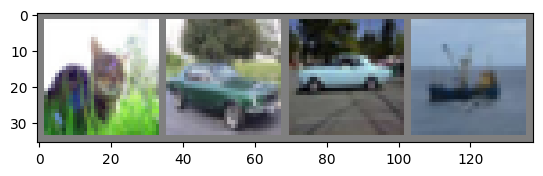

  cat   car   car  ship
[1,  6000] loss: 5.831
[1, 12000] loss: 4.560
[2,  6000] loss: 4.177
[2, 12000] loss: 3.949
[3,  6000] loss: 3.675
[3, 12000] loss: 3.617
[4,  6000] loss: 3.369
[4, 12000] loss: 3.351
Finished Training
Training Time: 153.7871868610382 seconds


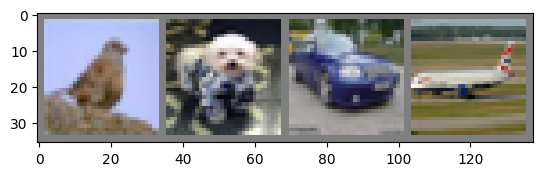

GroundTruth:   bird   dog   car plane
Predicted:   bird   car   car plane
Accuracy of the network on the 10000 test images: 60 %
Accuracy of plane : 66 %
Accuracy of   car : 73 %
Accuracy of  bird : 38 %
Accuracy of   cat : 32 %
Accuracy of  deer : 59 %
Accuracy of   dog : 47 %
Accuracy of  frog : 77 %
Accuracy of horse : 70 %
Accuracy of  ship : 72 %
Accuracy of truck : 64 %


In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader
import torch.nn.functional as F
import time
%matplotlib inline

# Data Preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader  = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader  = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

start_time = time.time()
for epoch in range(4):  # 多批次循环

    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # 获取输入
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # 移动到GPU


        # 梯度置0
        optimizer.zero_grad()

        # 正向传播，反向传播，优化
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 打印状态信息
        running_loss += loss.item()
        if i % 6000 == 5999:    # 每2000批次打印一次
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 6000))
            running_loss = 0.0

print('Finished Training')
end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time} seconds")

dataiter = iter(trainloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# 显示图片
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))


correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)  # move to GPU
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)  # move to GPU
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))




Add noise



In [ ]:
import numpy as np
import random
from torch.utils.data import DataLoader, TensorDataset

def apply_symmetric_noise(labels, noise_rate=0.1):
    """
    Apply symmetric label noise.
    :param labels: Original label array
    :param noise_rate: Noise rate
    :return: Labels with noise
    """
    n_classes = np.unique(labels).size
    noisy_labels = labels.copy()
    for i in range(labels.size):
        if random.random() < noise_rate:
            noisy_labels[i] = random.randint(0, n_classes - 1)
    return noisy_labels

def apply_asymmetric_noise(labels, noise_rate=0.1):
    """
    Apply asymmetric label noise.
    :param labels: Original label array
    :param noise_rate: Noise rate
    :return: Labels with noise
    """
    noisy_labels = labels.copy()
    # Define asymmetric noise mapping
    label_mapping = {9: 1, 2: 0, 4: 7, 3: 5, 5: 3}
    for i in range(labels.size):
        if random.random() < noise_rate:
            original_label = labels[i]
            if original_label in label_mapping:
                noisy_labels[i] = label_mapping[original_label]
    return noisy_labels

# Extract labels from the training dataset
train_labels = np.array(train_dataset.targets)

# Apply noise
symmetric_noisy_labels = apply_symmetric_noise(train_labels, 0.3)
asymmetric_noisy_labels = apply_asymmetric_noise(train_labels, 0.3)

# Examples
print("Original Labels(first 16):", train_labels[:16])
print("Symmetric Noisy Labels 0.3 (first 16):", symmetric_noisy_labels[:16])
print("Asymmetric Noisy Labels 0.3 (first 16):", asymmetric_noisy_labels[:16])

import time

def calculate_accuracy_and_class_accuracy(model, data_loader, classes):
    model.eval()
    correct = 0
    total = 0
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))

    with torch.no_grad():
        for data in data_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            c = (predicted == labels).squeeze()
            for i in range(labels.size(0)):  # 遍历批次中的每个样本
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(len(classes)):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

    return 100 * correct / total

def train_model(net, trainloader, criterion, optimizer, epochs=8):
    start_time = time.time()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 4000 == 3999:
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 4000:.3f}')
                running_loss = 0.0

    end_time = time.time()
    training_time = end_time - start_time
    overall_accuracy = calculate_accuracy_and_class_accuracy(net, testloader, classes)
    return overall_accuracy, training_time


def apply_noise(labels, noise_level, noise_type='symmetric'):
    """
    Apply symmetric or asymmetric noise.
    """
    noisy_labels = labels.copy()
    if noise_type == 'symmetric':
        for i in range(len(noisy_labels)):
            if random.random() < noise_level:
                noisy_labels[i] = random.randint(0, 9)  # assuming 10 classes
    elif noise_type == 'asymmetric':
        label_mapping = {9: 1, 2: 0, 4: 7, 3: 5, 5: 3}
        for i in range(labels.size):
            if random.random() < noise_level:
                original_label = labels[i]
                if original_label in label_mapping:
                    noisy_labels[i] = label_mapping[original_label]
    return noisy_labels

def apply_noise_and_update_loader(trainloader, original_dataset, noise_level, noise_type='symmetric'):
    """
    Apply noise to the labels and update the trainloader.
    """
    noisy_labels = apply_noise(np.array(original_dataset.targets), noise_level, noise_type)
    for i in range(len(trainloader.dataset)):
        trainloader.dataset.targets[i] = noisy_labels[i]

noise_levels = [0, 0.1, 0.3, 0.5, 0.8, 0.9]
noise_levels = [0, 0.1,0.3, 0.5, 0.9]
for noise_type in ['symmetric', 'asymmetric']:
    for noise_level in noise_levels:
        original_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
        trainloader = DataLoader(original_dataset, batch_size=4, shuffle=True, num_workers=2)
        apply_noise_and_update_loader(trainloader, original_dataset, noise_level, noise_type)
        net = Net().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

        print(f"#######   Training with {noise_type} noise level: {noise_level} ########")
        acc, training_time = train_model(net, trainloader, criterion, optimizer, epochs=4)
        print(f"Noise Level {noise_level} - Accuracy: {acc}%, Training Time: {training_time} seconds")



Original Labels(first 16): [8 6 1 2 7 8 1 1 1 6 3 7 5 1 2 0]
Symmetric Noisy Labels 0.3 (first 16): [8 5 1 4 7 8 0 1 1 6 9 0 9 1 8 0]
Asymmetric Noisy Labels 0.3 (first 16): [8 6 1 0 7 8 1 1 1 6 5 7 5 1 2 0]
Files already downloaded and verified
Training with symmetric noise level: 0
[1,  4000] loss: 1.993
[1,  8000] loss: 1.639
[1, 12000] loss: 1.506
[2,  4000] loss: 1.395
[2,  8000] loss: 1.342
[2, 12000] loss: 1.290
[3,  4000] loss: 1.214
[3,  8000] loss: 1.178
[3, 12000] loss: 1.172
Accuracy of plane : 38 %
Accuracy of   car : 58 %
Accuracy of  bird : 37 %
Accuracy of   cat : 67 %
Accuracy of  deer : 53 %
Accuracy of   dog : 34 %
Accuracy of  frog : 59 %
Accuracy of horse : 64 %
Accuracy of  ship : 90 %
Accuracy of truck : 62 %
Noise Level 0 - Accuracy: 56.55%, Training Time: 116.96293306350708 seconds
Files already downloaded and verified
Training with symmetric noise level: 0.1
[1,  4000] loss: 2.145
[1,  8000] loss: 1.819
[1, 12000] loss: 1.724
[2,  4000] loss: 1.618
[2,  8000] 

data augmentation

In [ ]:
from torchvision import transforms

# Define a transform to augment the data
augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


noise_levels = [0, 0.1, 0.3, 0.5, 0.8, 0.9]
noise_levels = [0, 0.1,0.3, 0.5, 0.9]
for noise_type in ['symmetric', 'asymmetric']:
    for noise_level in noise_levels:
        original_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=augmentation_transform)
        trainloader = DataLoader(original_dataset, batch_size=4, shuffle=True, num_workers=2)
        apply_noise_and_update_loader(trainloader, original_dataset, noise_level, noise_type)
        net = Net().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

        print(f"#######   Training with {noise_type} noise level: {noise_level} ########")
        acc, training_time = train_model(net, trainloader, criterion, optimizer, epochs=4)
        print(f"Noise Level {noise_level} - Accuracy: {acc}%, Training Time: {training_time} seconds")

Files already downloaded and verified
#######   Training with symmetric noise level: 0 ########
[1,  4000] loss: 2.093
[1,  8000] loss: 1.731
[1, 12000] loss: 1.601
[2,  4000] loss: 1.515
[2,  8000] loss: 1.465
[2, 12000] loss: 1.431
[3,  4000] loss: 1.383
[3,  8000] loss: 1.363
[3, 12000] loss: 1.354
[4,  4000] loss: 1.322
[4,  8000] loss: 1.318
[4, 12000] loss: 1.297
[5,  4000] loss: 1.269
[5,  8000] loss: 1.254
[5, 12000] loss: 1.254
Accuracy of plane : 69 %
Accuracy of   car : 80 %
Accuracy of  bird : 32 %
Accuracy of   cat : 35 %
Accuracy of  deer : 64 %
Accuracy of   dog : 30 %
Accuracy of  frog : 67 %
Accuracy of horse : 67 %
Accuracy of  ship : 62 %
Accuracy of truck : 63 %
Noise Level 0 - Accuracy: 57.35%, Training Time: 194.4094557762146 seconds
Files already downloaded and verified
#######   Training with symmetric noise level: 0.1 ########
[1,  4000] loss: 2.156
[1,  8000] loss: 1.893
[1, 12000] loss: 1.792
[2,  4000] loss: 1.742
[2,  8000] loss: 1.697
[2, 12000] loss: 1.67

L2 regularization

In [ ]:
noise_levels = [0, 0.1, 0.3, 0.5, 0.8, 0.9]
noise_levels = [0, 0.1, 0.3, 0.5, 0.9]

for noise_type in ['symmetric', 'asymmetric']:
    for noise_level in noise_levels:
        original_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
        trainloader = DataLoader(original_dataset, batch_size=4, shuffle=True, num_workers=2)
        apply_noise_and_update_loader(trainloader, original_dataset, noise_level, noise_type)
        net = Net().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

        print(f"#######   Training with {noise_type} noise level: {noise_level} ########")
        acc, training_time = train_model(net, trainloader, criterion, optimizer, epochs=4)
        print(f"Noise Level {noise_level} - Accuracy: {acc}%, Training Time: {training_time} seconds")



Files already downloaded and verified
#######   Training with symmetric noise level: 0 ########
[1,  4000] loss: 1.993
[1,  8000] loss: 1.635
[1, 12000] loss: 1.520
[2,  4000] loss: 1.417
[2,  8000] loss: 1.361
[2, 12000] loss: 1.304
[3,  4000] loss: 1.232
[3,  8000] loss: 1.221
[3, 12000] loss: 1.188
[4,  4000] loss: 1.129
[4,  8000] loss: 1.124
[4, 12000] loss: 1.115
Accuracy of plane : 70 %
Accuracy of   car : 78 %
Accuracy of  bird : 55 %
Accuracy of   cat : 33 %
Accuracy of  deer : 57 %
Accuracy of   dog : 43 %
Accuracy of  frog : 75 %
Accuracy of horse : 57 %
Accuracy of  ship : 75 %
Accuracy of truck : 59 %
Noise Level 0 - Accuracy: 60.58%, Training Time: 156.94512128829956 seconds
Files already downloaded and verified
#######   Training with symmetric noise level: 0.1 ########
[1,  4000] loss: 2.090
[1,  8000] loss: 1.803
[1, 12000] loss: 1.708
[2,  4000] loss: 1.634
[2,  8000] loss: 1.579
[2, 12000] loss: 1.565
[3,  4000] loss: 1.506
[3,  8000] loss: 1.476
[3, 12000] loss: 1.4

Adam

In [ ]:

noise_levels = [0, 0.1, 0.3, 0.5, 0.8, 0.9]
noise_levels = [0, 0.1,0.3, 0.5, 0.9]
for noise_type in ['symmetric', 'asymmetric']:
    for noise_level in noise_levels:
        original_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
        trainloader = DataLoader(original_dataset, batch_size=4, shuffle=True, num_workers=2)
        apply_noise_and_update_loader(trainloader, original_dataset, noise_level, noise_type)
        net = Net().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(net.parameters(), lr=0.001)

        print(f"#######   Training with {noise_type} noise level: {noise_level} ########")
        acc, training_time = train_model(net, trainloader, criterion, optimizer, epochs=4)
        print(f"Noise Level {noise_level} - Accuracy: {acc}%, Training Time: {training_time} seconds")



Files already downloaded and verified
#######   Training with symmetric noise level: 0 ########
[1,  4000] loss: 1.730
[1,  8000] loss: 1.468
[1, 12000] loss: 1.376
[2,  4000] loss: 1.280
[2,  8000] loss: 1.244
[2, 12000] loss: 1.221
[3,  4000] loss: 1.147
[3,  8000] loss: 1.155
[3, 12000] loss: 1.136
[4,  4000] loss: 1.064
[4,  8000] loss: 1.079
[4, 12000] loss: 1.104
Accuracy of plane : 54 %
Accuracy of   car : 72 %
Accuracy of  bird : 59 %
Accuracy of   cat : 50 %
Accuracy of  deer : 44 %
Accuracy of   dog : 23 %
Accuracy of  frog : 80 %
Accuracy of horse : 57 %
Accuracy of  ship : 77 %
Accuracy of truck : 66 %
Noise Level 0 - Accuracy: 58.6%, Training Time: 165.2750895023346 seconds
Files already downloaded and verified
#######   Training with symmetric noise level: 0.1 ########
[1,  4000] loss: 1.900
[1,  8000] loss: 1.698
[1, 12000] loss: 1.604
[2,  4000] loss: 1.534
[2,  8000] loss: 1.532
[2, 12000] loss: 1.521
[3,  4000] loss: 1.453
[3,  8000] loss: 1.445
[3, 12000] loss: 1.471

adjust learning rate

In [ ]:

# noise_levels = [0, 0.1, 0.3, 0.5, 0.8, 0.9]
# noise_levels = [0, 0.1,0.3, 0.5, 0.9]
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# for noise_type in ['symmetric', 'asymmetric']:
#     for noise_level in noise_levels:
#         original_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=augmentation_transform)
#         trainloader = DataLoader(original_dataset, batch_size=4, shuffle=True, num_workers=2)
#         apply_noise_and_update_loader(trainloader, original_dataset, noise_level, noise_type)
#         net = Net().to(device)
#         criterion = nn.CrossEntropyLoss()
#         optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#         scheduler.step()
#         print(f"#######   Training with {noise_type} noise level: {noise_level} ########")
#         acc, training_time = train_model(net, trainloader, criterion, optimizer, epochs=5)
#         print(f"Noise Level {noise_level} - Accuracy: {acc}%, Training Time: {training_time} seconds")

Resnet

In [ ]:
import torchvision.models as models
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader
import torch.nn.functional as F
import time
%matplotlib inline

# Data Preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader  = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader  = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

import torch.nn as nn
import torch.nn.functional as F

noise_levels = [0, 0.1, 0.3, 0.5, 0.8, 0.9]
noise_levels = [0, 0.1,0.3, 0.5, 0.9]
for noise_type in ['symmetric', 'asymmetric']:
    for noise_level in noise_levels:
        original_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
        trainloader = DataLoader(original_dataset, batch_size=4, shuffle=True, num_workers=2)
        apply_noise_and_update_loader(trainloader, original_dataset, noise_level, noise_type)
        net = models.resnet18(pretrained=True)
        net.fc = nn.Linear(net.fc.in_features, 10) # modify last layer for CIFAR10
        net = net.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(net.parameters(), lr=0.001)

        print(f"#######   Training with {noise_type} noise level: {noise_level} ########")
        acc, training_time = train_model(net, trainloader, criterion, optimizer, epochs=4)
        print(f"Noise Level {noise_level} - Accuracy: {acc}%, Training Time: {training_time} seconds")



100%|██████████| 170498071/170498071 [00:05<00:00, 29313879.63it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


NameError: ignored

Dropout

In [ ]:
import os
import torch
from torchvision.datasets import CIFAR10
from torchvision import datasets, transforms
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
# TPU
elif 'COLAB_TPU_ADDR' in os.environ:
    # torch_xla
    !pip install cloud-tpu-client torch_xla
    import torch_xla
    import torch_xla.core.xla_model as xm
    device = xm.xla_device()
    print("Using TPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

import torch.nn as nn
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
import numpy as np
import random
from torch.utils.data import DataLoader, TensorDataset

def apply_symmetric_noise(labels, noise_rate=0.1):
    """
    Apply symmetric label noise.
    :param labels: Original label array
    :param noise_rate: Noise rate
    :return: Labels with noise
    """
    n_classes = np.unique(labels).size
    noisy_labels = labels.copy()
    for i in range(labels.size):
        if random.random() < noise_rate:
            noisy_labels[i] = random.randint(0, n_classes - 1)
    return noisy_labels

def apply_asymmetric_noise(labels, noise_rate=0.1):
    """
    Apply asymmetric label noise.
    :param labels: Original label array
    :param noise_rate: Noise rate
    :return: Labels with noise
    """
    noisy_labels = labels.copy()
    # Define asymmetric noise mapping
    label_mapping = {9: 1, 2: 0, 4: 7, 3: 5, 5: 3}
    for i in range(labels.size):
        if random.random() < noise_rate:
            original_label = labels[i]
            if original_label in label_mapping:
                noisy_labels[i] = label_mapping[original_label]
    return noisy_labels

# Extract labels from the training dataset
train_labels = np.array(train_dataset.targets)

# Apply noise
symmetric_noisy_labels = apply_symmetric_noise(train_labels, 0.3)
asymmetric_noisy_labels = apply_asymmetric_noise(train_labels, 0.3)

# Examples
print("Original Labels(first 16):", train_labels[:16])
print("Symmetric Noisy Labels 0.3 (first 16):", symmetric_noisy_labels[:16])
print("Asymmetric Noisy Labels 0.3 (first 16):", asymmetric_noisy_labels[:16])

import time

def calculate_accuracy_and_class_accuracy(model, data_loader, classes):
    model.eval()
    correct = 0
    total = 0
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))

    with torch.no_grad():
        for data in data_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            c = (predicted == labels).squeeze()
            for i in range(labels.size(0)):  # 遍历批次中的每个样本
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(len(classes)):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

    return 100 * correct / total

def train_model(net, trainloader, criterion, optimizer, epochs=8):
    start_time = time.time()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 4000 == 3999:
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 4000:.3f}')
                running_loss = 0.0

    end_time = time.time()
    training_time = end_time - start_time
    overall_accuracy = calculate_accuracy_and_class_accuracy(net, testloader, classes)
    return overall_accuracy, training_time


def apply_noise(labels, noise_level, noise_type='symmetric'):
    """
    Apply symmetric or asymmetric noise.
    """
    noisy_labels = labels.copy()
    if noise_type == 'symmetric':
        for i in range(len(noisy_labels)):
            if random.random() < noise_level:
                noisy_labels[i] = random.randint(0, 9)  # assuming 10 classes
    elif noise_type == 'asymmetric':
        label_mapping = {9: 1, 2: 0, 4: 7, 3: 5, 5: 3}
        for i in range(labels.size):
            if random.random() < noise_level:
                original_label = labels[i]
                if original_label in label_mapping:
                    noisy_labels[i] = label_mapping[original_label]
    return noisy_labels

def apply_noise_and_update_loader(trainloader, original_dataset, noise_level, noise_type='symmetric'):
    """
    Apply noise to the labels and update the trainloader.
    """
    noisy_labels = apply_noise(np.array(original_dataset.targets), noise_level, noise_type)
    for i in range(len(trainloader.dataset)):
        trainloader.dataset.targets[i] = noisy_labels[i]

noise_levels = [0, 0.1, 0.3, 0.5, 0.8, 0.9]
noise_levels = [0, 0.1,0.3, 0.5, 0.9]
for noise_type in ['symmetric', 'asymmetric']:
    for noise_level in noise_levels:
        original_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
        trainloader = DataLoader(original_dataset, batch_size=4, shuffle=True, num_workers=2)
        apply_noise_and_update_loader(trainloader, original_dataset, noise_level, noise_type)
        net = Net().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

        print(f"#######   Training with {noise_type} noise level: {noise_level} ########")
        acc, training_time = train_model(net, trainloader, criterion, optimizer, epochs=4)
        print(f"Noise Level {noise_level} - Accuracy: {acc}%, Training Time: {training_time} seconds")

# # Define CNN with Dropout
# class CNNDropout(nn.Module):
#     def __init__(self):
#         super(CNNDropout, self).__init__()
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
#         self.dropout = nn.Dropout(0.5)
#         self.fc1 = nn.Linear(64 * 32 * 32, 256)
#         self.fc2 = nn.Linear(256, 10)

#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         x = torch.flatten(x, 1)
#         x = self.dropout(x)
#         x = F.relu(self.fc1(x))
#         return self.fc2(x)

# cnn_dropout = CNNDropout()
# optimizer_cnn_dropout = optim.Adam(cnn_dropout.parameters(), lr=0.001)

# average_loss_cnn_dropout, training_time_cnn_dropout = train(cnn_dropout, criterion, optimizer_cnn_dropout, train_loader)
# print("CNN with Dropout - Average Loss:", average_loss_cnn_dropout, "Training Time:", training_time_cnn_dropout)
# print("Training Time:", training_time)

Using CPU
/bin/bash: line 1: nvidia-smi: command not found
Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime
Original Labels(first 16): [6 9 9 4 1 1 2 7 8 3 4 7 7 2 9 9]
Symmetric Noisy Labels 0.3 (first 16): [3 9 7 4 1 8 2 7 3 3 4 7 7 2 9 4]
Asymmetric Noisy Labels 0.3 (first 16): [6 9 1 4 1 1 2 7 8 3 7 7 7 2 9 9]
Files already downloaded and verified
#######   Training with symmetric noise level: 0 ########
[1,  4000] loss: 2.041
[1,  8000] loss: 1.726
[1, 12000] loss: 1.624
[2,  4000] loss: 1.565
[2,  8000] loss: 1.527
[2, 12000] loss: 1.503
[3,  4000] loss: 1.467
[3,  8000] loss: 1.443
[3, 12000] loss: 1.429
[4,  4000] loss: 1.411
[4,  8000] loss: 1.384
[4, 12000] loss: 1.389
Accuracy of plane : 48 %
Accuracy of   car : 62 %
Accuracy of  bird : 34 %
Accuracy of   cat : 18 %
Accuracy of  deer : 47 %
Accuracy of   dog : 47 %
Accuracy of  frog : 83 %
Accuracy of horse : 52 %
Accuracy of  ship : 67 %
Accuracy of truck : 69 %
Noise Level 0 - Accuracy: 53.1%,

New model

In [ ]:
%matplotlib inline
# test harness for evaluating models on the cifar10 dataset
import sys
from matplotlib import pyplot
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = cifar10.load_data()
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    
    # show plot in the notebook
    pyplot.show()
    
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    pyplot.savefig(filename + '_plot.png')
    pyplot.close()

# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# define model
	model = define_model()
	# fit model
	history = model.fit(trainX, trainY, epochs=2, batch_size=64, validation_data=(testX, testY), verbose=2)
	# evaluate model
	_, acc = model.evaluate(testX, testY, verbose=2)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()
print('done')

C:\anaconda\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/2
782/782 - 47s - loss: 1.6876 - accuracy: 0.3891 - val_loss: 1.5850 - val_accuracy: 0.4357 - 47s/epoch - 61ms/step
Epoch 2/2
782/782 - 45s - loss: 1.3579 - accuracy: 0.5132 - val_loss: 1.2684 - val_accuracy: 0.5435 - 45s/epoch - 57ms/step
313/313 - 3s - loss: 1.2684 - accuracy: 0.5435 - 3s/epoch - 8ms/step
> 54.350


In [ ]:
# baseline model with dropout on the cifar10 dataset
import sys
from matplotlib import pyplot
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD
 
# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = cifar10.load_data()
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY
 
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm
 
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.2))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model
 
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.show()
	pyplot.close()
# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# define model
	model = define_model()
	# fit model
	history = model.fit(trainX, trainY, epochs=50, batch_size=64, validation_data=(testX, testY), verbose=2)
	# evaluate model
	_, acc = model.evaluate(testX, testY, verbose=2)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)
 
# entry point, run the test harness
run_test_harness()

C:\anaconda\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50
782/782 - 54s - loss: 2.0559 - accuracy: 0.2330 - val_loss: 1.7604 - val_accuracy: 0.3707 - 54s/epoch - 70ms/step
Epoch 2/50
782/782 - 49s - loss: 1.6814 - accuracy: 0.3781 - val_loss: 1.5239 - val_accuracy: 0.4372 - 49s/epoch - 62ms/step
Epoch 3/50
782/782 - 52s - loss: 1.5349 - accuracy: 0.4386 - val_loss: 1.3998 - val_accuracy: 0.4977 - 52s/epoch - 67ms/step
Epoch 4/50
782/782 - 52s - loss: 1.4310 - accuracy: 0.4764 - val_loss: 1.3163 - val_accuracy: 0.5285 - 52s/epoch - 66ms/step
Epoch 5/50
782/782 - 54s - loss: 1.3516 - accuracy: 0.5085 - val_loss: 1.2250 - val_accuracy: 0.5619 - 54s/epoch - 69ms/step
Epoch 6/50
782/782 - 55s - loss: 1.2853 - accuracy: 0.5351 - val_loss: 1.1859 - val_accuracy: 0.5785 - 55s/epoch - 70ms/step
Epoch 7/50
782/782 - 49s - loss: 1.2212 - accuracy: 0.5622 - val_loss: 1.1375 - val_accuracy: 0.5953 - 49s/epoch - 63ms/step
Epoch 8/50
782/782 - 51s - loss: 1.1676 - accuracy: 0.5831 - val_loss: 1.0511 - val_accuracy: 0.6323 - 51s/epoch - 66ms/step


Varify noise

In [4]:
import sys
from matplotlib import pyplot
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD
import numpy as np
import random
# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = cifar10.load_data()
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

def apply_noise_to_labels(labels, noise_level, noise_type='symmetric'):
    noisy_labels = labels.copy()
    n_classes = 10  # CIFAR-10 has 10 classes
    label_mapping = {9: 1, 2: 0, 4: 7, 3: 5, 5: 3}  # Asymmetric mapping

    for i in range(len(noisy_labels)):
        if random.random() < noise_level:
            if noise_type == 'symmetric':
                # Create a list of possible labels excluding the original one
                possible_labels = list(range(n_classes))
                possible_labels.remove(noisy_labels[i])
                noisy_labels[i] = random.choice(possible_labels)
            elif noise_type == 'asymmetric':
                # Only apply noise to labels that are in the asymmetric mapping
                if noisy_labels[i] in label_mapping:
                    noisy_labels[i] = label_mapping[noisy_labels[i]]
    return to_categorical(noisy_labels, num_classes=n_classes)


def verify_noise(labels, noisy_labels, noise_level):
    total_labels = len(labels)
    num_changed = np.sum(np.argmax(labels, axis=1) != np.argmax(noisy_labels, axis=1))
    changed_percentage = num_changed / total_labels
    print(f"Expected noise level: {noise_level}, Actual changed labels: {changed_percentage:.2f}")
    return abs(changed_percentage - noise_level) < 0.05  # Allowing a small deviation

# Example usage
trainX, trainY, testX, testY = load_dataset()
noisy_trainY = apply_noise_to_labels(np.argmax(trainY, axis=1), 0.3, 'symmetric')
is_noise_correct = verify_noise(trainY, noisy_trainY, 0.3)
print("Noise application is correct:", is_noise_correct)
noisy_trainY = apply_noise_to_labels(np.argmax(trainY, axis=1), 0, 'symmetric')
is_noise_correct = verify_noise(trainY, noisy_trainY, 0)
print("Noise application is correct:", is_noise_correct)
def verify_asymmetric_noise(labels, noisy_labels, noise_level, label_mapping):
    # 计算所有标签的总数
    total_labels = len(labels)

    # 计算实际改变的标签数量
    actual_changes = sum((labels == original) & (noisy_labels != original)
                         for original in label_mapping)
    total_actual_changes = actual_changes.sum()

    # 计算改变标签的比例（基于所有标签的总数）
    change_percentage = total_actual_changes / total_labels
    print(f"Expected asymmetric noise level: {noise_level}, Actual changed labels: {change_percentage:.2f}")
    return abs(change_percentage - noise_level) < 0.05  # 允许一定的偏差

# 示例使用
trainX, trainY, testX, testY = load_dataset()
label_mapping = {9: 1, 2: 0, 4: 7, 3: 5, 5: 3}
noisy_trainY = apply_noise_to_labels(np.argmax(trainY, axis=1), 0.3, 'asymmetric')
is_asymmetric_noise_correct = verify_asymmetric_noise(np.argmax(trainY, axis=1), np.argmax(noisy_trainY, axis=1), 0.15, label_mapping)
print("Asymmetric noise application is correct:", is_asymmetric_noise_correct)



Expected noise level: 0.3, Actual changed labels: 0.30
Noise application is correct: True
Expected noise level: 0, Actual changed labels: 0.00
Noise application is correct: True
Expected asymmetric noise level: 0.15, Actual changed labels: 0.15
Asymmetric noise application is correct: True


In [2]:
# baseline model with dropout on the cifar10 dataset
import sys
from matplotlib import pyplot
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD
 
# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = cifar10.load_data()
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY
 
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm
 
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.2))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model
 
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	pyplot.show()
	pyplot.close()
    
import numpy as np
import random
from keras.utils import to_categorical

def apply_noise_to_labels(labels, noise_level, noise_type='symmetric'):
    noisy_labels = labels.copy()
    n_classes = 10  # CIFAR-10 has 10 classes
    label_mapping = {9: 1, 2: 0, 4: 7, 3: 5, 5: 3}  # Asymmetric mapping

    for i in range(len(noisy_labels)):
        if random.random() < noise_level:
            if noise_type == 'symmetric':
                # Create a list of possible labels excluding the original one
                possible_labels = list(range(n_classes))
                possible_labels.remove(noisy_labels[i])
                noisy_labels[i] = random.choice(possible_labels)
            elif noise_type == 'asymmetric':
                # Only apply noise to labels that are in the asymmetric mapping
                if noisy_labels[i] in label_mapping:
                    noisy_labels[i] = label_mapping[noisy_labels[i]]
    return to_categorical(noisy_labels, num_classes=n_classes)

def run_test_harness(noise_level=0.0, noise_type='symmetric'):
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    
    # apply noise to labels
    trainY_noisy = apply_noise_to_labels(np.argmax(trainY, axis=1), noise_level, noise_type)

    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)

    # define model
    model = define_model()

    # fit model
    history = model.fit(trainX, trainY_noisy, epochs=40, batch_size=64, validation_data=(testX, testY), verbose=2)

    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=2)
    print(f'Noise Level {noise_level} - Noise Type {noise_type} - Accuracy: {acc * 100.0}%')

    # learning curves
#     summarize_diagnostics(history)

print ("\n\n\n") 
print(f"#######   Training with 0 noise level: ########")
run_test_harness(0, 'symmetric') 

noise_levels = [0.1, 0.3, 0.5, 0.8, 0.9]
noise_levels = [0.1, 0.3, 0.5, 0.8]
noise_types = ['symmetric', 'asymmetric']

for noise_type in noise_types:
    for noise_level in noise_levels:
        print(f"#######   Training with {noise_type} noise level: {noise_level} ########")
        run_test_harness(noise_level, noise_type)
        print ("\n\n\n") 


#######   Training with symmetric noise level: 0 ########
Epoch 1/40
782/782 - 40s - loss: 2.0893 - accuracy: 0.2222 - val_loss: 1.9016 - val_accuracy: 0.3028 - 40s/epoch - 51ms/step
Epoch 2/40
782/782 - 39s - loss: 1.7508 - accuracy: 0.3523 - val_loss: 1.6114 - val_accuracy: 0.4110 - 39s/epoch - 50ms/step
Epoch 3/40
782/782 - 40s - loss: 1.6208 - accuracy: 0.3978 - val_loss: 1.4717 - val_accuracy: 0.4617 - 40s/epoch - 51ms/step
Epoch 4/40
782/782 - 39s - loss: 1.5098 - accuracy: 0.4419 - val_loss: 1.3826 - val_accuracy: 0.4973 - 39s/epoch - 49ms/step
Epoch 5/40
782/782 - 38s - loss: 1.4318 - accuracy: 0.4749 - val_loss: 1.3107 - val_accuracy: 0.5209 - 38s/epoch - 48ms/step
Epoch 6/40
782/782 - 40s - loss: 1.3674 - accuracy: 0.5022 - val_loss: 1.2616 - val_accuracy: 0.5426 - 40s/epoch - 51ms/step
Epoch 7/40
782/782 - 39s - loss: 1.2991 - accuracy: 0.5316 - val_loss: 1.1688 - val_accuracy: 0.5851 - 39s/epoch - 50ms/step
Epoch 8/40
782/782 - 38s - loss: 1.2370 - accuracy: 0.5548 - val_lo

Epoch 25/40
782/782 - 38s - loss: 1.1304 - accuracy: 0.6616 - val_loss: 0.7928 - val_accuracy: 0.7362 - 38s/epoch - 49ms/step
Epoch 26/40
782/782 - 38s - loss: 1.1188 - accuracy: 0.6641 - val_loss: 0.8130 - val_accuracy: 0.7422 - 38s/epoch - 49ms/step
Epoch 27/40
782/782 - 39s - loss: 1.1130 - accuracy: 0.6694 - val_loss: 0.8268 - val_accuracy: 0.7362 - 39s/epoch - 50ms/step
Epoch 28/40
782/782 - 38s - loss: 1.0967 - accuracy: 0.6719 - val_loss: 0.8002 - val_accuracy: 0.7400 - 38s/epoch - 49ms/step
Epoch 29/40
782/782 - 39s - loss: 1.0871 - accuracy: 0.6775 - val_loss: 0.7678 - val_accuracy: 0.7502 - 39s/epoch - 49ms/step
Epoch 30/40
782/782 - 39s - loss: 1.0768 - accuracy: 0.6822 - val_loss: 0.7638 - val_accuracy: 0.7590 - 39s/epoch - 49ms/step
Epoch 31/40
782/782 - 40s - loss: 1.0682 - accuracy: 0.6835 - val_loss: 0.7603 - val_accuracy: 0.7518 - 40s/epoch - 51ms/step
Epoch 32/40
782/782 - 39s - loss: 1.0639 - accuracy: 0.6860 - val_loss: 0.7362 - val_accuracy: 0.7649 - 39s/epoch - 49

Epoch 7/40
782/782 - 45s - loss: 2.1543 - accuracy: 0.2456 - val_loss: 1.8854 - val_accuracy: 0.4288 - 45s/epoch - 58ms/step
Epoch 8/40
782/782 - 43s - loss: 2.1447 - accuracy: 0.2520 - val_loss: 1.8667 - val_accuracy: 0.4145 - 43s/epoch - 55ms/step
Epoch 9/40
782/782 - 42s - loss: 2.1338 - accuracy: 0.2586 - val_loss: 1.8140 - val_accuracy: 0.4330 - 42s/epoch - 54ms/step
Epoch 10/40
782/782 - 42s - loss: 2.1238 - accuracy: 0.2642 - val_loss: 1.7826 - val_accuracy: 0.4633 - 42s/epoch - 53ms/step
Epoch 11/40
782/782 - 40s - loss: 2.1173 - accuracy: 0.2716 - val_loss: 1.7703 - val_accuracy: 0.4738 - 40s/epoch - 51ms/step
Epoch 12/40
782/782 - 39s - loss: 2.1073 - accuracy: 0.2769 - val_loss: 1.7404 - val_accuracy: 0.4797 - 39s/epoch - 50ms/step
Epoch 13/40
782/782 - 39s - loss: 2.0993 - accuracy: 0.2817 - val_loss: 1.7095 - val_accuracy: 0.4856 - 39s/epoch - 50ms/step
Epoch 14/40
782/782 - 40s - loss: 2.0943 - accuracy: 0.2856 - val_loss: 1.7068 - val_accuracy: 0.4960 - 40s/epoch - 51ms/

Epoch 31/40
782/782 - 64s - loss: 2.2694 - accuracy: 0.1647 - val_loss: 2.0674 - val_accuracy: 0.4396 - 64s/epoch - 82ms/step
Epoch 32/40
782/782 - 66s - loss: 2.2695 - accuracy: 0.1665 - val_loss: 2.0585 - val_accuracy: 0.4435 - 66s/epoch - 84ms/step
Epoch 33/40
782/782 - 66s - loss: 2.2692 - accuracy: 0.1645 - val_loss: 2.0638 - val_accuracy: 0.4350 - 66s/epoch - 85ms/step
Epoch 34/40
782/782 - 59s - loss: 2.2679 - accuracy: 0.1658 - val_loss: 2.0597 - val_accuracy: 0.4326 - 59s/epoch - 76ms/step
Epoch 35/40
782/782 - 64s - loss: 2.2677 - accuracy: 0.1667 - val_loss: 2.0585 - val_accuracy: 0.4384 - 64s/epoch - 82ms/step
Epoch 36/40
782/782 - 64s - loss: 2.2670 - accuracy: 0.1684 - val_loss: 2.0557 - val_accuracy: 0.4532 - 64s/epoch - 82ms/step
Epoch 37/40
782/782 - 62s - loss: 2.2661 - accuracy: 0.1704 - val_loss: 2.0414 - val_accuracy: 0.4492 - 62s/epoch - 79ms/step
Epoch 38/40
782/782 - 61s - loss: 2.2638 - accuracy: 0.1705 - val_loss: 2.0261 - val_accuracy: 0.4594 - 61s/epoch - 79

Epoch 13/40
782/782 - 40s - loss: 1.0024 - accuracy: 0.6445 - val_loss: 0.8747 - val_accuracy: 0.6973 - 40s/epoch - 51ms/step
Epoch 14/40
782/782 - 39s - loss: 0.9748 - accuracy: 0.6547 - val_loss: 0.8814 - val_accuracy: 0.6982 - 39s/epoch - 50ms/step
Epoch 15/40
782/782 - 39s - loss: 0.9551 - accuracy: 0.6608 - val_loss: 0.8459 - val_accuracy: 0.7053 - 39s/epoch - 50ms/step
Epoch 16/40
782/782 - 40s - loss: 0.9295 - accuracy: 0.6684 - val_loss: 0.8141 - val_accuracy: 0.7260 - 40s/epoch - 51ms/step
Epoch 17/40
782/782 - 39s - loss: 0.9080 - accuracy: 0.6800 - val_loss: 0.7965 - val_accuracy: 0.7254 - 39s/epoch - 50ms/step
Epoch 18/40
782/782 - 40s - loss: 0.8904 - accuracy: 0.6842 - val_loss: 0.7736 - val_accuracy: 0.7297 - 40s/epoch - 51ms/step
Epoch 19/40
782/782 - 39s - loss: 0.8775 - accuracy: 0.6887 - val_loss: 0.7759 - val_accuracy: 0.7366 - 39s/epoch - 50ms/step
Epoch 20/40
782/782 - 40s - loss: 0.8580 - accuracy: 0.6965 - val_loss: 0.7917 - val_accuracy: 0.7304 - 40s/epoch - 51

Epoch 37/40
782/782 - 44s - loss: 0.7797 - accuracy: 0.6913 - val_loss: 0.7551 - val_accuracy: 0.7504 - 44s/epoch - 56ms/step
Epoch 38/40
782/782 - 45s - loss: 0.7674 - accuracy: 0.6961 - val_loss: 0.7435 - val_accuracy: 0.7517 - 45s/epoch - 58ms/step
Epoch 39/40
782/782 - 44s - loss: 0.7587 - accuracy: 0.6997 - val_loss: 0.7444 - val_accuracy: 0.7507 - 44s/epoch - 56ms/step
Epoch 40/40
782/782 - 42s - loss: 0.7550 - accuracy: 0.6991 - val_loss: 0.7418 - val_accuracy: 0.7552 - 42s/epoch - 54ms/step
313/313 - 4s - loss: 0.7418 - accuracy: 0.7552 - 4s/epoch - 13ms/step
Noise Level 0.3 - Noise Type asymmetric - Accuracy: 75.52000284194946%
#######   Training with asymmetric noise level: 0.5 ########
Epoch 1/40
782/782 - 41s - loss: 1.9965 - accuracy: 0.2723 - val_loss: 1.7954 - val_accuracy: 0.3381 - 41s/epoch - 52ms/step
Epoch 2/40
782/782 - 41s - loss: 1.6828 - accuracy: 0.3912 - val_loss: 1.6589 - val_accuracy: 0.3735 - 41s/epoch - 52ms/step
Epoch 3/40
782/782 - 40s - loss: 1.5612 - ac

Epoch 19/40
782/782 - 43s - loss: 0.8880 - accuracy: 0.6887 - val_loss: 1.3544 - val_accuracy: 0.4656 - 43s/epoch - 55ms/step
Epoch 20/40
782/782 - 42s - loss: 0.8783 - accuracy: 0.6902 - val_loss: 1.3065 - val_accuracy: 0.4702 - 42s/epoch - 54ms/step
Epoch 21/40
782/782 - 42s - loss: 0.8599 - accuracy: 0.6955 - val_loss: 1.3171 - val_accuracy: 0.4676 - 42s/epoch - 54ms/step
Epoch 22/40
782/782 - 43s - loss: 0.8528 - accuracy: 0.6974 - val_loss: 1.2728 - val_accuracy: 0.4746 - 43s/epoch - 55ms/step
Epoch 23/40
782/782 - 42s - loss: 0.8356 - accuracy: 0.7063 - val_loss: 1.2794 - val_accuracy: 0.4741 - 42s/epoch - 54ms/step
Epoch 24/40
782/782 - 44s - loss: 0.8224 - accuracy: 0.7091 - val_loss: 1.2758 - val_accuracy: 0.4788 - 44s/epoch - 56ms/step
Epoch 25/40
782/782 - 42s - loss: 0.8075 - accuracy: 0.7133 - val_loss: 1.2637 - val_accuracy: 0.4731 - 42s/epoch - 54ms/step
Epoch 26/40
782/782 - 42s - loss: 0.7979 - accuracy: 0.7163 - val_loss: 1.2460 - val_accuracy: 0.4725 - 42s/epoch - 54

kernel_regularizer

In [12]:
# baseline model with weight decay on the cifar10 dataset
import sys
from matplotlib import pyplot
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.regularizers import l2
 
# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = cifar10.load_data()
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY
 
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm
 
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001), input_shape=(32, 32, 3)))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	pyplot.show()
	pyplot.close()
    
import numpy as np
import random
from keras.utils import to_categorical

def apply_noise_to_labels(labels, noise_level, noise_type='symmetric'):
    noisy_labels = labels.copy()
    n_classes = 10  # CIFAR-10 has 10 classes
    label_mapping = {9: 1, 2: 0, 4: 7, 3: 5, 5: 3}  # Asymmetric mapping

    for i in range(len(noisy_labels)):
        if random.random() < noise_level:
            if noise_type == 'symmetric':
                # Create a list of possible labels excluding the original one
                possible_labels = list(range(n_classes))
                possible_labels.remove(noisy_labels[i])
                noisy_labels[i] = random.choice(possible_labels)
            elif noise_type == 'asymmetric':
                # Only apply noise to labels that are in the asymmetric mapping
                if noisy_labels[i] in label_mapping:
                    noisy_labels[i] = label_mapping[noisy_labels[i]]
    return to_categorical(noisy_labels, num_classes=n_classes)

def run_test_harness(noise_level=0.0, noise_type='symmetric'):
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    
    # apply noise to labels
    trainY_noisy = apply_noise_to_labels(np.argmax(trainY, axis=1), noise_level, noise_type)

    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)

    # define model
    model = define_model()

    # fit model
    history = model.fit(trainX, trainY_noisy, epochs=22, batch_size=64, validation_data=(testX, testY), verbose=2)

    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=2)
    print(f'Noise Level {noise_level} - Noise Type {noise_type} - Accuracy: {acc * 100.0}%')
    print ("\n\n\n") 
    # learning curves
#     summarize_diagnostics(history)

print(f"#######   Training with 0 noise level: ########")
run_test_harness(0, 'symmetric') 

noise_levels = [0.1, 0.3, 0.5, 0.8, 0.9]
noise_levels = [0.3, 0.5, 0.8]
noise_types = ['symmetric', 'asymmetric']

for noise_type in noise_types:
    for noise_level in noise_levels:
        print(f"#######   Training with {noise_type} noise level: {noise_level} ########")
        run_test_harness(noise_level, noise_type)
        

#######   Training with 0 noise level: ########
Epoch 1/22
782/782 - 41s - loss: 2.8711 - accuracy: 0.3784 - val_loss: 2.5795 - val_accuracy: 0.4780 - 41s/epoch - 53ms/step
Epoch 2/22
782/782 - 41s - loss: 2.5062 - accuracy: 0.5012 - val_loss: 2.3722 - val_accuracy: 0.5413 - 41s/epoch - 52ms/step
Epoch 3/22
782/782 - 41s - loss: 2.3122 - accuracy: 0.5634 - val_loss: 2.3172 - val_accuracy: 0.5608 - 41s/epoch - 52ms/step
Epoch 4/22
782/782 - 41s - loss: 2.1655 - accuracy: 0.6090 - val_loss: 2.1695 - val_accuracy: 0.6029 - 41s/epoch - 53ms/step
Epoch 5/22
782/782 - 40s - loss: 2.0474 - accuracy: 0.6447 - val_loss: 2.0679 - val_accuracy: 0.6327 - 40s/epoch - 51ms/step
Epoch 6/22
782/782 - 41s - loss: 1.9457 - accuracy: 0.6740 - val_loss: 1.9665 - val_accuracy: 0.6568 - 41s/epoch - 52ms/step
Epoch 7/22
782/782 - 39s - loss: 1.8546 - accuracy: 0.6988 - val_loss: 1.9600 - val_accuracy: 0.6554 - 39s/epoch - 50ms/step
Epoch 8/22
782/782 - 41s - loss: 1.7782 - accuracy: 0.7200 - val_loss: 1.8391

Epoch 19/22
782/782 - 38s - loss: 2.6277 - accuracy: 0.3597 - val_loss: 2.2742 - val_accuracy: 0.5191 - 38s/epoch - 49ms/step
Epoch 20/22
782/782 - 40s - loss: 2.5924 - accuracy: 0.3690 - val_loss: 2.2269 - val_accuracy: 0.5291 - 40s/epoch - 51ms/step
Epoch 21/22
782/782 - 37s - loss: 2.5508 - accuracy: 0.3784 - val_loss: 2.2081 - val_accuracy: 0.5324 - 37s/epoch - 47ms/step
Epoch 22/22
782/782 - 39s - loss: 2.5143 - accuracy: 0.3824 - val_loss: 2.2427 - val_accuracy: 0.5098 - 39s/epoch - 50ms/step
313/313 - 3s - loss: 2.2427 - accuracy: 0.5098 - 3s/epoch - 8ms/step
Noise Level 0.5 - Noise Type symmetric - Accuracy: 50.98000168800354%




#######   Training with symmetric noise level: 0.8 ########
Epoch 1/22
782/782 - 37s - loss: 3.4389 - accuracy: 0.1065 - val_loss: 3.3938 - val_accuracy: 0.1487 - 37s/epoch - 48ms/step
Epoch 2/22
782/782 - 37s - loss: 3.3988 - accuracy: 0.1147 - val_loss: 3.3389 - val_accuracy: 0.2272 - 37s/epoch - 47ms/step
Epoch 3/22
782/782 - 37s - loss: 3.3631 - a

Epoch 14/22
782/782 - 37s - loss: 1.5811 - accuracy: 0.7052 - val_loss: 1.9628 - val_accuracy: 0.5550 - 37s/epoch - 48ms/step
Epoch 15/22
782/782 - 38s - loss: 1.5294 - accuracy: 0.7175 - val_loss: 1.9993 - val_accuracy: 0.5281 - 38s/epoch - 48ms/step
Epoch 16/22
782/782 - 38s - loss: 1.4754 - accuracy: 0.7343 - val_loss: 1.8605 - val_accuracy: 0.6038 - 38s/epoch - 48ms/step
Epoch 17/22
782/782 - 37s - loss: 1.4268 - accuracy: 0.7465 - val_loss: 1.9150 - val_accuracy: 0.5774 - 37s/epoch - 48ms/step
Epoch 18/22
782/782 - 37s - loss: 1.3855 - accuracy: 0.7594 - val_loss: 1.8043 - val_accuracy: 0.6165 - 37s/epoch - 48ms/step
Epoch 19/22
782/782 - 37s - loss: 1.3379 - accuracy: 0.7746 - val_loss: 1.8572 - val_accuracy: 0.5967 - 37s/epoch - 47ms/step
Epoch 20/22
782/782 - 38s - loss: 1.2901 - accuracy: 0.7888 - val_loss: 1.8576 - val_accuracy: 0.6028 - 38s/epoch - 49ms/step
Epoch 21/22
782/782 - 37s - loss: 1.2484 - accuracy: 0.8013 - val_loss: 1.9300 - val_accuracy: 0.5851 - 37s/epoch - 48

#######   Training model with data augmentation with 0 noise level: ########
6  1562
Epoch 1/60
1562/1562 - 47s - loss: 1.7154 - accuracy: 0.3782 - val_loss: 1.4247 - val_accuracy: 0.4752 - 47s/epoch - 30ms/step
Epoch 2/60
1562/1562 - 42s - loss: 1.3943 - accuracy: 0.4971 - val_loss: 1.2330 - val_accuracy: 0.5634 - 42s/epoch - 27ms/step
Epoch 3/60
1562/1562 - 42s - loss: 1.2303 - accuracy: 0.5598 - val_loss: 1.1135 - val_accuracy: 0.6035 - 42s/epoch - 27ms/step
Epoch 4/60
1562/1562 - 48s - loss: 1.1206 - accuracy: 0.6037 - val_loss: 1.0385 - val_accuracy: 0.6317 - 48s/epoch - 31ms/step
Epoch 5/60
1562/1562 - 53s - loss: 1.0302 - accuracy: 0.6383 - val_loss: 1.0114 - val_accuracy: 0.6425 - 53s/epoch - 34ms/step
Epoch 6/60
1562/1562 - 48s - loss: 0.9637 - accuracy: 0.6628 - val_loss: 0.8432 - val_accuracy: 0.7066 - 48s/epoch - 31ms/step
Epoch 7/60
1562/1562 - 42s - loss: 0.8962 - accuracy: 0.6851 - val_loss: 0.9227 - val_accuracy: 0.6803 - 42s/epoch - 27ms/step
Epoch 8/60
1562/1562 - 42s

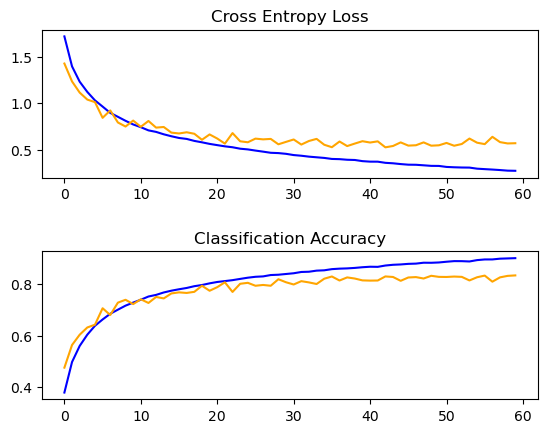









#######   Training with symmetric noise level: 0.3 ########
6  1562
Epoch 1/60
1562/1562 - 66s - loss: 2.0993 - accuracy: 0.2598 - val_loss: 1.7129 - val_accuracy: 0.4000 - 66s/epoch - 42ms/step
Epoch 2/60
1562/1562 - 51s - loss: 1.9844 - accuracy: 0.3266 - val_loss: 1.5348 - val_accuracy: 0.5082 - 51s/epoch - 33ms/step
Epoch 3/60
1562/1562 - 46s - loss: 1.9262 - accuracy: 0.3641 - val_loss: 1.4316 - val_accuracy: 0.5606 - 46s/epoch - 29ms/step
Epoch 4/60
1562/1562 - 41s - loss: 1.8834 - accuracy: 0.3874 - val_loss: 1.3557 - val_accuracy: 0.5595 - 41s/epoch - 26ms/step
Epoch 5/60
1562/1562 - 42s - loss: 1.8499 - accuracy: 0.4088 - val_loss: 1.3192 - val_accuracy: 0.6124 - 42s/epoch - 27ms/step
Epoch 6/60
1562/1562 - 41s - loss: 1.8236 - accuracy: 0.4237 - val_loss: 1.2982 - val_accuracy: 0.6108 - 41s/epoch - 26ms/step
Epoch 7/60
1562/1562 - 46s - loss: 1.7970 - accuracy: 0.4387 - val_loss: 1.1791 - val_accuracy: 0.6375 - 46s/epoch - 30ms/step
Epoch 8/60
1562/1562 - 51s - loss: 

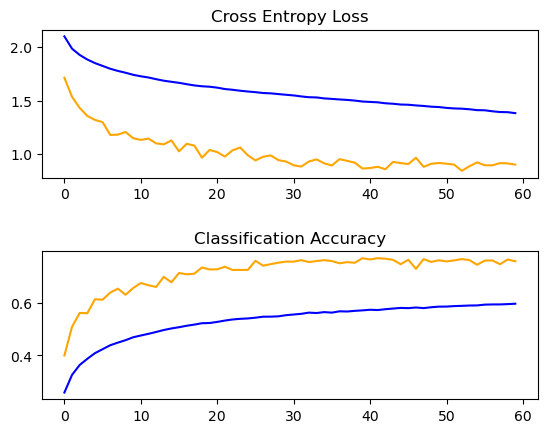









#######   Training with symmetric noise level: 0.5 ########
6  1562
Epoch 1/60
1562/1562 - 49s - loss: 2.2421 - accuracy: 0.1797 - val_loss: 1.9720 - val_accuracy: 0.3852 - 49s/epoch - 31ms/step
Epoch 2/60
1562/1562 - 47s - loss: 2.1923 - accuracy: 0.2225 - val_loss: 1.8532 - val_accuracy: 0.4143 - 47s/epoch - 30ms/step
Epoch 3/60
1562/1562 - 48s - loss: 2.1695 - accuracy: 0.2394 - val_loss: 1.8059 - val_accuracy: 0.4718 - 48s/epoch - 30ms/step
Epoch 4/60
1562/1562 - 52s - loss: 2.1537 - accuracy: 0.2551 - val_loss: 1.6894 - val_accuracy: 0.4952 - 52s/epoch - 33ms/step
Epoch 5/60
1562/1562 - 56s - loss: 2.1390 - accuracy: 0.2671 - val_loss: 1.6762 - val_accuracy: 0.5142 - 56s/epoch - 36ms/step
Epoch 6/60
1562/1562 - 51s - loss: 2.1276 - accuracy: 0.2752 - val_loss: 1.6546 - val_accuracy: 0.5175 - 51s/epoch - 33ms/step
Epoch 7/60
1562/1562 - 47s - loss: 2.1178 - accuracy: 0.2816 - val_loss: 1.6682 - val_accuracy: 0.5124 - 47s/epoch - 30ms/step
Epoch 8/60
1562/1562 - 48s - loss: 

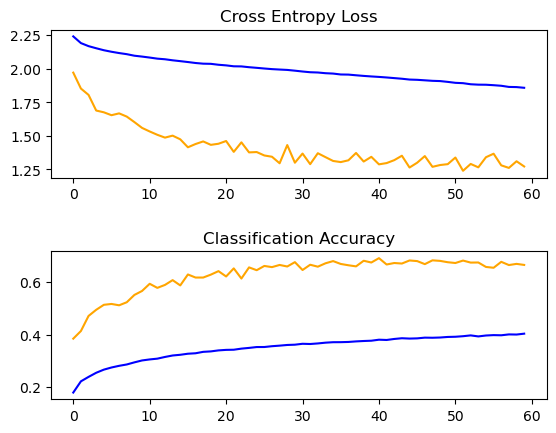









#######   Training with symmetric noise level: 0.8 ########
6  1562
Epoch 1/60
1562/1562 - 46s - loss: 2.3044 - accuracy: 0.1059 - val_loss: 2.2749 - val_accuracy: 0.1988 - 46s/epoch - 29ms/step
Epoch 2/60
1562/1562 - 50s - loss: 2.3005 - accuracy: 0.1114 - val_loss: 2.2590 - val_accuracy: 0.2202 - 50s/epoch - 32ms/step
Epoch 3/60
1562/1562 - 45s - loss: 2.2991 - accuracy: 0.1158 - val_loss: 2.2399 - val_accuracy: 0.2904 - 45s/epoch - 29ms/step
Epoch 4/60
1562/1562 - 40s - loss: 2.2982 - accuracy: 0.1221 - val_loss: 2.2202 - val_accuracy: 0.2920 - 40s/epoch - 26ms/step
Epoch 5/60
1562/1562 - 41s - loss: 2.2975 - accuracy: 0.1210 - val_loss: 2.2235 - val_accuracy: 0.3162 - 41s/epoch - 26ms/step
Epoch 6/60
1562/1562 - 40s - loss: 2.2967 - accuracy: 0.1238 - val_loss: 2.2086 - val_accuracy: 0.2938 - 40s/epoch - 26ms/step
Epoch 7/60
1562/1562 - 47s - loss: 2.2961 - accuracy: 0.1254 - val_loss: 2.1973 - val_accuracy: 0.3194 - 47s/epoch - 30ms/step
Epoch 8/60
1562/1562 - 50s - loss: 

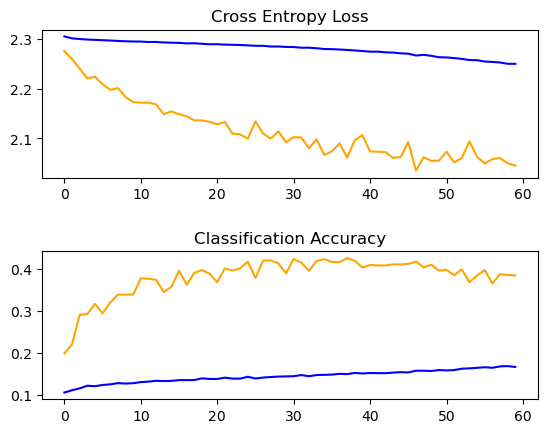









#######   Training with asymmetric noise level: 0.3 ########
6  1562
Epoch 1/60
1562/1562 - 48s - loss: 1.7531 - accuracy: 0.3637 - val_loss: 1.5238 - val_accuracy: 0.4348 - 48s/epoch - 30ms/step
Epoch 2/60
1562/1562 - 42s - loss: 1.4616 - accuracy: 0.4668 - val_loss: 1.3760 - val_accuracy: 0.4981 - 42s/epoch - 27ms/step
Epoch 3/60
1562/1562 - 42s - loss: 1.3169 - accuracy: 0.5172 - val_loss: 1.2288 - val_accuracy: 0.5515 - 42s/epoch - 27ms/step
Epoch 4/60
1562/1562 - 47s - loss: 1.2189 - accuracy: 0.5493 - val_loss: 1.1870 - val_accuracy: 0.5624 - 47s/epoch - 30ms/step
Epoch 5/60
1562/1562 - 51s - loss: 1.1472 - accuracy: 0.5727 - val_loss: 1.0786 - val_accuracy: 0.6121 - 51s/epoch - 33ms/step
Epoch 6/60
1562/1562 - 46s - loss: 1.0842 - accuracy: 0.5957 - val_loss: 1.0077 - val_accuracy: 0.6387 - 46s/epoch - 30ms/step
Epoch 7/60
1562/1562 - 42s - loss: 1.0400 - accuracy: 0.6086 - val_loss: 0.9953 - val_accuracy: 0.6526 - 42s/epoch - 27ms/step
Epoch 8/60
1562/1562 - 43s - loss:

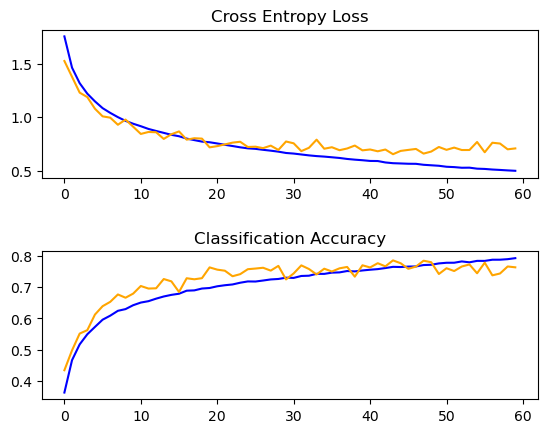









#######   Training with asymmetric noise level: 0.5 ########
6  1562
Epoch 1/60
1562/1562 - 53s - loss: 1.7067 - accuracy: 0.3855 - val_loss: 1.5987 - val_accuracy: 0.3962 - 53s/epoch - 34ms/step
Epoch 2/60
1562/1562 - 57s - loss: 1.4514 - accuracy: 0.4714 - val_loss: 1.5355 - val_accuracy: 0.4307 - 57s/epoch - 36ms/step
Epoch 3/60
1562/1562 - 51s - loss: 1.3175 - accuracy: 0.5118 - val_loss: 1.3333 - val_accuracy: 0.4750 - 51s/epoch - 33ms/step
Epoch 4/60
1562/1562 - 48s - loss: 1.2225 - accuracy: 0.5407 - val_loss: 1.2879 - val_accuracy: 0.5019 - 48s/epoch - 31ms/step
Epoch 5/60
1562/1562 - 48s - loss: 1.1606 - accuracy: 0.5564 - val_loss: 1.1543 - val_accuracy: 0.5408 - 48s/epoch - 31ms/step
Epoch 6/60
1562/1562 - 49s - loss: 1.1000 - accuracy: 0.5751 - val_loss: 1.1257 - val_accuracy: 0.5530 - 49s/epoch - 31ms/step
Epoch 7/60
1562/1562 - 54s - loss: 1.0543 - accuracy: 0.5853 - val_loss: 1.1698 - val_accuracy: 0.5416 - 54s/epoch - 34ms/step
Epoch 8/60
1562/1562 - 58s - loss:

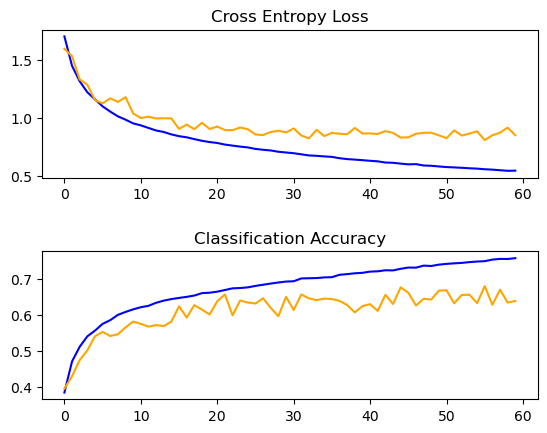









#######   Training with asymmetric noise level: 0.8 ########
6  1562
Epoch 1/60
1562/1562 - 49s - loss: 1.6048 - accuracy: 0.4261 - val_loss: 1.8372 - val_accuracy: 0.3797 - 49s/epoch - 31ms/step
Epoch 2/60
1562/1562 - 48s - loss: 1.3228 - accuracy: 0.5316 - val_loss: 1.7109 - val_accuracy: 0.4001 - 48s/epoch - 31ms/step
Epoch 3/60
1562/1562 - 49s - loss: 1.1935 - accuracy: 0.5801 - val_loss: 1.6866 - val_accuracy: 0.4227 - 49s/epoch - 32ms/step
Epoch 4/60
1562/1562 - 54s - loss: 1.1034 - accuracy: 0.6148 - val_loss: 1.5896 - val_accuracy: 0.4502 - 54s/epoch - 35ms/step
Epoch 5/60
1562/1562 - 55s - loss: 1.0461 - accuracy: 0.6337 - val_loss: 1.4484 - val_accuracy: 0.4355 - 55s/epoch - 35ms/step
Epoch 6/60
1562/1562 - 54s - loss: 0.9985 - accuracy: 0.6500 - val_loss: 1.4970 - val_accuracy: 0.4498 - 54s/epoch - 34ms/step
Epoch 7/60
1562/1562 - 49s - loss: 0.9544 - accuracy: 0.6633 - val_loss: 1.4458 - val_accuracy: 0.4574 - 49s/epoch - 31ms/step
Epoch 8/60
1562/1562 - 48s - loss:

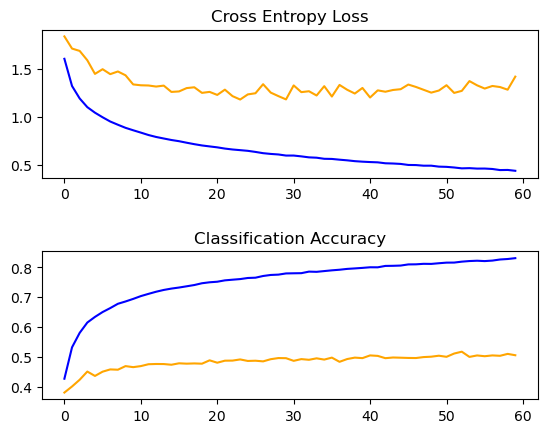









#######   Training model with dropout and data augmentation with 0 noise level: ########
6  1562
Epoch 1/60
1562/1562 - 54s - loss: 1.9197 - accuracy: 0.3393 - val_loss: 1.4232 - val_accuracy: 0.4812 - 54s/epoch - 35ms/step
Epoch 2/60
1562/1562 - 56s - loss: 1.5148 - accuracy: 0.4447 - val_loss: 1.3930 - val_accuracy: 0.4888 - 56s/epoch - 36ms/step
Epoch 3/60
1562/1562 - 54s - loss: 1.3999 - accuracy: 0.4916 - val_loss: 1.3095 - val_accuracy: 0.5239 - 54s/epoch - 34ms/step
Epoch 4/60
1562/1562 - 51s - loss: 1.3102 - accuracy: 0.5276 - val_loss: 1.3087 - val_accuracy: 0.5254 - 51s/epoch - 33ms/step
Epoch 5/60
1562/1562 - 51s - loss: 1.2397 - accuracy: 0.5530 - val_loss: 1.2100 - val_accuracy: 0.5651 - 51s/epoch - 32ms/step
Epoch 6/60
1562/1562 - 51s - loss: 1.1818 - accuracy: 0.5793 - val_loss: 1.1660 - val_accuracy: 0.5750 - 51s/epoch - 33ms/step
Epoch 7/60
1562/1562 - 53s - loss: 1.1323 - accuracy: 0.5961 - val_loss: 1.1194 - val_accuracy: 0.5992 - 53s/epoch - 34ms/step
Epoch 

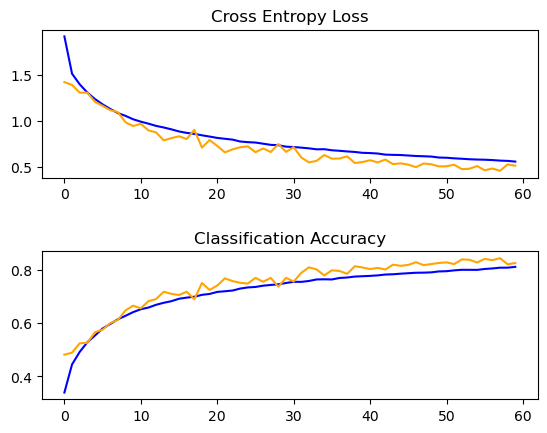









#######   Training with symmetric noise level: 0.3 ########
6  1562
Epoch 1/60
1562/1562 - 55s - loss: 2.3574 - accuracy: 0.2144 - val_loss: 1.7683 - val_accuracy: 0.4163 - 55s/epoch - 35ms/step
Epoch 2/60
1562/1562 - 48s - loss: 2.0563 - accuracy: 0.2823 - val_loss: 1.7361 - val_accuracy: 0.4003 - 48s/epoch - 31ms/step
Epoch 3/60
1562/1562 - 49s - loss: 2.0116 - accuracy: 0.3080 - val_loss: 1.6300 - val_accuracy: 0.4385 - 49s/epoch - 31ms/step
Epoch 4/60
1562/1562 - 51s - loss: 1.9877 - accuracy: 0.3261 - val_loss: 1.6157 - val_accuracy: 0.4390 - 51s/epoch - 33ms/step
Epoch 5/60
1562/1562 - 55s - loss: 1.9727 - accuracy: 0.3380 - val_loss: 1.5177 - val_accuracy: 0.4908 - 55s/epoch - 35ms/step
Epoch 6/60
1562/1562 - 51s - loss: 1.9535 - accuracy: 0.3489 - val_loss: 1.4990 - val_accuracy: 0.5017 - 51s/epoch - 33ms/step
Epoch 7/60
1562/1562 - 49s - loss: 1.9357 - accuracy: 0.3577 - val_loss: 1.4705 - val_accuracy: 0.5043 - 49s/epoch - 32ms/step
Epoch 8/60
1562/1562 - 50s - loss: 

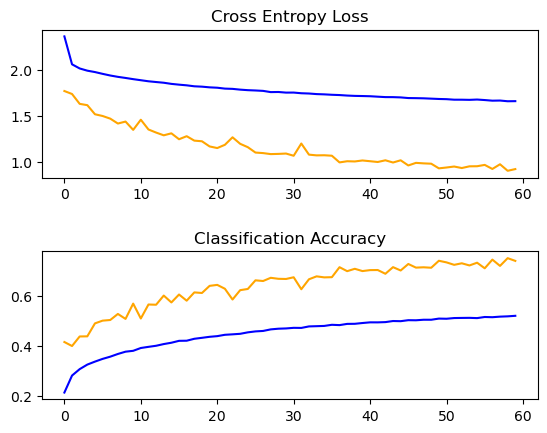









#######   Training with symmetric noise level: 0.5 ########
6  1562
Epoch 1/60
1562/1562 - 53s - loss: 2.4913 - accuracy: 0.1517 - val_loss: 1.9508 - val_accuracy: 0.3696 - 53s/epoch - 34ms/step
Epoch 2/60
1562/1562 - 54s - loss: 2.2246 - accuracy: 0.1982 - val_loss: 1.9148 - val_accuracy: 0.4264 - 54s/epoch - 34ms/step
Epoch 3/60
1562/1562 - 51s - loss: 2.2001 - accuracy: 0.2163 - val_loss: 1.8129 - val_accuracy: 0.4367 - 51s/epoch - 33ms/step
Epoch 4/60
1562/1562 - 49s - loss: 2.1889 - accuracy: 0.2253 - val_loss: 1.8307 - val_accuracy: 0.4428 - 49s/epoch - 31ms/step
Epoch 5/60
1562/1562 - 49s - loss: 2.1831 - accuracy: 0.2319 - val_loss: 1.8353 - val_accuracy: 0.3924 - 49s/epoch - 31ms/step
Epoch 6/60
1562/1562 - 49s - loss: 2.1728 - accuracy: 0.2412 - val_loss: 1.7768 - val_accuracy: 0.4267 - 49s/epoch - 32ms/step
Epoch 7/60
1562/1562 - 52s - loss: 2.1687 - accuracy: 0.2444 - val_loss: 1.7993 - val_accuracy: 0.4480 - 52s/epoch - 33ms/step
Epoch 8/60
1562/1562 - 55s - loss: 

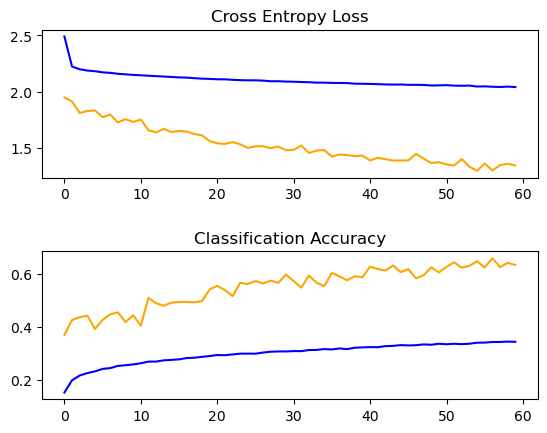









#######   Training with symmetric noise level: 0.8 ########
6  1562
Epoch 1/60
1562/1562 - 50s - loss: 2.5890 - accuracy: 0.1016 - val_loss: 2.2488 - val_accuracy: 0.1995 - 50s/epoch - 32ms/step
Epoch 2/60
1562/1562 - 49s - loss: 2.3214 - accuracy: 0.1059 - val_loss: 2.2696 - val_accuracy: 0.1757 - 49s/epoch - 31ms/step
Epoch 3/60
1562/1562 - 49s - loss: 2.3138 - accuracy: 0.1068 - val_loss: 2.2454 - val_accuracy: 0.2351 - 49s/epoch - 31ms/step
Epoch 4/60
1562/1562 - 52s - loss: 2.3143 - accuracy: 0.1057 - val_loss: 2.2448 - val_accuracy: 0.2165 - 52s/epoch - 33ms/step
Epoch 5/60
1562/1562 - 54s - loss: 2.3124 - accuracy: 0.1086 - val_loss: 2.2457 - val_accuracy: 0.2227 - 54s/epoch - 35ms/step
Epoch 6/60
1562/1562 - 52s - loss: 2.3117 - accuracy: 0.1099 - val_loss: 2.2511 - val_accuracy: 0.2355 - 52s/epoch - 33ms/step
Epoch 7/60
1562/1562 - 48s - loss: 2.3106 - accuracy: 0.1123 - val_loss: 2.2325 - val_accuracy: 0.2208 - 48s/epoch - 31ms/step
Epoch 8/60
1562/1562 - 49s - loss: 

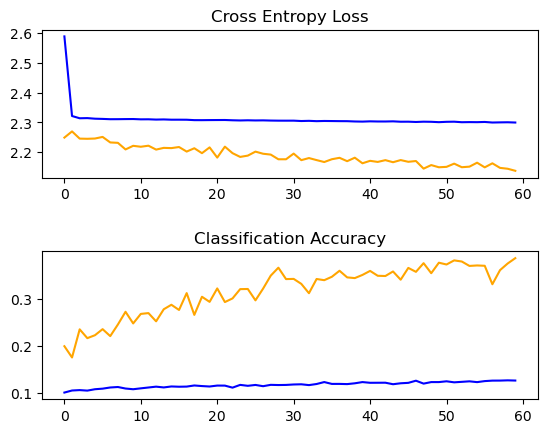









#######   Training with asymmetric noise level: 0.3 ########
6  1562
Epoch 1/60
1562/1562 - 53s - loss: 1.9923 - accuracy: 0.3180 - val_loss: 1.5553 - val_accuracy: 0.4215 - 53s/epoch - 34ms/step
Epoch 2/60
1562/1562 - 54s - loss: 1.5827 - accuracy: 0.4179 - val_loss: 1.4498 - val_accuracy: 0.4589 - 54s/epoch - 35ms/step
Epoch 3/60
1562/1562 - 52s - loss: 1.4760 - accuracy: 0.4564 - val_loss: 1.4656 - val_accuracy: 0.4788 - 52s/epoch - 33ms/step
Epoch 4/60
1562/1562 - 49s - loss: 1.3854 - accuracy: 0.4871 - val_loss: 1.4453 - val_accuracy: 0.4797 - 49s/epoch - 32ms/step
Epoch 5/60
1562/1562 - 49s - loss: 1.3260 - accuracy: 0.5083 - val_loss: 1.2566 - val_accuracy: 0.5432 - 49s/epoch - 31ms/step
Epoch 6/60
1562/1562 - 49s - loss: 1.2768 - accuracy: 0.5244 - val_loss: 1.2080 - val_accuracy: 0.5585 - 49s/epoch - 31ms/step
Epoch 7/60
1562/1562 - 54s - loss: 1.2369 - accuracy: 0.5344 - val_loss: 1.1790 - val_accuracy: 0.5741 - 54s/epoch - 34ms/step
Epoch 8/60
1562/1562 - 55s - loss:

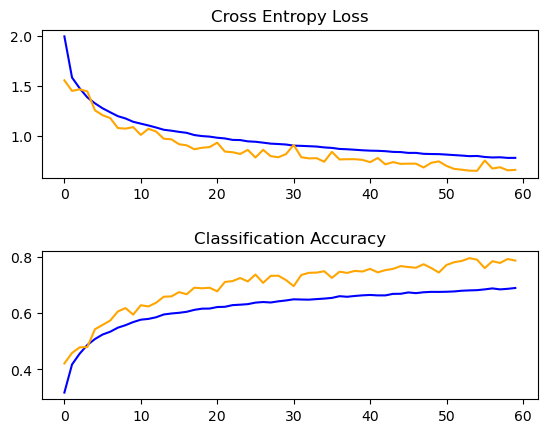









#######   Training with asymmetric noise level: 0.5 ########
6  1562
Epoch 1/60
1562/1562 - 55s - loss: 1.9548 - accuracy: 0.3407 - val_loss: 1.6298 - val_accuracy: 0.3884 - 55s/epoch - 35ms/step
Epoch 2/60
1562/1562 - 59s - loss: 1.5391 - accuracy: 0.4408 - val_loss: 1.4785 - val_accuracy: 0.4263 - 59s/epoch - 38ms/step
Epoch 3/60
1562/1562 - 51s - loss: 1.4258 - accuracy: 0.4792 - val_loss: 1.4573 - val_accuracy: 0.4313 - 51s/epoch - 33ms/step
Epoch 4/60
1562/1562 - 52s - loss: 1.3498 - accuracy: 0.5024 - val_loss: 1.4137 - val_accuracy: 0.4709 - 52s/epoch - 33ms/step
Epoch 5/60
1562/1562 - 55s - loss: 1.2994 - accuracy: 0.5188 - val_loss: 1.3316 - val_accuracy: 0.4711 - 55s/epoch - 35ms/step
Epoch 6/60
1562/1562 - 53s - loss: 1.2560 - accuracy: 0.5322 - val_loss: 1.3260 - val_accuracy: 0.4957 - 53s/epoch - 34ms/step
Epoch 7/60
1562/1562 - 51s - loss: 1.2255 - accuracy: 0.5430 - val_loss: 1.1903 - val_accuracy: 0.5367 - 51s/epoch - 32ms/step
Epoch 8/60
1562/1562 - 51s - loss:

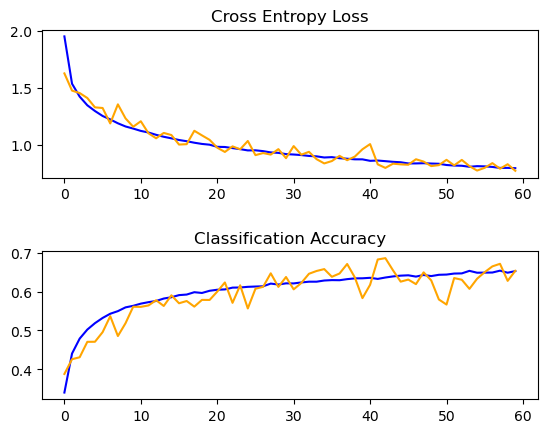









#######   Training with asymmetric noise level: 0.8 ########
6  1562
Epoch 1/60
1562/1562 - 54s - loss: 1.8549 - accuracy: 0.3794 - val_loss: 1.7943 - val_accuracy: 0.3756 - 54s/epoch - 35ms/step
Epoch 2/60
1562/1562 - 55s - loss: 1.4459 - accuracy: 0.4889 - val_loss: 1.7915 - val_accuracy: 0.3861 - 55s/epoch - 35ms/step
Epoch 3/60
1562/1562 - 52s - loss: 1.3439 - accuracy: 0.5265 - val_loss: 1.6966 - val_accuracy: 0.4143 - 52s/epoch - 33ms/step
Epoch 4/60
1562/1562 - 51s - loss: 1.2646 - accuracy: 0.5565 - val_loss: 1.7356 - val_accuracy: 0.3925 - 51s/epoch - 33ms/step
Epoch 5/60
1562/1562 - 50s - loss: 1.2100 - accuracy: 0.5729 - val_loss: 1.5803 - val_accuracy: 0.4386 - 50s/epoch - 32ms/step
Epoch 6/60
1562/1562 - 50s - loss: 1.1674 - accuracy: 0.5902 - val_loss: 1.5072 - val_accuracy: 0.4479 - 50s/epoch - 32ms/step
Epoch 7/60
1562/1562 - 53s - loss: 1.1377 - accuracy: 0.6034 - val_loss: 1.6244 - val_accuracy: 0.4366 - 53s/epoch - 34ms/step
Epoch 8/60
1562/1562 - 56s - loss:

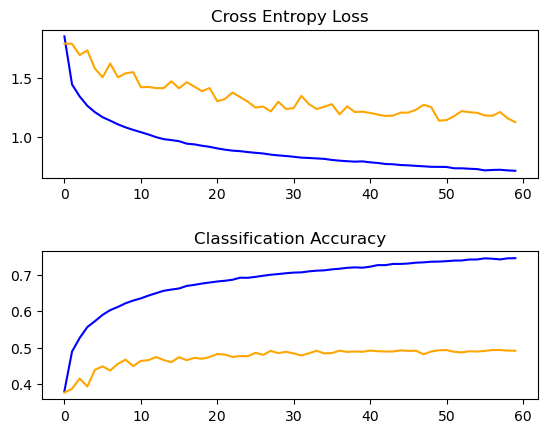

In [12]:
# baseline model with data augmentation on the cifar10 dataset
# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

import sys
from matplotlib import pyplot
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
 
# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = cifar10.load_data()
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY
 
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm
 
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    
    # Adjust the spacing between the two plots
    pyplot.subplots_adjust(hspace=0.5)  # Adjust the vertical spacing

    pyplot.show()
    pyplot.close()
    
import numpy as np
import random
from keras.utils import to_categorical

def apply_noise_to_labels(labels, noise_level, noise_type='symmetric'):
    noisy_labels = labels.copy()
    n_classes = 10  # CIFAR-10 has 10 classes
    label_mapping = {9: 1, 2: 0, 4: 7, 3: 5, 5: 3}  # Asymmetric mapping

    for i in range(len(noisy_labels)):
        if random.random() < noise_level:
            if noise_type == 'symmetric':
                # Create a list of possible labels excluding the original one
                possible_labels = list(range(n_classes))
                possible_labels.remove(noisy_labels[i])
                noisy_labels[i] = random.choice(possible_labels)
            elif noise_type == 'asymmetric':
                # Only apply noise to labels that are in the asymmetric mapping
                if noisy_labels[i] in label_mapping:
                    noisy_labels[i] = label_mapping[noisy_labels[i]]
    return to_categorical(noisy_labels, num_classes=n_classes)

    
def run_test_harness(noise_level=0.0, noise_type='symmetric'):
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    
    # apply noise to labels
    trainY_noisy = apply_noise_to_labels(np.argmax(trainY, axis=1), noise_level, noise_type)
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # define model
    model = define_model()
    # create data generator
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
    # prepare iterator
    it_train = datagen.flow(trainX, trainY_noisy, batch_size=32)
    # fit model
    steps = int(trainX.shape[0] / 32)
    print ("6 ", steps)
    history = model.fit(it_train, steps_per_epoch=steps, epochs=60, validation_data=(testX, testY), verbose=2)    
    print ("7\n") 
    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=2)
    print(f'Noise Level {noise_level} - Noise Type {noise_type} - Accuracy: {acc * 100.0}%')
    summarize_diagnostics(history)
    print ("\n\n\n") 

print(f"#######   Training model with data augmentation with 0 noise level: ########")
run_test_harness(0, 'symmetric') 
print ("\n\n\n")
noise_levels = [0.1, 0.3, 0.5, 0.8, 0.9]
noise_levels = [0.3, 0.5, 0.8]
noise_types = ['symmetric', 'asymmetric']

for noise_type in noise_types:
    for noise_level in noise_levels:
        print(f"#######   Training with {noise_type} noise level: {noise_level} ########")
        run_test_harness(noise_level, noise_type)
        print ("\n\n\n")
        
        



#######   Training model with data augmentation with 0 noise level: ########
6  1562
Epoch 1/60
1562/1562 - 47s - loss: 1.7154 - accuracy: 0.3782 - val_loss: 1.4247 - val_accuracy: 0.4752 - 47s/epoch - 30ms/step
Epoch 2/60
1562/1562 - 42s - loss: 1.3943 - accuracy: 0.4971 - val_loss: 1.2330 - val_accuracy: 0.5634 - 42s/epoch - 27ms/step
Epoch 3/60
1562/1562 - 42s - loss: 1.2303 - accuracy: 0.5598 - val_loss: 1.1135 - val_accuracy: 0.6035 - 42s/epoch - 27ms/step
Epoch 4/60
1562/1562 - 48s - loss: 1.1206 - accuracy: 0.6037 - val_loss: 1.0385 - val_accuracy: 0.6317 - 48s/epoch - 31ms/step
Epoch 5/60
1562/1562 - 53s - loss: 1.0302 - accuracy: 0.6383 - val_loss: 1.0114 - val_accuracy: 0.6425 - 53s/epoch - 34ms/step
Epoch 6/60
1562/1562 - 48s - loss: 0.9637 - accuracy: 0.6628 - val_loss: 0.8432 - val_accuracy: 0.7066 - 48s/epoch - 31ms/step
Epoch 7/60
1562/1562 - 42s - loss: 0.8962 - accuracy: 0.6851 - val_loss: 0.9227 - val_accuracy: 0.6803 - 42s/epoch - 27ms/step
Epoch 8/60
1562/1562 - 42s - loss: 0.8542 - accuracy: 0.7010 - val_loss: 0.7934 - val_accuracy: 0.7284 - 42s/epoch - 27ms/step
Epoch 9/60
1562/1562 - 43s - loss: 0.8114 - accuracy: 0.7167 - val_loss: 0.7500 - val_accuracy: 0.7396 - 43s/epoch - 28ms/step
Epoch 10/60
1562/1562 - 48s - loss: 0.7723 - accuracy: 0.7286 - val_loss: 0.8138 - val_accuracy: 0.7228 - 48s/epoch - 31ms/step
Epoch 11/60
1562/1562 - 52s - loss: 0.7429 - accuracy: 0.7397 - val_loss: 0.7472 - val_accuracy: 0.7415 - 52s/epoch - 33ms/step
Epoch 12/60
1562/1562 - 47s - loss: 0.7088 - accuracy: 0.7523 - val_loss: 0.8095 - val_accuracy: 0.7272 - 47s/epoch - 30ms/step
Epoch 13/60
1562/1562 - 44s - loss: 0.6925 - accuracy: 0.7586 - val_loss: 0.7384 - val_accuracy: 0.7505 - 44s/epoch - 28ms/step
Epoch 14/60
1562/1562 - 43s - loss: 0.6667 - accuracy: 0.7681 - val_loss: 0.7450 - val_accuracy: 0.7449 - 43s/epoch - 27ms/step
Epoch 15/60
1562/1562 - 43s - loss: 0.6458 - accuracy: 0.7750 - val_loss: 0.6848 - val_accuracy: 0.7643 - 43s/epoch - 28ms/step
Epoch 16/60
1562/1562 - 50s - loss: 0.6274 - accuracy: 0.7805 - val_loss: 0.6757 - val_accuracy: 0.7684 - 50s/epoch - 32ms/step
Epoch 17/60
1562/1562 - 54s - loss: 0.6173 - accuracy: 0.7856 - val_loss: 0.6885 - val_accuracy: 0.7662 - 54s/epoch - 35ms/step
Epoch 18/60
1562/1562 - 47s - loss: 0.5961 - accuracy: 0.7925 - val_loss: 0.6725 - val_accuracy: 0.7705 - 47s/epoch - 30ms/step
Epoch 19/60
1562/1562 - 42s - loss: 0.5809 - accuracy: 0.7971 - val_loss: 0.6081 - val_accuracy: 0.7942 - 42s/epoch - 27ms/step
Epoch 20/60
1562/1562 - 43s - loss: 0.5641 - accuracy: 0.8036 - val_loss: 0.6654 - val_accuracy: 0.7747 - 43s/epoch - 27ms/step
Epoch 21/60
1562/1562 - 43s - loss: 0.5507 - accuracy: 0.8089 - val_loss: 0.6214 - val_accuracy: 0.7887 - 43s/epoch - 27ms/step
Epoch 22/60
1562/1562 - 47s - loss: 0.5379 - accuracy: 0.8124 - val_loss: 0.5672 - val_accuracy: 0.8077 - 47s/epoch - 30ms/step
Epoch 23/60
1562/1562 - 52s - loss: 0.5280 - accuracy: 0.8160 - val_loss: 0.6798 - val_accuracy: 0.7701 - 52s/epoch - 33ms/step
Epoch 24/60
1562/1562 - 49s - loss: 0.5125 - accuracy: 0.8209 - val_loss: 0.5918 - val_accuracy: 0.8019 - 49s/epoch - 31ms/step
Epoch 25/60
1562/1562 - 42s - loss: 0.5050 - accuracy: 0.8256 - val_loss: 0.5814 - val_accuracy: 0.8056 - 42s/epoch - 27ms/step
Epoch 26/60
1562/1562 - 43s - loss: 0.4925 - accuracy: 0.8291 - val_loss: 0.6205 - val_accuracy: 0.7942 - 43s/epoch - 28ms/step
Epoch 27/60
1562/1562 - 44s - loss: 0.4810 - accuracy: 0.8306 - val_loss: 0.6126 - val_accuracy: 0.7973 - 44s/epoch - 28ms/step
Epoch 28/60
1562/1562 - 48s - loss: 0.4688 - accuracy: 0.8359 - val_loss: 0.6174 - val_accuracy: 0.7942 - 48s/epoch - 31ms/step
Epoch 29/60
1562/1562 - 52s - loss: 0.4656 - accuracy: 0.8372 - val_loss: 0.5597 - val_accuracy: 0.8196 - 52s/epoch - 33ms/step
Epoch 30/60
1562/1562 - 49s - loss: 0.4576 - accuracy: 0.8400 - val_loss: 0.5857 - val_accuracy: 0.8078 - 49s/epoch - 31ms/step
Epoch 31/60
1562/1562 - 42s - loss: 0.4444 - accuracy: 0.8429 - val_loss: 0.6114 - val_accuracy: 0.7991 - 42s/epoch - 27ms/step
Epoch 32/60
1562/1562 - 43s - loss: 0.4372 - accuracy: 0.8478 - val_loss: 0.5568 - val_accuracy: 0.8121 - 43s/epoch - 28ms/step
Epoch 33/60
1562/1562 - 44s - loss: 0.4274 - accuracy: 0.8488 - val_loss: 0.5952 - val_accuracy: 0.8072 - 44s/epoch - 28ms/step
Epoch 34/60
1562/1562 - 48s - loss: 0.4206 - accuracy: 0.8531 - val_loss: 0.6177 - val_accuracy: 0.8010 - 48s/epoch - 31ms/step
Epoch 35/60
1562/1562 - 52s - loss: 0.4138 - accuracy: 0.8543 - val_loss: 0.5549 - val_accuracy: 0.8216 - 52s/epoch - 33ms/step
Epoch 36/60
1562/1562 - 53s - loss: 0.4028 - accuracy: 0.8589 - val_loss: 0.5286 - val_accuracy: 0.8303 - 53s/epoch - 34ms/step
Epoch 37/60
1562/1562 - 44s - loss: 0.4006 - accuracy: 0.8608 - val_loss: 0.5896 - val_accuracy: 0.8146 - 44s/epoch - 28ms/step
Epoch 38/60
1562/1562 - 44s - loss: 0.3942 - accuracy: 0.8618 - val_loss: 0.5407 - val_accuracy: 0.8267 - 44s/epoch - 28ms/step
Epoch 39/60
1562/1562 - 43s - loss: 0.3916 - accuracy: 0.8637 - val_loss: 0.5675 - val_accuracy: 0.8223 - 43s/epoch - 27ms/step
Epoch 40/60
1562/1562 - 49s - loss: 0.3794 - accuracy: 0.8664 - val_loss: 0.5929 - val_accuracy: 0.8151 - 49s/epoch - 31ms/step
Epoch 41/60
1562/1562 - 53s - loss: 0.3739 - accuracy: 0.8683 - val_loss: 0.5786 - val_accuracy: 0.8142 - 53s/epoch - 34ms/step
Epoch 42/60
1562/1562 - 48s - loss: 0.3736 - accuracy: 0.8678 - val_loss: 0.5913 - val_accuracy: 0.8146 - 48s/epoch - 30ms/step
Epoch 43/60
1562/1562 - 43s - loss: 0.3613 - accuracy: 0.8730 - val_loss: 0.5272 - val_accuracy: 0.8305 - 43s/epoch - 28ms/step
Epoch 44/60
1562/1562 - 43s - loss: 0.3562 - accuracy: 0.8758 - val_loss: 0.5416 - val_accuracy: 0.8284 - 43s/epoch - 27ms/step
Epoch 45/60
1562/1562 - 44s - loss: 0.3478 - accuracy: 0.8772 - val_loss: 0.5801 - val_accuracy: 0.8134 - 44s/epoch - 28ms/step
Epoch 46/60
1562/1562 - 48s - loss: 0.3414 - accuracy: 0.8795 - val_loss: 0.5457 - val_accuracy: 0.8264 - 48s/epoch - 31ms/step
Epoch 47/60
1562/1562 - 49s - loss: 0.3404 - accuracy: 0.8804 - val_loss: 0.5495 - val_accuracy: 0.8279 - 49s/epoch - 31ms/step
Epoch 48/60
1562/1562 - 48s - loss: 0.3347 - accuracy: 0.8839 - val_loss: 0.5802 - val_accuracy: 0.8224 - 48s/epoch - 31ms/step
Epoch 49/60
1562/1562 - 43s - loss: 0.3287 - accuracy: 0.8837 - val_loss: 0.5449 - val_accuracy: 0.8330 - 43s/epoch - 27ms/step
Epoch 50/60
1562/1562 - 44s - loss: 0.3280 - accuracy: 0.8849 - val_loss: 0.5489 - val_accuracy: 0.8288 - 44s/epoch - 28ms/step
Epoch 51/60
1562/1562 - 44s - loss: 0.3172 - accuracy: 0.8877 - val_loss: 0.5743 - val_accuracy: 0.8284 - 44s/epoch - 28ms/step
Epoch 52/60
1562/1562 - 47s - loss: 0.3135 - accuracy: 0.8901 - val_loss: 0.5442 - val_accuracy: 0.8300 - 47s/epoch - 30ms/step
Epoch 53/60
1562/1562 - 44s - loss: 0.3111 - accuracy: 0.8900 - val_loss: 0.5629 - val_accuracy: 0.8288 - 44s/epoch - 28ms/step
Epoch 54/60
1562/1562 - 47s - loss: 0.3102 - accuracy: 0.8888 - val_loss: 0.6213 - val_accuracy: 0.8149 - 47s/epoch - 30ms/step
Epoch 55/60
1562/1562 - 45s - loss: 0.2986 - accuracy: 0.8941 - val_loss: 0.5769 - val_accuracy: 0.8273 - 45s/epoch - 29ms/step
Epoch 56/60
1562/1562 - 56s - loss: 0.2938 - accuracy: 0.8966 - val_loss: 0.5616 - val_accuracy: 0.8338 - 56s/epoch - 36ms/step
Epoch 57/60
1562/1562 - 49s - loss: 0.2891 - accuracy: 0.8967 - val_loss: 0.6399 - val_accuracy: 0.8101 - 49s/epoch - 31ms/step
Epoch 58/60
1562/1562 - 59s - loss: 0.2839 - accuracy: 0.8997 - val_loss: 0.5830 - val_accuracy: 0.8269 - 59s/epoch - 38ms/step
Epoch 59/60
1562/1562 - 54s - loss: 0.2775 - accuracy: 0.9006 - val_loss: 0.5688 - val_accuracy: 0.8327 - 54s/epoch - 35ms/step
Epoch 60/60
1562/1562 - 51s - loss: 0.2759 - accuracy: 0.9017 - val_loss: 0.5712 - val_accuracy: 0.8345 - 51s/epoch - 33ms/step
7

313/313 - 3s - loss: 0.5712 - accuracy: 0.8345 - 3s/epoch - 9ms/step
Noise Level 0 - Noise Type symmetric - Accuracy: 83.45000147819519%









#######   Training with symmetric noise level: 0.3 ########
6  1562
Epoch 1/60
1562/1562 - 66s - loss: 2.0993 - accuracy: 0.2598 - val_loss: 1.7129 - val_accuracy: 0.4000 - 66s/epoch - 42ms/step
Epoch 2/60
1562/1562 - 51s - loss: 1.9844 - accuracy: 0.3266 - val_loss: 1.5348 - val_accuracy: 0.5082 - 51s/epoch - 33ms/step
Epoch 3/60
1562/1562 - 46s - loss: 1.9262 - accuracy: 0.3641 - val_loss: 1.4316 - val_accuracy: 0.5606 - 46s/epoch - 29ms/step
Epoch 4/60
1562/1562 - 41s - loss: 1.8834 - accuracy: 0.3874 - val_loss: 1.3557 - val_accuracy: 0.5595 - 41s/epoch - 26ms/step
Epoch 5/60
1562/1562 - 42s - loss: 1.8499 - accuracy: 0.4088 - val_loss: 1.3192 - val_accuracy: 0.6124 - 42s/epoch - 27ms/step
Epoch 6/60
1562/1562 - 41s - loss: 1.8236 - accuracy: 0.4237 - val_loss: 1.2982 - val_accuracy: 0.6108 - 41s/epoch - 26ms/step
Epoch 7/60
1562/1562 - 46s - loss: 1.7970 - accuracy: 0.4387 - val_loss: 1.1791 - val_accuracy: 0.6375 - 46s/epoch - 30ms/step
Epoch 8/60
1562/1562 - 51s - loss: 1.7768 - accuracy: 0.4486 - val_loss: 1.1813 - val_accuracy: 0.6525 - 51s/epoch - 33ms/step
Epoch 9/60
1562/1562 - 46s - loss: 1.7598 - accuracy: 0.4577 - val_loss: 1.2069 - val_accuracy: 0.6295 - 46s/epoch - 29ms/step
Epoch 10/60
1562/1562 - 42s - loss: 1.7407 - accuracy: 0.4688 - val_loss: 1.1478 - val_accuracy: 0.6548 - 42s/epoch - 27ms/step
Epoch 11/60
1562/1562 - 45s - loss: 1.7265 - accuracy: 0.4754 - val_loss: 1.1325 - val_accuracy: 0.6738 - 45s/epoch - 29ms/step
Epoch 12/60
1562/1562 - 41s - loss: 1.7155 - accuracy: 0.4818 - val_loss: 1.1444 - val_accuracy: 0.6653 - 41s/epoch - 26ms/step
Epoch 13/60
1562/1562 - 46s - loss: 1.6996 - accuracy: 0.4888 - val_loss: 1.1002 - val_accuracy: 0.6589 - 46s/epoch - 30ms/step
Epoch 14/60
1562/1562 - 50s - loss: 1.6855 - accuracy: 0.4962 - val_loss: 1.0909 - val_accuracy: 0.6971 - 50s/epoch - 32ms/step
Epoch 15/60
1562/1562 - 46s - loss: 1.6752 - accuracy: 0.5021 - val_loss: 1.1278 - val_accuracy: 0.6763 - 46s/epoch - 29ms/step
Epoch 16/60
1562/1562 - 41s - loss: 1.6656 - accuracy: 0.5068 - val_loss: 1.0253 - val_accuracy: 0.7117 - 41s/epoch - 26ms/step
Epoch 17/60
1562/1562 - 41s - loss: 1.6529 - accuracy: 0.5123 - val_loss: 1.0958 - val_accuracy: 0.7067 - 41s/epoch - 26ms/step
Epoch 18/60
1562/1562 - 41s - loss: 1.6412 - accuracy: 0.5166 - val_loss: 1.0797 - val_accuracy: 0.7089 - 41s/epoch - 26ms/step
Epoch 19/60
1562/1562 - 46s - loss: 1.6335 - accuracy: 0.5219 - val_loss: 0.9661 - val_accuracy: 0.7325 - 46s/epoch - 29ms/step
Epoch 20/60
1562/1562 - 49s - loss: 1.6292 - accuracy: 0.5226 - val_loss: 1.0386 - val_accuracy: 0.7250 - 49s/epoch - 32ms/step
Epoch 21/60
1562/1562 - 46s - loss: 1.6205 - accuracy: 0.5269 - val_loss: 1.0184 - val_accuracy: 0.7256 - 46s/epoch - 29ms/step
Epoch 22/60
1562/1562 - 40s - loss: 1.6075 - accuracy: 0.5318 - val_loss: 0.9766 - val_accuracy: 0.7352 - 40s/epoch - 26ms/step
Epoch 23/60
1562/1562 - 41s - loss: 1.6007 - accuracy: 0.5360 - val_loss: 1.0349 - val_accuracy: 0.7232 - 41s/epoch - 26ms/step
Epoch 24/60
1562/1562 - 41s - loss: 1.5918 - accuracy: 0.5384 - val_loss: 1.0610 - val_accuracy: 0.7233 - 41s/epoch - 26ms/step
Epoch 25/60
1562/1562 - 45s - loss: 1.5845 - accuracy: 0.5399 - val_loss: 0.9891 - val_accuracy: 0.7233 - 45s/epoch - 29ms/step
Epoch 26/60
1562/1562 - 51s - loss: 1.5784 - accuracy: 0.5427 - val_loss: 0.9405 - val_accuracy: 0.7577 - 51s/epoch - 32ms/step
Epoch 27/60
1562/1562 - 46s - loss: 1.5704 - accuracy: 0.5465 - val_loss: 0.9750 - val_accuracy: 0.7392 - 46s/epoch - 30ms/step
Epoch 28/60
1562/1562 - 43s - loss: 1.5673 - accuracy: 0.5467 - val_loss: 0.9875 - val_accuracy: 0.7451 - 43s/epoch - 27ms/step
Epoch 29/60
1562/1562 - 44s - loss: 1.5603 - accuracy: 0.5479 - val_loss: 0.9435 - val_accuracy: 0.7505 - 44s/epoch - 28ms/step
Epoch 30/60
1562/1562 - 42s - loss: 1.5540 - accuracy: 0.5522 - val_loss: 0.9303 - val_accuracy: 0.7547 - 42s/epoch - 27ms/step
Epoch 31/60
1562/1562 - 46s - loss: 1.5479 - accuracy: 0.5548 - val_loss: 0.8954 - val_accuracy: 0.7545 - 46s/epoch - 29ms/step
Epoch 32/60
1562/1562 - 51s - loss: 1.5385 - accuracy: 0.5574 - val_loss: 0.8832 - val_accuracy: 0.7602 - 51s/epoch - 33ms/step
Epoch 33/60
1562/1562 - 46s - loss: 1.5311 - accuracy: 0.5619 - val_loss: 0.9309 - val_accuracy: 0.7529 - 46s/epoch - 30ms/step
Epoch 34/60
1562/1562 - 42s - loss: 1.5292 - accuracy: 0.5604 - val_loss: 0.9502 - val_accuracy: 0.7568 - 42s/epoch - 27ms/step
Epoch 35/60
1562/1562 - 42s - loss: 1.5199 - accuracy: 0.5638 - val_loss: 0.9132 - val_accuracy: 0.7602 - 42s/epoch - 27ms/step
Epoch 36/60
1562/1562 - 42s - loss: 1.5154 - accuracy: 0.5619 - val_loss: 0.8938 - val_accuracy: 0.7567 - 42s/epoch - 27ms/step
Epoch 37/60
1562/1562 - 46s - loss: 1.5103 - accuracy: 0.5669 - val_loss: 0.9526 - val_accuracy: 0.7483 - 46s/epoch - 29ms/step
Epoch 38/60
1562/1562 - 50s - loss: 1.5059 - accuracy: 0.5661 - val_loss: 0.9365 - val_accuracy: 0.7527 - 50s/epoch - 32ms/step
Epoch 39/60
1562/1562 - 45s - loss: 1.4997 - accuracy: 0.5686 - val_loss: 0.9196 - val_accuracy: 0.7502 - 45s/epoch - 29ms/step
Epoch 40/60
1562/1562 - 41s - loss: 1.4909 - accuracy: 0.5704 - val_loss: 0.8650 - val_accuracy: 0.7674 - 41s/epoch - 26ms/step
Epoch 41/60
1562/1562 - 41s - loss: 1.4872 - accuracy: 0.5727 - val_loss: 0.8697 - val_accuracy: 0.7628 - 41s/epoch - 26ms/step
Epoch 42/60
1562/1562 - 42s - loss: 1.4834 - accuracy: 0.5716 - val_loss: 0.8812 - val_accuracy: 0.7677 - 42s/epoch - 27ms/step
Epoch 43/60
1562/1562 - 46s - loss: 1.4745 - accuracy: 0.5748 - val_loss: 0.8582 - val_accuracy: 0.7656 - 46s/epoch - 29ms/step
Epoch 44/60
1562/1562 - 50s - loss: 1.4701 - accuracy: 0.5773 - val_loss: 0.9268 - val_accuracy: 0.7613 - 50s/epoch - 32ms/step
Epoch 45/60
1562/1562 - 46s - loss: 1.4630 - accuracy: 0.5797 - val_loss: 0.9159 - val_accuracy: 0.7447 - 46s/epoch - 30ms/step
Epoch 46/60
1562/1562 - 41s - loss: 1.4608 - accuracy: 0.5788 - val_loss: 0.9067 - val_accuracy: 0.7616 - 41s/epoch - 26ms/step
Epoch 47/60
1562/1562 - 43s - loss: 1.4544 - accuracy: 0.5813 - val_loss: 0.9659 - val_accuracy: 0.7273 - 43s/epoch - 27ms/step
Epoch 48/60
1562/1562 - 41s - loss: 1.4495 - accuracy: 0.5789 - val_loss: 0.8808 - val_accuracy: 0.7640 - 41s/epoch - 26ms/step
Epoch 49/60
1562/1562 - 46s - loss: 1.4427 - accuracy: 0.5823 - val_loss: 0.9093 - val_accuracy: 0.7535 - 46s/epoch - 29ms/step
Epoch 50/60
1562/1562 - 50s - loss: 1.4393 - accuracy: 0.5845 - val_loss: 0.9167 - val_accuracy: 0.7597 - 50s/epoch - 32ms/step
Epoch 51/60
1562/1562 - 46s - loss: 1.4313 - accuracy: 0.5847 - val_loss: 0.9100 - val_accuracy: 0.7553 - 46s/epoch - 29ms/step
Epoch 52/60
1562/1562 - 42s - loss: 1.4263 - accuracy: 0.5866 - val_loss: 0.9015 - val_accuracy: 0.7592 - 42s/epoch - 27ms/step
Epoch 53/60
1562/1562 - 42s - loss: 1.4241 - accuracy: 0.5875 - val_loss: 0.8437 - val_accuracy: 0.7642 - 42s/epoch - 27ms/step
Epoch 54/60
1562/1562 - 46s - loss: 1.4186 - accuracy: 0.5887 - val_loss: 0.8862 - val_accuracy: 0.7602 - 46s/epoch - 30ms/step
Epoch 55/60
1562/1562 - 47s - loss: 1.4105 - accuracy: 0.5891 - val_loss: 0.9225 - val_accuracy: 0.7427 - 47s/epoch - 30ms/step
Epoch 56/60
1562/1562 - 50s - loss: 1.4091 - accuracy: 0.5921 - val_loss: 0.8957 - val_accuracy: 0.7584 - 50s/epoch - 32ms/step
Epoch 57/60
1562/1562 - 46s - loss: 1.3998 - accuracy: 0.5928 - val_loss: 0.8947 - val_accuracy: 0.7591 - 46s/epoch - 30ms/step
Epoch 58/60
1562/1562 - 40s - loss: 1.3927 - accuracy: 0.5928 - val_loss: 0.9156 - val_accuracy: 0.7447 - 40s/epoch - 26ms/step
Epoch 59/60
1562/1562 - 41s - loss: 1.3914 - accuracy: 0.5940 - val_loss: 0.9127 - val_accuracy: 0.7626 - 41s/epoch - 26ms/step
Epoch 60/60
1562/1562 - 41s - loss: 1.3823 - accuracy: 0.5955 - val_loss: 0.9017 - val_accuracy: 0.7561 - 41s/epoch - 26ms/step
7

313/313 - 3s - loss: 0.9017 - accuracy: 0.7561 - 3s/epoch - 8ms/step
Noise Level 0.3 - Noise Type symmetric - Accuracy: 75.60999989509583%









#######   Training with symmetric noise level: 0.5 ########
6  1562
Epoch 1/60
1562/1562 - 49s - loss: 2.2421 - accuracy: 0.1797 - val_loss: 1.9720 - val_accuracy: 0.3852 - 49s/epoch - 31ms/step
Epoch 2/60
1562/1562 - 47s - loss: 2.1923 - accuracy: 0.2225 - val_loss: 1.8532 - val_accuracy: 0.4143 - 47s/epoch - 30ms/step
Epoch 3/60
1562/1562 - 48s - loss: 2.1695 - accuracy: 0.2394 - val_loss: 1.8059 - val_accuracy: 0.4718 - 48s/epoch - 30ms/step
Epoch 4/60
1562/1562 - 52s - loss: 2.1537 - accuracy: 0.2551 - val_loss: 1.6894 - val_accuracy: 0.4952 - 52s/epoch - 33ms/step
Epoch 5/60
1562/1562 - 56s - loss: 2.1390 - accuracy: 0.2671 - val_loss: 1.6762 - val_accuracy: 0.5142 - 56s/epoch - 36ms/step
Epoch 6/60
1562/1562 - 51s - loss: 2.1276 - accuracy: 0.2752 - val_loss: 1.6546 - val_accuracy: 0.5175 - 51s/epoch - 33ms/step
Epoch 7/60
1562/1562 - 47s - loss: 2.1178 - accuracy: 0.2816 - val_loss: 1.6682 - val_accuracy: 0.5124 - 47s/epoch - 30ms/step
Epoch 8/60
1562/1562 - 48s - loss: 2.1096 - accuracy: 0.2867 - val_loss: 1.6442 - val_accuracy: 0.5240 - 48s/epoch - 31ms/step
Epoch 9/60
1562/1562 - 46s - loss: 2.0981 - accuracy: 0.2948 - val_loss: 1.6031 - val_accuracy: 0.5519 - 46s/epoch - 30ms/step
Epoch 10/60
1562/1562 - 47s - loss: 2.0916 - accuracy: 0.3021 - val_loss: 1.5600 - val_accuracy: 0.5670 - 47s/epoch - 30ms/step
Epoch 11/60
1562/1562 - 57s - loss: 2.0843 - accuracy: 0.3060 - val_loss: 1.5333 - val_accuracy: 0.5944 - 57s/epoch - 37ms/step
Epoch 12/60
1562/1562 - 56s - loss: 2.0762 - accuracy: 0.3089 - val_loss: 1.5085 - val_accuracy: 0.5788 - 56s/epoch - 36ms/step
Epoch 13/60
1562/1562 - 48s - loss: 2.0717 - accuracy: 0.3154 - val_loss: 1.4875 - val_accuracy: 0.5901 - 48s/epoch - 31ms/step
Epoch 14/60
1562/1562 - 71s - loss: 2.0639 - accuracy: 0.3210 - val_loss: 1.5022 - val_accuracy: 0.6083 - 71s/epoch - 46ms/step
Epoch 15/60
1562/1562 - 49s - loss: 2.0576 - accuracy: 0.3237 - val_loss: 1.4748 - val_accuracy: 0.5882 - 49s/epoch - 32ms/step
Epoch 16/60
1562/1562 - 53s - loss: 2.0510 - accuracy: 0.3277 - val_loss: 1.4154 - val_accuracy: 0.6299 - 53s/epoch - 34ms/step
Epoch 17/60
1562/1562 - 58s - loss: 2.0438 - accuracy: 0.3295 - val_loss: 1.4397 - val_accuracy: 0.6182 - 58s/epoch - 37ms/step
Epoch 18/60
1562/1562 - 52s - loss: 2.0388 - accuracy: 0.3349 - val_loss: 1.4590 - val_accuracy: 0.6182 - 52s/epoch - 33ms/step
Epoch 19/60
1562/1562 - 49s - loss: 2.0376 - accuracy: 0.3366 - val_loss: 1.4336 - val_accuracy: 0.6293 - 49s/epoch - 31ms/step
Epoch 20/60
1562/1562 - 47s - loss: 2.0307 - accuracy: 0.3404 - val_loss: 1.4418 - val_accuracy: 0.6426 - 47s/epoch - 30ms/step
Epoch 21/60
1562/1562 - 47s - loss: 2.0261 - accuracy: 0.3424 - val_loss: 1.4622 - val_accuracy: 0.6223 - 47s/epoch - 30ms/step
Epoch 22/60
1562/1562 - 52s - loss: 2.0192 - accuracy: 0.3430 - val_loss: 1.3811 - val_accuracy: 0.6531 - 52s/epoch - 33ms/step
Epoch 23/60
1562/1562 - 56s - loss: 2.0184 - accuracy: 0.3472 - val_loss: 1.4523 - val_accuracy: 0.6144 - 56s/epoch - 36ms/step
Epoch 24/60
1562/1562 - 50s - loss: 2.0124 - accuracy: 0.3499 - val_loss: 1.3773 - val_accuracy: 0.6569 - 50s/epoch - 32ms/step
Epoch 25/60
1562/1562 - 48s - loss: 2.0078 - accuracy: 0.3532 - val_loss: 1.3799 - val_accuracy: 0.6462 - 48s/epoch - 31ms/step
Epoch 26/60
1562/1562 - 47s - loss: 2.0027 - accuracy: 0.3533 - val_loss: 1.3544 - val_accuracy: 0.6624 - 47s/epoch - 30ms/step
Epoch 27/60
1562/1562 - 48s - loss: 1.9981 - accuracy: 0.3564 - val_loss: 1.3448 - val_accuracy: 0.6579 - 48s/epoch - 31ms/step
Epoch 28/60
1562/1562 - 52s - loss: 1.9950 - accuracy: 0.3585 - val_loss: 1.2963 - val_accuracy: 0.6662 - 52s/epoch - 33ms/step
Epoch 29/60
1562/1562 - 58s - loss: 1.9921 - accuracy: 0.3611 - val_loss: 1.4320 - val_accuracy: 0.6603 - 58s/epoch - 37ms/step
Epoch 30/60
1562/1562 - 51s - loss: 1.9865 - accuracy: 0.3622 - val_loss: 1.3004 - val_accuracy: 0.6769 - 51s/epoch - 33ms/step
Epoch 31/60
1562/1562 - 48s - loss: 1.9803 - accuracy: 0.3657 - val_loss: 1.3687 - val_accuracy: 0.6469 - 48s/epoch - 31ms/step
Epoch 32/60
1562/1562 - 48s - loss: 1.9749 - accuracy: 0.3648 - val_loss: 1.2897 - val_accuracy: 0.6670 - 48s/epoch - 31ms/step
Epoch 33/60
1562/1562 - 48s - loss: 1.9730 - accuracy: 0.3670 - val_loss: 1.3712 - val_accuracy: 0.6596 - 48s/epoch - 31ms/step
Epoch 34/60
1562/1562 - 52s - loss: 1.9677 - accuracy: 0.3699 - val_loss: 1.3421 - val_accuracy: 0.6725 - 52s/epoch - 33ms/step
Epoch 35/60
1562/1562 - 56s - loss: 1.9649 - accuracy: 0.3717 - val_loss: 1.3135 - val_accuracy: 0.6809 - 56s/epoch - 36ms/step
Epoch 36/60
1562/1562 - 53s - loss: 1.9582 - accuracy: 0.3718 - val_loss: 1.3051 - val_accuracy: 0.6700 - 53s/epoch - 34ms/step
Epoch 37/60
1562/1562 - 48s - loss: 1.9573 - accuracy: 0.3726 - val_loss: 1.3183 - val_accuracy: 0.6650 - 48s/epoch - 31ms/step
Epoch 38/60
1562/1562 - 48s - loss: 1.9523 - accuracy: 0.3747 - val_loss: 1.3731 - val_accuracy: 0.6608 - 48s/epoch - 31ms/step
Epoch 39/60
1562/1562 - 47s - loss: 1.9476 - accuracy: 0.3762 - val_loss: 1.3091 - val_accuracy: 0.6822 - 47s/epoch - 30ms/step
Epoch 40/60
1562/1562 - 52s - loss: 1.9436 - accuracy: 0.3773 - val_loss: 1.3443 - val_accuracy: 0.6755 - 52s/epoch - 33ms/step
Epoch 41/60
1562/1562 - 56s - loss: 1.9401 - accuracy: 0.3812 - val_loss: 1.2883 - val_accuracy: 0.6921 - 56s/epoch - 36ms/step
Epoch 42/60
1562/1562 - 52s - loss: 1.9359 - accuracy: 0.3801 - val_loss: 1.2976 - val_accuracy: 0.6679 - 52s/epoch - 34ms/step
Epoch 43/60
1562/1562 - 48s - loss: 1.9312 - accuracy: 0.3840 - val_loss: 1.3195 - val_accuracy: 0.6736 - 48s/epoch - 31ms/step
Epoch 44/60
1562/1562 - 46s - loss: 1.9264 - accuracy: 0.3868 - val_loss: 1.3524 - val_accuracy: 0.6716 - 46s/epoch - 30ms/step
Epoch 45/60
1562/1562 - 47s - loss: 1.9203 - accuracy: 0.3855 - val_loss: 1.2645 - val_accuracy: 0.6833 - 47s/epoch - 30ms/step
Epoch 46/60
1562/1562 - 52s - loss: 1.9184 - accuracy: 0.3863 - val_loss: 1.3004 - val_accuracy: 0.6809 - 52s/epoch - 33ms/step
Epoch 47/60
1562/1562 - 56s - loss: 1.9147 - accuracy: 0.3891 - val_loss: 1.3498 - val_accuracy: 0.6693 - 56s/epoch - 36ms/step
Epoch 48/60
1562/1562 - 53s - loss: 1.9109 - accuracy: 0.3886 - val_loss: 1.2697 - val_accuracy: 0.6838 - 53s/epoch - 34ms/step
Epoch 49/60
1562/1562 - 47s - loss: 1.9090 - accuracy: 0.3895 - val_loss: 1.2831 - val_accuracy: 0.6817 - 47s/epoch - 30ms/step
Epoch 50/60
1562/1562 - 48s - loss: 1.9030 - accuracy: 0.3917 - val_loss: 1.2896 - val_accuracy: 0.6766 - 48s/epoch - 31ms/step
Epoch 51/60
1562/1562 - 48s - loss: 1.8960 - accuracy: 0.3925 - val_loss: 1.3390 - val_accuracy: 0.6736 - 48s/epoch - 31ms/step
Epoch 52/60
1562/1562 - 52s - loss: 1.8934 - accuracy: 0.3945 - val_loss: 1.2401 - val_accuracy: 0.6829 - 52s/epoch - 33ms/step
Epoch 53/60
1562/1562 - 57s - loss: 1.8853 - accuracy: 0.3976 - val_loss: 1.2913 - val_accuracy: 0.6752 - 57s/epoch - 37ms/step
Epoch 54/60
1562/1562 - 51s - loss: 1.8823 - accuracy: 0.3937 - val_loss: 1.2659 - val_accuracy: 0.6756 - 51s/epoch - 33ms/step
Epoch 55/60
1562/1562 - 51s - loss: 1.8817 - accuracy: 0.3972 - val_loss: 1.3413 - val_accuracy: 0.6586 - 51s/epoch - 33ms/step
Epoch 56/60
1562/1562 - 48s - loss: 1.8783 - accuracy: 0.3987 - val_loss: 1.3675 - val_accuracy: 0.6555 - 48s/epoch - 31ms/step
Epoch 57/60
1562/1562 - 48s - loss: 1.8740 - accuracy: 0.3981 - val_loss: 1.2808 - val_accuracy: 0.6781 - 48s/epoch - 31ms/step
Epoch 58/60
1562/1562 - 52s - loss: 1.8654 - accuracy: 0.4014 - val_loss: 1.2617 - val_accuracy: 0.6658 - 52s/epoch - 34ms/step
Epoch 59/60
1562/1562 - 58s - loss: 1.8642 - accuracy: 0.4009 - val_loss: 1.3112 - val_accuracy: 0.6703 - 58s/epoch - 37ms/step
Epoch 60/60
1562/1562 - 54s - loss: 1.8590 - accuracy: 0.4042 - val_loss: 1.2724 - val_accuracy: 0.6663 - 54s/epoch - 34ms/step
7

313/313 - 3s - loss: 1.2724 - accuracy: 0.6663 - 3s/epoch - 9ms/step
Noise Level 0.5 - Noise Type symmetric - Accuracy: 66.62999987602234%









#######   Training with symmetric noise level: 0.8 ########
6  1562
Epoch 1/60
1562/1562 - 46s - loss: 2.3044 - accuracy: 0.1059 - val_loss: 2.2749 - val_accuracy: 0.1988 - 46s/epoch - 29ms/step
Epoch 2/60
1562/1562 - 50s - loss: 2.3005 - accuracy: 0.1114 - val_loss: 2.2590 - val_accuracy: 0.2202 - 50s/epoch - 32ms/step
Epoch 3/60
1562/1562 - 45s - loss: 2.2991 - accuracy: 0.1158 - val_loss: 2.2399 - val_accuracy: 0.2904 - 45s/epoch - 29ms/step
Epoch 4/60
1562/1562 - 40s - loss: 2.2982 - accuracy: 0.1221 - val_loss: 2.2202 - val_accuracy: 0.2920 - 40s/epoch - 26ms/step
Epoch 5/60
1562/1562 - 41s - loss: 2.2975 - accuracy: 0.1210 - val_loss: 2.2235 - val_accuracy: 0.3162 - 41s/epoch - 26ms/step
Epoch 6/60
1562/1562 - 40s - loss: 2.2967 - accuracy: 0.1238 - val_loss: 2.2086 - val_accuracy: 0.2938 - 40s/epoch - 26ms/step
Epoch 7/60
1562/1562 - 47s - loss: 2.2961 - accuracy: 0.1254 - val_loss: 2.1973 - val_accuracy: 0.3194 - 47s/epoch - 30ms/step
Epoch 8/60
1562/1562 - 50s - loss: 2.2953 - accuracy: 0.1281 - val_loss: 2.2008 - val_accuracy: 0.3381 - 50s/epoch - 32ms/step
Epoch 9/60
1562/1562 - 45s - loss: 2.2947 - accuracy: 0.1273 - val_loss: 2.1830 - val_accuracy: 0.3381 - 45s/epoch - 29ms/step
Epoch 10/60
1562/1562 - 40s - loss: 2.2942 - accuracy: 0.1280 - val_loss: 2.1727 - val_accuracy: 0.3382 - 40s/epoch - 26ms/step
Epoch 11/60
1562/1562 - 40s - loss: 2.2940 - accuracy: 0.1307 - val_loss: 2.1716 - val_accuracy: 0.3769 - 40s/epoch - 26ms/step
Epoch 12/60
1562/1562 - 40s - loss: 2.2932 - accuracy: 0.1318 - val_loss: 2.1717 - val_accuracy: 0.3758 - 40s/epoch - 26ms/step
Epoch 13/60
1562/1562 - 45s - loss: 2.2932 - accuracy: 0.1338 - val_loss: 2.1683 - val_accuracy: 0.3733 - 45s/epoch - 29ms/step
Epoch 14/60
1562/1562 - 50s - loss: 2.2923 - accuracy: 0.1331 - val_loss: 2.1485 - val_accuracy: 0.3444 - 50s/epoch - 32ms/step
Epoch 15/60
1562/1562 - 46s - loss: 2.2918 - accuracy: 0.1336 - val_loss: 2.1541 - val_accuracy: 0.3564 - 46s/epoch - 30ms/step
Epoch 16/60
1562/1562 - 42s - loss: 2.2914 - accuracy: 0.1354 - val_loss: 2.1484 - val_accuracy: 0.3950 - 42s/epoch - 27ms/step
Epoch 17/60
1562/1562 - 42s - loss: 2.2904 - accuracy: 0.1354 - val_loss: 2.1443 - val_accuracy: 0.3617 - 42s/epoch - 27ms/step
Epoch 18/60
1562/1562 - 41s - loss: 2.2907 - accuracy: 0.1355 - val_loss: 2.1363 - val_accuracy: 0.3897 - 41s/epoch - 27ms/step
Epoch 19/60
1562/1562 - 47s - loss: 2.2896 - accuracy: 0.1395 - val_loss: 2.1360 - val_accuracy: 0.3964 - 47s/epoch - 30ms/step
Epoch 20/60
1562/1562 - 51s - loss: 2.2887 - accuracy: 0.1382 - val_loss: 2.1333 - val_accuracy: 0.3878 - 51s/epoch - 32ms/step
Epoch 21/60
1562/1562 - 46s - loss: 2.2888 - accuracy: 0.1381 - val_loss: 2.1282 - val_accuracy: 0.3679 - 46s/epoch - 30ms/step
Epoch 22/60
1562/1562 - 41s - loss: 2.2880 - accuracy: 0.1412 - val_loss: 2.1330 - val_accuracy: 0.4005 - 41s/epoch - 26ms/step
Epoch 23/60
1562/1562 - 41s - loss: 2.2876 - accuracy: 0.1390 - val_loss: 2.1095 - val_accuracy: 0.3953 - 41s/epoch - 26ms/step
Epoch 24/60
1562/1562 - 41s - loss: 2.2871 - accuracy: 0.1389 - val_loss: 2.1081 - val_accuracy: 0.4005 - 41s/epoch - 26ms/step
Epoch 25/60
1562/1562 - 46s - loss: 2.2864 - accuracy: 0.1433 - val_loss: 2.0993 - val_accuracy: 0.4164 - 46s/epoch - 29ms/step
Epoch 26/60
1562/1562 - 51s - loss: 2.2856 - accuracy: 0.1392 - val_loss: 2.1344 - val_accuracy: 0.3779 - 51s/epoch - 33ms/step
Epoch 27/60
1562/1562 - 46s - loss: 2.2855 - accuracy: 0.1414 - val_loss: 2.1098 - val_accuracy: 0.4190 - 46s/epoch - 30ms/step
Epoch 28/60
1562/1562 - 41s - loss: 2.2841 - accuracy: 0.1428 - val_loss: 2.0997 - val_accuracy: 0.4193 - 41s/epoch - 26ms/step
Epoch 29/60
1562/1562 - 41s - loss: 2.2842 - accuracy: 0.1438 - val_loss: 2.1140 - val_accuracy: 0.4124 - 41s/epoch - 26ms/step
Epoch 30/60
1562/1562 - 41s - loss: 2.2833 - accuracy: 0.1442 - val_loss: 2.0922 - val_accuracy: 0.3887 - 41s/epoch - 26ms/step
Epoch 31/60
1562/1562 - 46s - loss: 2.2831 - accuracy: 0.1447 - val_loss: 2.1026 - val_accuracy: 0.4226 - 46s/epoch - 29ms/step
Epoch 32/60
1562/1562 - 51s - loss: 2.2817 - accuracy: 0.1474 - val_loss: 2.1019 - val_accuracy: 0.4144 - 51s/epoch - 33ms/step
Epoch 33/60
1562/1562 - 46s - loss: 2.2818 - accuracy: 0.1447 - val_loss: 2.0801 - val_accuracy: 0.3945 - 46s/epoch - 29ms/step
Epoch 34/60
1562/1562 - 45s - loss: 2.2807 - accuracy: 0.1474 - val_loss: 2.0982 - val_accuracy: 0.4179 - 45s/epoch - 29ms/step
Epoch 35/60
1562/1562 - 42s - loss: 2.2792 - accuracy: 0.1479 - val_loss: 2.0668 - val_accuracy: 0.4222 - 42s/epoch - 27ms/step
Epoch 36/60
1562/1562 - 41s - loss: 2.2789 - accuracy: 0.1485 - val_loss: 2.0743 - val_accuracy: 0.4157 - 41s/epoch - 26ms/step
Epoch 37/60
1562/1562 - 46s - loss: 2.2781 - accuracy: 0.1503 - val_loss: 2.0901 - val_accuracy: 0.4151 - 46s/epoch - 29ms/step
Epoch 38/60
1562/1562 - 51s - loss: 2.2773 - accuracy: 0.1496 - val_loss: 2.0616 - val_accuracy: 0.4247 - 51s/epoch - 33ms/step
Epoch 39/60
1562/1562 - 46s - loss: 2.2763 - accuracy: 0.1525 - val_loss: 2.0964 - val_accuracy: 0.4183 - 46s/epoch - 30ms/step
Epoch 40/60
1562/1562 - 42s - loss: 2.2751 - accuracy: 0.1511 - val_loss: 2.1067 - val_accuracy: 0.4025 - 42s/epoch - 27ms/step
Epoch 41/60
1562/1562 - 42s - loss: 2.2738 - accuracy: 0.1523 - val_loss: 2.0739 - val_accuracy: 0.4085 - 42s/epoch - 27ms/step
Epoch 42/60
1562/1562 - 42s - loss: 2.2738 - accuracy: 0.1519 - val_loss: 2.0735 - val_accuracy: 0.4075 - 42s/epoch - 27ms/step
Epoch 43/60
1562/1562 - 46s - loss: 2.2725 - accuracy: 0.1518 - val_loss: 2.0729 - val_accuracy: 0.4072 - 46s/epoch - 29ms/step
Epoch 44/60
1562/1562 - 51s - loss: 2.2720 - accuracy: 0.1531 - val_loss: 2.0609 - val_accuracy: 0.4100 - 51s/epoch - 33ms/step
Epoch 45/60
1562/1562 - 45s - loss: 2.2705 - accuracy: 0.1543 - val_loss: 2.0629 - val_accuracy: 0.4097 - 45s/epoch - 29ms/step
Epoch 46/60
1562/1562 - 41s - loss: 2.2698 - accuracy: 0.1536 - val_loss: 2.0929 - val_accuracy: 0.4109 - 41s/epoch - 26ms/step
Epoch 47/60
1562/1562 - 41s - loss: 2.2661 - accuracy: 0.1577 - val_loss: 2.0351 - val_accuracy: 0.4168 - 41s/epoch - 26ms/step
Epoch 48/60
1562/1562 - 42s - loss: 2.2674 - accuracy: 0.1576 - val_loss: 2.0624 - val_accuracy: 0.4028 - 42s/epoch - 27ms/step
Epoch 49/60
1562/1562 - 46s - loss: 2.2655 - accuracy: 0.1570 - val_loss: 2.0550 - val_accuracy: 0.4092 - 46s/epoch - 29ms/step
Epoch 50/60
1562/1562 - 50s - loss: 2.2627 - accuracy: 0.1593 - val_loss: 2.0555 - val_accuracy: 0.3951 - 50s/epoch - 32ms/step
Epoch 51/60
1562/1562 - 46s - loss: 2.2623 - accuracy: 0.1583 - val_loss: 2.0734 - val_accuracy: 0.3970 - 46s/epoch - 29ms/step
Epoch 52/60
1562/1562 - 42s - loss: 2.2610 - accuracy: 0.1592 - val_loss: 2.0521 - val_accuracy: 0.3841 - 42s/epoch - 27ms/step
Epoch 53/60
1562/1562 - 41s - loss: 2.2593 - accuracy: 0.1625 - val_loss: 2.0607 - val_accuracy: 0.3980 - 41s/epoch - 26ms/step
Epoch 54/60
1562/1562 - 42s - loss: 2.2571 - accuracy: 0.1632 - val_loss: 2.0944 - val_accuracy: 0.3678 - 42s/epoch - 27ms/step
Epoch 55/60
1562/1562 - 46s - loss: 2.2567 - accuracy: 0.1645 - val_loss: 2.0630 - val_accuracy: 0.3835 - 46s/epoch - 29ms/step
Epoch 56/60
1562/1562 - 51s - loss: 2.2541 - accuracy: 0.1659 - val_loss: 2.0497 - val_accuracy: 0.3964 - 51s/epoch - 33ms/step
Epoch 57/60
1562/1562 - 46s - loss: 2.2532 - accuracy: 0.1647 - val_loss: 2.0586 - val_accuracy: 0.3647 - 46s/epoch - 29ms/step
Epoch 58/60
1562/1562 - 41s - loss: 2.2522 - accuracy: 0.1679 - val_loss: 2.0607 - val_accuracy: 0.3866 - 41s/epoch - 26ms/step
Epoch 59/60
1562/1562 - 41s - loss: 2.2495 - accuracy: 0.1686 - val_loss: 2.0501 - val_accuracy: 0.3849 - 41s/epoch - 26ms/step
Epoch 60/60
1562/1562 - 45s - loss: 2.2495 - accuracy: 0.1666 - val_loss: 2.0458 - val_accuracy: 0.3836 - 45s/epoch - 29ms/step
7

313/313 - 3s - loss: 2.0458 - accuracy: 0.3836 - 3s/epoch - 9ms/step
Noise Level 0.8 - Noise Type symmetric - Accuracy: 38.359999656677246%









#######   Training with asymmetric noise level: 0.3 ########
6  1562
Epoch 1/60
1562/1562 - 48s - loss: 1.7531 - accuracy: 0.3637 - val_loss: 1.5238 - val_accuracy: 0.4348 - 48s/epoch - 30ms/step
Epoch 2/60
1562/1562 - 42s - loss: 1.4616 - accuracy: 0.4668 - val_loss: 1.3760 - val_accuracy: 0.4981 - 42s/epoch - 27ms/step
Epoch 3/60
1562/1562 - 42s - loss: 1.3169 - accuracy: 0.5172 - val_loss: 1.2288 - val_accuracy: 0.5515 - 42s/epoch - 27ms/step
Epoch 4/60
1562/1562 - 47s - loss: 1.2189 - accuracy: 0.5493 - val_loss: 1.1870 - val_accuracy: 0.5624 - 47s/epoch - 30ms/step
Epoch 5/60
1562/1562 - 51s - loss: 1.1472 - accuracy: 0.5727 - val_loss: 1.0786 - val_accuracy: 0.6121 - 51s/epoch - 33ms/step
Epoch 6/60
1562/1562 - 46s - loss: 1.0842 - accuracy: 0.5957 - val_loss: 1.0077 - val_accuracy: 0.6387 - 46s/epoch - 30ms/step
Epoch 7/60
1562/1562 - 42s - loss: 1.0400 - accuracy: 0.6086 - val_loss: 0.9953 - val_accuracy: 0.6526 - 42s/epoch - 27ms/step
Epoch 8/60
1562/1562 - 43s - loss: 1.0003 - accuracy: 0.6240 - val_loss: 0.9292 - val_accuracy: 0.6761 - 43s/epoch - 27ms/step
Epoch 9/60
1562/1562 - 41s - loss: 0.9656 - accuracy: 0.6294 - val_loss: 0.9776 - val_accuracy: 0.6657 - 41s/epoch - 27ms/step
Epoch 10/60
1562/1562 - 47s - loss: 0.9388 - accuracy: 0.6419 - val_loss: 0.9108 - val_accuracy: 0.6788 - 47s/epoch - 30ms/step
Epoch 11/60
1562/1562 - 51s - loss: 0.9157 - accuracy: 0.6503 - val_loss: 0.8437 - val_accuracy: 0.7030 - 51s/epoch - 33ms/step
Epoch 12/60
1562/1562 - 47s - loss: 0.8903 - accuracy: 0.6547 - val_loss: 0.8619 - val_accuracy: 0.6949 - 47s/epoch - 30ms/step
Epoch 13/60
1562/1562 - 42s - loss: 0.8714 - accuracy: 0.6627 - val_loss: 0.8595 - val_accuracy: 0.6957 - 42s/epoch - 27ms/step
Epoch 14/60
1562/1562 - 44s - loss: 0.8537 - accuracy: 0.6696 - val_loss: 0.7972 - val_accuracy: 0.7252 - 44s/epoch - 28ms/step
Epoch 15/60
1562/1562 - 42s - loss: 0.8355 - accuracy: 0.6748 - val_loss: 0.8408 - val_accuracy: 0.7178 - 42s/epoch - 27ms/step
Epoch 16/60
1562/1562 - 46s - loss: 0.8221 - accuracy: 0.6784 - val_loss: 0.8672 - val_accuracy: 0.6840 - 46s/epoch - 30ms/step
Epoch 17/60
1562/1562 - 51s - loss: 0.8002 - accuracy: 0.6881 - val_loss: 0.7905 - val_accuracy: 0.7277 - 51s/epoch - 33ms/step
Epoch 18/60
1562/1562 - 47s - loss: 0.7862 - accuracy: 0.6891 - val_loss: 0.8036 - val_accuracy: 0.7244 - 47s/epoch - 30ms/step
Epoch 19/60
1562/1562 - 42s - loss: 0.7722 - accuracy: 0.6949 - val_loss: 0.8001 - val_accuracy: 0.7279 - 42s/epoch - 27ms/step
Epoch 20/60
1562/1562 - 42s - loss: 0.7662 - accuracy: 0.6966 - val_loss: 0.7186 - val_accuracy: 0.7623 - 42s/epoch - 27ms/step
Epoch 21/60
1562/1562 - 45s - loss: 0.7549 - accuracy: 0.7021 - val_loss: 0.7300 - val_accuracy: 0.7551 - 45s/epoch - 29ms/step
Epoch 22/60
1562/1562 - 47s - loss: 0.7425 - accuracy: 0.7055 - val_loss: 0.7461 - val_accuracy: 0.7517 - 47s/epoch - 30ms/step
Epoch 23/60
1562/1562 - 51s - loss: 0.7310 - accuracy: 0.7079 - val_loss: 0.7626 - val_accuracy: 0.7341 - 51s/epoch - 33ms/step
Epoch 24/60
1562/1562 - 47s - loss: 0.7190 - accuracy: 0.7134 - val_loss: 0.7708 - val_accuracy: 0.7407 - 47s/epoch - 30ms/step
Epoch 25/60
1562/1562 - 43s - loss: 0.7095 - accuracy: 0.7176 - val_loss: 0.7221 - val_accuracy: 0.7565 - 43s/epoch - 28ms/step
Epoch 26/60
1562/1562 - 42s - loss: 0.7046 - accuracy: 0.7173 - val_loss: 0.7248 - val_accuracy: 0.7586 - 42s/epoch - 27ms/step
Epoch 27/60
1562/1562 - 49s - loss: 0.6956 - accuracy: 0.7205 - val_loss: 0.7112 - val_accuracy: 0.7611 - 49s/epoch - 31ms/step
Epoch 28/60
1562/1562 - 47s - loss: 0.6877 - accuracy: 0.7239 - val_loss: 0.7347 - val_accuracy: 0.7520 - 47s/epoch - 30ms/step
Epoch 29/60
1562/1562 - 51s - loss: 0.6785 - accuracy: 0.7254 - val_loss: 0.6946 - val_accuracy: 0.7671 - 51s/epoch - 32ms/step
Epoch 30/60
1562/1562 - 47s - loss: 0.6662 - accuracy: 0.7295 - val_loss: 0.7733 - val_accuracy: 0.7239 - 47s/epoch - 30ms/step
Epoch 31/60
1562/1562 - 42s - loss: 0.6607 - accuracy: 0.7288 - val_loss: 0.7563 - val_accuracy: 0.7430 - 42s/epoch - 27ms/step
Epoch 32/60
1562/1562 - 43s - loss: 0.6522 - accuracy: 0.7350 - val_loss: 0.6835 - val_accuracy: 0.7687 - 43s/epoch - 27ms/step
Epoch 33/60
1562/1562 - 42s - loss: 0.6438 - accuracy: 0.7358 - val_loss: 0.7145 - val_accuracy: 0.7571 - 42s/epoch - 27ms/step
Epoch 34/60
1562/1562 - 49s - loss: 0.6371 - accuracy: 0.7417 - val_loss: 0.7903 - val_accuracy: 0.7398 - 49s/epoch - 31ms/step
Epoch 35/60
1562/1562 - 51s - loss: 0.6324 - accuracy: 0.7416 - val_loss: 0.7057 - val_accuracy: 0.7581 - 51s/epoch - 33ms/step
Epoch 36/60
1562/1562 - 48s - loss: 0.6261 - accuracy: 0.7455 - val_loss: 0.7197 - val_accuracy: 0.7492 - 48s/epoch - 30ms/step
Epoch 37/60
1562/1562 - 43s - loss: 0.6196 - accuracy: 0.7464 - val_loss: 0.6921 - val_accuracy: 0.7593 - 43s/epoch - 28ms/step
Epoch 38/60
1562/1562 - 42s - loss: 0.6105 - accuracy: 0.7507 - val_loss: 0.7080 - val_accuracy: 0.7637 - 42s/epoch - 27ms/step
Epoch 39/60
1562/1562 - 43s - loss: 0.6039 - accuracy: 0.7495 - val_loss: 0.7354 - val_accuracy: 0.7328 - 43s/epoch - 27ms/step
Epoch 40/60
1562/1562 - 47s - loss: 0.5986 - accuracy: 0.7525 - val_loss: 0.6907 - val_accuracy: 0.7690 - 47s/epoch - 30ms/step
Epoch 41/60
1562/1562 - 52s - loss: 0.5919 - accuracy: 0.7548 - val_loss: 0.6987 - val_accuracy: 0.7621 - 52s/epoch - 33ms/step
Epoch 42/60
1562/1562 - 47s - loss: 0.5911 - accuracy: 0.7568 - val_loss: 0.6819 - val_accuracy: 0.7756 - 47s/epoch - 30ms/step
Epoch 43/60
1562/1562 - 43s - loss: 0.5778 - accuracy: 0.7602 - val_loss: 0.6984 - val_accuracy: 0.7656 - 43s/epoch - 27ms/step
Epoch 44/60
1562/1562 - 43s - loss: 0.5709 - accuracy: 0.7640 - val_loss: 0.6547 - val_accuracy: 0.7846 - 43s/epoch - 27ms/step
Epoch 45/60
1562/1562 - 42s - loss: 0.5684 - accuracy: 0.7634 - val_loss: 0.6855 - val_accuracy: 0.7755 - 42s/epoch - 27ms/step
Epoch 46/60
1562/1562 - 47s - loss: 0.5657 - accuracy: 0.7648 - val_loss: 0.6948 - val_accuracy: 0.7577 - 47s/epoch - 30ms/step
Epoch 47/60
1562/1562 - 54s - loss: 0.5651 - accuracy: 0.7653 - val_loss: 0.7038 - val_accuracy: 0.7649 - 54s/epoch - 35ms/step
Epoch 48/60
1562/1562 - 48s - loss: 0.5561 - accuracy: 0.7697 - val_loss: 0.6603 - val_accuracy: 0.7836 - 48s/epoch - 31ms/step
Epoch 49/60
1562/1562 - 43s - loss: 0.5514 - accuracy: 0.7706 - val_loss: 0.6795 - val_accuracy: 0.7787 - 43s/epoch - 28ms/step
Epoch 50/60
1562/1562 - 42s - loss: 0.5469 - accuracy: 0.7749 - val_loss: 0.7221 - val_accuracy: 0.7412 - 42s/epoch - 27ms/step
Epoch 51/60
1562/1562 - 42s - loss: 0.5377 - accuracy: 0.7770 - val_loss: 0.6955 - val_accuracy: 0.7596 - 42s/epoch - 27ms/step
Epoch 52/60
1562/1562 - 48s - loss: 0.5345 - accuracy: 0.7771 - val_loss: 0.7163 - val_accuracy: 0.7507 - 48s/epoch - 31ms/step
Epoch 53/60
1562/1562 - 56s - loss: 0.5284 - accuracy: 0.7813 - val_loss: 0.6937 - val_accuracy: 0.7651 - 56s/epoch - 36ms/step
Epoch 54/60
1562/1562 - 47s - loss: 0.5292 - accuracy: 0.7784 - val_loss: 0.6940 - val_accuracy: 0.7716 - 47s/epoch - 30ms/step
Epoch 55/60
1562/1562 - 42s - loss: 0.5199 - accuracy: 0.7830 - val_loss: 0.7687 - val_accuracy: 0.7435 - 42s/epoch - 27ms/step
Epoch 56/60
1562/1562 - 42s - loss: 0.5174 - accuracy: 0.7830 - val_loss: 0.6728 - val_accuracy: 0.7773 - 42s/epoch - 27ms/step
Epoch 57/60
1562/1562 - 42s - loss: 0.5119 - accuracy: 0.7867 - val_loss: 0.7617 - val_accuracy: 0.7370 - 42s/epoch - 27ms/step
Epoch 58/60
1562/1562 - 47s - loss: 0.5081 - accuracy: 0.7868 - val_loss: 0.7542 - val_accuracy: 0.7428 - 47s/epoch - 30ms/step
Epoch 59/60
1562/1562 - 52s - loss: 0.5038 - accuracy: 0.7885 - val_loss: 0.7003 - val_accuracy: 0.7652 - 52s/epoch - 33ms/step
Epoch 60/60
1562/1562 - 49s - loss: 0.5000 - accuracy: 0.7917 - val_loss: 0.7087 - val_accuracy: 0.7625 - 49s/epoch - 32ms/step
7

313/313 - 3s - loss: 0.7087 - accuracy: 0.7625 - 3s/epoch - 8ms/step
Noise Level 0.3 - Noise Type asymmetric - Accuracy: 76.2499988079071%









#######   Training with asymmetric noise level: 0.5 ########
6  1562
Epoch 1/60
1562/1562 - 53s - loss: 1.7067 - accuracy: 0.3855 - val_loss: 1.5987 - val_accuracy: 0.3962 - 53s/epoch - 34ms/step
Epoch 2/60
1562/1562 - 57s - loss: 1.4514 - accuracy: 0.4714 - val_loss: 1.5355 - val_accuracy: 0.4307 - 57s/epoch - 36ms/step
Epoch 3/60
1562/1562 - 51s - loss: 1.3175 - accuracy: 0.5118 - val_loss: 1.3333 - val_accuracy: 0.4750 - 51s/epoch - 33ms/step
Epoch 4/60
1562/1562 - 48s - loss: 1.2225 - accuracy: 0.5407 - val_loss: 1.2879 - val_accuracy: 0.5019 - 48s/epoch - 31ms/step
Epoch 5/60
1562/1562 - 48s - loss: 1.1606 - accuracy: 0.5564 - val_loss: 1.1543 - val_accuracy: 0.5408 - 48s/epoch - 31ms/step
Epoch 6/60
1562/1562 - 49s - loss: 1.1000 - accuracy: 0.5751 - val_loss: 1.1257 - val_accuracy: 0.5530 - 49s/epoch - 31ms/step
Epoch 7/60
1562/1562 - 54s - loss: 1.0543 - accuracy: 0.5853 - val_loss: 1.1698 - val_accuracy: 0.5416 - 54s/epoch - 34ms/step
Epoch 8/60
1562/1562 - 58s - loss: 1.0131 - accuracy: 0.5999 - val_loss: 1.1380 - val_accuracy: 0.5463 - 58s/epoch - 37ms/step
Epoch 9/60
1562/1562 - 52s - loss: 0.9845 - accuracy: 0.6080 - val_loss: 1.1796 - val_accuracy: 0.5653 - 52s/epoch - 33ms/step
Epoch 10/60
1562/1562 - 47s - loss: 0.9522 - accuracy: 0.6152 - val_loss: 1.0381 - val_accuracy: 0.5814 - 47s/epoch - 30ms/step
Epoch 11/60
1562/1562 - 47s - loss: 0.9350 - accuracy: 0.6210 - val_loss: 0.9985 - val_accuracy: 0.5751 - 47s/epoch - 30ms/step
Epoch 12/60
1562/1562 - 48s - loss: 0.9127 - accuracy: 0.6249 - val_loss: 1.0100 - val_accuracy: 0.5674 - 48s/epoch - 31ms/step
Epoch 13/60
1562/1562 - 52s - loss: 0.8905 - accuracy: 0.6332 - val_loss: 0.9949 - val_accuracy: 0.5716 - 52s/epoch - 33ms/step
Epoch 14/60
1562/1562 - 57s - loss: 0.8776 - accuracy: 0.6392 - val_loss: 0.9967 - val_accuracy: 0.5691 - 57s/epoch - 37ms/step
Epoch 15/60
1562/1562 - 52s - loss: 0.8566 - accuracy: 0.6434 - val_loss: 0.9959 - val_accuracy: 0.5814 - 52s/epoch - 33ms/step
Epoch 16/60
1562/1562 - 47s - loss: 0.8410 - accuracy: 0.6467 - val_loss: 0.9044 - val_accuracy: 0.6237 - 47s/epoch - 30ms/step
Epoch 17/60
1562/1562 - 46s - loss: 0.8315 - accuracy: 0.6496 - val_loss: 0.9411 - val_accuracy: 0.5926 - 46s/epoch - 30ms/step
Epoch 18/60
1562/1562 - 53s - loss: 0.8157 - accuracy: 0.6532 - val_loss: 0.9020 - val_accuracy: 0.6267 - 53s/epoch - 34ms/step
Epoch 19/60
1562/1562 - 53s - loss: 0.8012 - accuracy: 0.6598 - val_loss: 0.9577 - val_accuracy: 0.6143 - 53s/epoch - 34ms/step
Epoch 20/60
1562/1562 - 57s - loss: 0.7902 - accuracy: 0.6610 - val_loss: 0.9035 - val_accuracy: 0.6011 - 57s/epoch - 36ms/step
Epoch 21/60
1562/1562 - 53s - loss: 0.7823 - accuracy: 0.6639 - val_loss: 0.9250 - val_accuracy: 0.6374 - 53s/epoch - 34ms/step
Epoch 22/60
1562/1562 - 48s - loss: 0.7683 - accuracy: 0.6685 - val_loss: 0.8945 - val_accuracy: 0.6563 - 48s/epoch - 31ms/step
Epoch 23/60
1562/1562 - 49s - loss: 0.7594 - accuracy: 0.6731 - val_loss: 0.8933 - val_accuracy: 0.5987 - 49s/epoch - 32ms/step
Epoch 24/60
1562/1562 - 50s - loss: 0.7508 - accuracy: 0.6740 - val_loss: 0.9167 - val_accuracy: 0.6396 - 50s/epoch - 32ms/step
Epoch 25/60
1562/1562 - 52s - loss: 0.7437 - accuracy: 0.6758 - val_loss: 0.9011 - val_accuracy: 0.6339 - 52s/epoch - 34ms/step
Epoch 26/60
1562/1562 - 58s - loss: 0.7308 - accuracy: 0.6798 - val_loss: 0.8560 - val_accuracy: 0.6312 - 58s/epoch - 37ms/step
Epoch 27/60
1562/1562 - 51s - loss: 0.7232 - accuracy: 0.6830 - val_loss: 0.8511 - val_accuracy: 0.6456 - 51s/epoch - 33ms/step
Epoch 28/60
1562/1562 - 48s - loss: 0.7173 - accuracy: 0.6863 - val_loss: 0.8774 - val_accuracy: 0.6191 - 48s/epoch - 31ms/step
Epoch 29/60
1562/1562 - 48s - loss: 0.7060 - accuracy: 0.6893 - val_loss: 0.8878 - val_accuracy: 0.5962 - 48s/epoch - 31ms/step
Epoch 30/60
1562/1562 - 48s - loss: 0.6998 - accuracy: 0.6918 - val_loss: 0.8738 - val_accuracy: 0.6497 - 48s/epoch - 31ms/step
Epoch 31/60
1562/1562 - 52s - loss: 0.6935 - accuracy: 0.6926 - val_loss: 0.9081 - val_accuracy: 0.6132 - 52s/epoch - 33ms/step
Epoch 32/60
1562/1562 - 57s - loss: 0.6839 - accuracy: 0.7004 - val_loss: 0.8466 - val_accuracy: 0.6563 - 57s/epoch - 37ms/step
Epoch 33/60
1562/1562 - 53s - loss: 0.6740 - accuracy: 0.7009 - val_loss: 0.8223 - val_accuracy: 0.6453 - 53s/epoch - 34ms/step
Epoch 34/60
1562/1562 - 48s - loss: 0.6708 - accuracy: 0.7014 - val_loss: 0.8961 - val_accuracy: 0.6405 - 48s/epoch - 31ms/step
Epoch 35/60
1562/1562 - 48s - loss: 0.6657 - accuracy: 0.7032 - val_loss: 0.8423 - val_accuracy: 0.6448 - 48s/epoch - 31ms/step
Epoch 36/60
1562/1562 - 49s - loss: 0.6616 - accuracy: 0.7039 - val_loss: 0.8694 - val_accuracy: 0.6433 - 49s/epoch - 31ms/step
Epoch 37/60
1562/1562 - 53s - loss: 0.6500 - accuracy: 0.7105 - val_loss: 0.8626 - val_accuracy: 0.6386 - 53s/epoch - 34ms/step
Epoch 38/60
1562/1562 - 57s - loss: 0.6424 - accuracy: 0.7123 - val_loss: 0.8579 - val_accuracy: 0.6270 - 57s/epoch - 37ms/step
Epoch 39/60
1562/1562 - 53s - loss: 0.6379 - accuracy: 0.7146 - val_loss: 0.9121 - val_accuracy: 0.6067 - 53s/epoch - 34ms/step
Epoch 40/60
1562/1562 - 48s - loss: 0.6331 - accuracy: 0.7159 - val_loss: 0.8646 - val_accuracy: 0.6240 - 48s/epoch - 30ms/step
Epoch 41/60
1562/1562 - 48s - loss: 0.6276 - accuracy: 0.7193 - val_loss: 0.8652 - val_accuracy: 0.6295 - 48s/epoch - 31ms/step
Epoch 42/60
1562/1562 - 49s - loss: 0.6231 - accuracy: 0.7201 - val_loss: 0.8602 - val_accuracy: 0.6107 - 49s/epoch - 31ms/step
Epoch 43/60
1562/1562 - 53s - loss: 0.6126 - accuracy: 0.7230 - val_loss: 0.8852 - val_accuracy: 0.6553 - 53s/epoch - 34ms/step
Epoch 44/60
1562/1562 - 58s - loss: 0.6104 - accuracy: 0.7226 - val_loss: 0.8692 - val_accuracy: 0.6299 - 58s/epoch - 37ms/step
Epoch 45/60
1562/1562 - 48s - loss: 0.6031 - accuracy: 0.7270 - val_loss: 0.8297 - val_accuracy: 0.6759 - 48s/epoch - 31ms/step
Epoch 46/60
1562/1562 - 49s - loss: 0.5968 - accuracy: 0.7305 - val_loss: 0.8308 - val_accuracy: 0.6610 - 49s/epoch - 31ms/step
Epoch 47/60
1562/1562 - 48s - loss: 0.5988 - accuracy: 0.7301 - val_loss: 0.8621 - val_accuracy: 0.6258 - 48s/epoch - 31ms/step
Epoch 48/60
1562/1562 - 49s - loss: 0.5869 - accuracy: 0.7358 - val_loss: 0.8704 - val_accuracy: 0.6442 - 49s/epoch - 31ms/step
Epoch 49/60
1562/1562 - 52s - loss: 0.5845 - accuracy: 0.7348 - val_loss: 0.8713 - val_accuracy: 0.6422 - 52s/epoch - 33ms/step
Epoch 50/60
1562/1562 - 59s - loss: 0.5786 - accuracy: 0.7385 - val_loss: 0.8486 - val_accuracy: 0.6667 - 59s/epoch - 37ms/step
Epoch 51/60
1562/1562 - 53s - loss: 0.5732 - accuracy: 0.7406 - val_loss: 0.8241 - val_accuracy: 0.6678 - 53s/epoch - 34ms/step
Epoch 52/60
1562/1562 - 48s - loss: 0.5702 - accuracy: 0.7421 - val_loss: 0.8915 - val_accuracy: 0.6317 - 48s/epoch - 31ms/step
Epoch 53/60
1562/1562 - 49s - loss: 0.5669 - accuracy: 0.7433 - val_loss: 0.8467 - val_accuracy: 0.6549 - 49s/epoch - 31ms/step
Epoch 54/60
1562/1562 - 50s - loss: 0.5627 - accuracy: 0.7454 - val_loss: 0.8638 - val_accuracy: 0.6556 - 50s/epoch - 32ms/step
Epoch 55/60
1562/1562 - 53s - loss: 0.5597 - accuracy: 0.7471 - val_loss: 0.8836 - val_accuracy: 0.6323 - 53s/epoch - 34ms/step
Epoch 56/60
1562/1562 - 57s - loss: 0.5543 - accuracy: 0.7481 - val_loss: 0.8070 - val_accuracy: 0.6793 - 57s/epoch - 36ms/step
Epoch 57/60
1562/1562 - 52s - loss: 0.5511 - accuracy: 0.7524 - val_loss: 0.8492 - val_accuracy: 0.6276 - 52s/epoch - 33ms/step
Epoch 58/60
1562/1562 - 53s - loss: 0.5458 - accuracy: 0.7543 - val_loss: 0.8712 - val_accuracy: 0.6694 - 53s/epoch - 34ms/step
Epoch 59/60
1562/1562 - 53s - loss: 0.5409 - accuracy: 0.7540 - val_loss: 0.9156 - val_accuracy: 0.6337 - 53s/epoch - 34ms/step
Epoch 60/60
1562/1562 - 48s - loss: 0.5422 - accuracy: 0.7564 - val_loss: 0.8493 - val_accuracy: 0.6384 - 48s/epoch - 31ms/step
7

313/313 - 3s - loss: 0.8493 - accuracy: 0.6384 - 3s/epoch - 9ms/step
Noise Level 0.5 - Noise Type asymmetric - Accuracy: 63.840001821517944%









#######   Training with asymmetric noise level: 0.8 ########
6  1562
Epoch 1/60
1562/1562 - 49s - loss: 1.6048 - accuracy: 0.4261 - val_loss: 1.8372 - val_accuracy: 0.3797 - 49s/epoch - 31ms/step
Epoch 2/60
1562/1562 - 48s - loss: 1.3228 - accuracy: 0.5316 - val_loss: 1.7109 - val_accuracy: 0.4001 - 48s/epoch - 31ms/step
Epoch 3/60
1562/1562 - 49s - loss: 1.1935 - accuracy: 0.5801 - val_loss: 1.6866 - val_accuracy: 0.4227 - 49s/epoch - 32ms/step
Epoch 4/60
1562/1562 - 54s - loss: 1.1034 - accuracy: 0.6148 - val_loss: 1.5896 - val_accuracy: 0.4502 - 54s/epoch - 35ms/step
Epoch 5/60
1562/1562 - 55s - loss: 1.0461 - accuracy: 0.6337 - val_loss: 1.4484 - val_accuracy: 0.4355 - 55s/epoch - 35ms/step
Epoch 6/60
1562/1562 - 54s - loss: 0.9985 - accuracy: 0.6500 - val_loss: 1.4970 - val_accuracy: 0.4498 - 54s/epoch - 34ms/step
Epoch 7/60
1562/1562 - 49s - loss: 0.9544 - accuracy: 0.6633 - val_loss: 1.4458 - val_accuracy: 0.4574 - 49s/epoch - 31ms/step
Epoch 8/60
1562/1562 - 48s - loss: 0.9211 - accuracy: 0.6777 - val_loss: 1.4734 - val_accuracy: 0.4564 - 48s/epoch - 31ms/step
Epoch 9/60
1562/1562 - 48s - loss: 0.8891 - accuracy: 0.6855 - val_loss: 1.4338 - val_accuracy: 0.4685 - 48s/epoch - 31ms/step
Epoch 10/60
1562/1562 - 54s - loss: 0.8638 - accuracy: 0.6941 - val_loss: 1.3391 - val_accuracy: 0.4650 - 54s/epoch - 35ms/step
Epoch 11/60
1562/1562 - 57s - loss: 0.8396 - accuracy: 0.7035 - val_loss: 1.3303 - val_accuracy: 0.4685 - 57s/epoch - 37ms/step
Epoch 12/60
1562/1562 - 54s - loss: 0.8146 - accuracy: 0.7110 - val_loss: 1.3281 - val_accuracy: 0.4748 - 54s/epoch - 35ms/step
Epoch 13/60
1562/1562 - 47s - loss: 0.7943 - accuracy: 0.7182 - val_loss: 1.3171 - val_accuracy: 0.4756 - 47s/epoch - 30ms/step
Epoch 14/60
1562/1562 - 47s - loss: 0.7784 - accuracy: 0.7242 - val_loss: 1.3268 - val_accuracy: 0.4754 - 47s/epoch - 30ms/step
Epoch 15/60
1562/1562 - 48s - loss: 0.7629 - accuracy: 0.7287 - val_loss: 1.2614 - val_accuracy: 0.4731 - 48s/epoch - 31ms/step
Epoch 16/60
1562/1562 - 55s - loss: 0.7504 - accuracy: 0.7323 - val_loss: 1.2665 - val_accuracy: 0.4779 - 55s/epoch - 35ms/step
Epoch 17/60
1562/1562 - 56s - loss: 0.7346 - accuracy: 0.7365 - val_loss: 1.3012 - val_accuracy: 0.4767 - 56s/epoch - 36ms/step
Epoch 18/60
1562/1562 - 52s - loss: 0.7195 - accuracy: 0.7407 - val_loss: 1.3096 - val_accuracy: 0.4775 - 52s/epoch - 33ms/step
Epoch 19/60
1562/1562 - 48s - loss: 0.7063 - accuracy: 0.7467 - val_loss: 1.2515 - val_accuracy: 0.4766 - 48s/epoch - 31ms/step
Epoch 20/60
1562/1562 - 48s - loss: 0.6963 - accuracy: 0.7499 - val_loss: 1.2617 - val_accuracy: 0.4879 - 48s/epoch - 31ms/step
Epoch 21/60
1562/1562 - 48s - loss: 0.6867 - accuracy: 0.7518 - val_loss: 1.2303 - val_accuracy: 0.4799 - 48s/epoch - 31ms/step
Epoch 22/60
1562/1562 - 54s - loss: 0.6739 - accuracy: 0.7564 - val_loss: 1.2849 - val_accuracy: 0.4867 - 54s/epoch - 35ms/step
Epoch 23/60
1562/1562 - 58s - loss: 0.6644 - accuracy: 0.7586 - val_loss: 1.2177 - val_accuracy: 0.4870 - 58s/epoch - 37ms/step
Epoch 24/60
1562/1562 - 54s - loss: 0.6576 - accuracy: 0.7607 - val_loss: 1.1825 - val_accuracy: 0.4909 - 54s/epoch - 35ms/step
Epoch 25/60
1562/1562 - 49s - loss: 0.6505 - accuracy: 0.7643 - val_loss: 1.2357 - val_accuracy: 0.4858 - 49s/epoch - 31ms/step
Epoch 26/60
1562/1562 - 49s - loss: 0.6392 - accuracy: 0.7653 - val_loss: 1.2477 - val_accuracy: 0.4866 - 49s/epoch - 31ms/step
Epoch 27/60
1562/1562 - 50s - loss: 0.6262 - accuracy: 0.7710 - val_loss: 1.3414 - val_accuracy: 0.4844 - 50s/epoch - 32ms/step
Epoch 28/60
1562/1562 - 53s - loss: 0.6184 - accuracy: 0.7745 - val_loss: 1.2543 - val_accuracy: 0.4917 - 53s/epoch - 34ms/step
Epoch 29/60
1562/1562 - 57s - loss: 0.6128 - accuracy: 0.7756 - val_loss: 1.2180 - val_accuracy: 0.4955 - 57s/epoch - 36ms/step
Epoch 30/60
1562/1562 - 53s - loss: 0.6014 - accuracy: 0.7796 - val_loss: 1.1839 - val_accuracy: 0.4951 - 53s/epoch - 34ms/step
Epoch 31/60
1562/1562 - 47s - loss: 0.6015 - accuracy: 0.7801 - val_loss: 1.3290 - val_accuracy: 0.4862 - 47s/epoch - 30ms/step
Epoch 32/60
1562/1562 - 48s - loss: 0.5930 - accuracy: 0.7805 - val_loss: 1.2592 - val_accuracy: 0.4920 - 48s/epoch - 31ms/step
Epoch 33/60
1562/1562 - 50s - loss: 0.5828 - accuracy: 0.7857 - val_loss: 1.2685 - val_accuracy: 0.4897 - 50s/epoch - 32ms/step
Epoch 34/60
1562/1562 - 53s - loss: 0.5793 - accuracy: 0.7850 - val_loss: 1.2244 - val_accuracy: 0.4946 - 53s/epoch - 34ms/step
Epoch 35/60
1562/1562 - 53s - loss: 0.5679 - accuracy: 0.7875 - val_loss: 1.3211 - val_accuracy: 0.4904 - 53s/epoch - 34ms/step
Epoch 36/60
1562/1562 - 53s - loss: 0.5664 - accuracy: 0.7900 - val_loss: 1.2136 - val_accuracy: 0.4970 - 53s/epoch - 34ms/step
Epoch 37/60
1562/1562 - 49s - loss: 0.5587 - accuracy: 0.7920 - val_loss: 1.3339 - val_accuracy: 0.4829 - 49s/epoch - 31ms/step
Epoch 38/60
1562/1562 - 48s - loss: 0.5519 - accuracy: 0.7948 - val_loss: 1.2839 - val_accuracy: 0.4922 - 48s/epoch - 31ms/step
Epoch 39/60
1562/1562 - 50s - loss: 0.5435 - accuracy: 0.7965 - val_loss: 1.2447 - val_accuracy: 0.4970 - 50s/epoch - 32ms/step
Epoch 40/60
1562/1562 - 51s - loss: 0.5381 - accuracy: 0.7983 - val_loss: 1.3026 - val_accuracy: 0.4953 - 51s/epoch - 33ms/step
Epoch 41/60
1562/1562 - 58s - loss: 0.5341 - accuracy: 0.8003 - val_loss: 1.2035 - val_accuracy: 0.5044 - 58s/epoch - 37ms/step
Epoch 42/60
1562/1562 - 53s - loss: 0.5311 - accuracy: 0.8002 - val_loss: 1.2776 - val_accuracy: 0.5028 - 53s/epoch - 34ms/step
Epoch 43/60
1562/1562 - 49s - loss: 0.5214 - accuracy: 0.8049 - val_loss: 1.2634 - val_accuracy: 0.4951 - 49s/epoch - 31ms/step
Epoch 44/60
1562/1562 - 50s - loss: 0.5191 - accuracy: 0.8052 - val_loss: 1.2815 - val_accuracy: 0.4974 - 50s/epoch - 32ms/step
Epoch 45/60
1562/1562 - 50s - loss: 0.5147 - accuracy: 0.8061 - val_loss: 1.2896 - val_accuracy: 0.4967 - 50s/epoch - 32ms/step
Epoch 46/60
1562/1562 - 53s - loss: 0.5041 - accuracy: 0.8099 - val_loss: 1.3379 - val_accuracy: 0.4959 - 53s/epoch - 34ms/step
Epoch 47/60
1562/1562 - 57s - loss: 0.5028 - accuracy: 0.8102 - val_loss: 1.3130 - val_accuracy: 0.4956 - 57s/epoch - 36ms/step
Epoch 48/60
1562/1562 - 52s - loss: 0.4964 - accuracy: 0.8119 - val_loss: 1.2836 - val_accuracy: 0.4988 - 52s/epoch - 33ms/step
Epoch 49/60
1562/1562 - 47s - loss: 0.4965 - accuracy: 0.8116 - val_loss: 1.2541 - val_accuracy: 0.5001 - 47s/epoch - 30ms/step
Epoch 50/60
1562/1562 - 49s - loss: 0.4867 - accuracy: 0.8139 - val_loss: 1.2758 - val_accuracy: 0.5034 - 49s/epoch - 31ms/step
Epoch 51/60
1562/1562 - 49s - loss: 0.4843 - accuracy: 0.8159 - val_loss: 1.3310 - val_accuracy: 0.4997 - 49s/epoch - 32ms/step
Epoch 52/60
1562/1562 - 54s - loss: 0.4777 - accuracy: 0.8161 - val_loss: 1.2512 - val_accuracy: 0.5107 - 54s/epoch - 34ms/step
Epoch 53/60
1562/1562 - 56s - loss: 0.4688 - accuracy: 0.8192 - val_loss: 1.2724 - val_accuracy: 0.5169 - 56s/epoch - 36ms/step
Epoch 54/60
1562/1562 - 52s - loss: 0.4709 - accuracy: 0.8212 - val_loss: 1.3737 - val_accuracy: 0.4994 - 52s/epoch - 33ms/step
Epoch 55/60
1562/1562 - 48s - loss: 0.4663 - accuracy: 0.8223 - val_loss: 1.3298 - val_accuracy: 0.5043 - 48s/epoch - 31ms/step
Epoch 56/60
1562/1562 - 48s - loss: 0.4667 - accuracy: 0.8211 - val_loss: 1.2962 - val_accuracy: 0.5017 - 48s/epoch - 31ms/step
Epoch 57/60
1562/1562 - 49s - loss: 0.4623 - accuracy: 0.8227 - val_loss: 1.3231 - val_accuracy: 0.5044 - 49s/epoch - 31ms/step
Epoch 58/60
1562/1562 - 53s - loss: 0.4510 - accuracy: 0.8264 - val_loss: 1.3120 - val_accuracy: 0.5031 - 53s/epoch - 34ms/step
Epoch 59/60
1562/1562 - 52s - loss: 0.4523 - accuracy: 0.8280 - val_loss: 1.2845 - val_accuracy: 0.5095 - 52s/epoch - 33ms/step
Epoch 60/60
1562/1562 - 53s - loss: 0.4434 - accuracy: 0.8309 - val_loss: 1.4199 - val_accuracy: 0.5050 - 53s/epoch - 34ms/step
7

313/313 - 3s - loss: 1.4199 - accuracy: 0.5050 - 3s/epoch - 9ms/step
Noise Level 0.8 - Noise Type asymmetric - Accuracy: 50.49999952316284%









#######   Training model with dropout and data augmentation with 0 noise level: ########
6  1562
Epoch 1/60
1562/1562 - 54s - loss: 1.9197 - accuracy: 0.3393 - val_loss: 1.4232 - val_accuracy: 0.4812 - 54s/epoch - 35ms/step
Epoch 2/60
1562/1562 - 56s - loss: 1.5148 - accuracy: 0.4447 - val_loss: 1.3930 - val_accuracy: 0.4888 - 56s/epoch - 36ms/step
Epoch 3/60
1562/1562 - 54s - loss: 1.3999 - accuracy: 0.4916 - val_loss: 1.3095 - val_accuracy: 0.5239 - 54s/epoch - 34ms/step
Epoch 4/60
1562/1562 - 51s - loss: 1.3102 - accuracy: 0.5276 - val_loss: 1.3087 - val_accuracy: 0.5254 - 51s/epoch - 33ms/step
Epoch 5/60
1562/1562 - 51s - loss: 1.2397 - accuracy: 0.5530 - val_loss: 1.2100 - val_accuracy: 0.5651 - 51s/epoch - 32ms/step
Epoch 6/60
1562/1562 - 51s - loss: 1.1818 - accuracy: 0.5793 - val_loss: 1.1660 - val_accuracy: 0.5750 - 51s/epoch - 33ms/step
Epoch 7/60
1562/1562 - 53s - loss: 1.1323 - accuracy: 0.5961 - val_loss: 1.1194 - val_accuracy: 0.5992 - 53s/epoch - 34ms/step
Epoch 8/60
1562/1562 - 54s - loss: 1.0872 - accuracy: 0.6138 - val_loss: 1.0970 - val_accuracy: 0.6115 - 54s/epoch - 35ms/step
Epoch 9/60
1562/1562 - 54s - loss: 1.0572 - accuracy: 0.6269 - val_loss: 0.9872 - val_accuracy: 0.6473 - 54s/epoch - 35ms/step
Epoch 10/60
1562/1562 - 52s - loss: 1.0200 - accuracy: 0.6408 - val_loss: 0.9467 - val_accuracy: 0.6647 - 52s/epoch - 34ms/step
Epoch 11/60
1562/1562 - 51s - loss: 0.9942 - accuracy: 0.6514 - val_loss: 0.9714 - val_accuracy: 0.6550 - 51s/epoch - 33ms/step
Epoch 12/60
1562/1562 - 54s - loss: 0.9725 - accuracy: 0.6578 - val_loss: 0.8995 - val_accuracy: 0.6816 - 54s/epoch - 34ms/step
Epoch 13/60
1562/1562 - 54s - loss: 0.9481 - accuracy: 0.6681 - val_loss: 0.8778 - val_accuracy: 0.6897 - 54s/epoch - 34ms/step
Epoch 14/60
1562/1562 - 57s - loss: 0.9310 - accuracy: 0.6756 - val_loss: 0.7913 - val_accuracy: 0.7170 - 57s/epoch - 36ms/step
Epoch 15/60
1562/1562 - 54s - loss: 0.9109 - accuracy: 0.6816 - val_loss: 0.8157 - val_accuracy: 0.7091 - 54s/epoch - 34ms/step
Epoch 16/60
1562/1562 - 51s - loss: 0.8879 - accuracy: 0.6907 - val_loss: 0.8356 - val_accuracy: 0.7047 - 51s/epoch - 33ms/step
Epoch 17/60
1562/1562 - 51s - loss: 0.8723 - accuracy: 0.6950 - val_loss: 0.8057 - val_accuracy: 0.7170 - 51s/epoch - 33ms/step
Epoch 18/60
1562/1562 - 51s - loss: 0.8617 - accuracy: 0.6982 - val_loss: 0.9060 - val_accuracy: 0.6888 - 51s/epoch - 33ms/step
Epoch 19/60
1562/1562 - 55s - loss: 0.8461 - accuracy: 0.7054 - val_loss: 0.7127 - val_accuracy: 0.7498 - 55s/epoch - 35ms/step
Epoch 20/60
1562/1562 - 56s - loss: 0.8325 - accuracy: 0.7088 - val_loss: 0.7950 - val_accuracy: 0.7238 - 56s/epoch - 36ms/step
Epoch 21/60
1562/1562 - 54s - loss: 0.8179 - accuracy: 0.7163 - val_loss: 0.7312 - val_accuracy: 0.7403 - 54s/epoch - 34ms/step
Epoch 22/60
1562/1562 - 51s - loss: 0.8084 - accuracy: 0.7188 - val_loss: 0.6608 - val_accuracy: 0.7672 - 51s/epoch - 33ms/step
Epoch 23/60
1562/1562 - 51s - loss: 0.7994 - accuracy: 0.7215 - val_loss: 0.6935 - val_accuracy: 0.7569 - 51s/epoch - 33ms/step
Epoch 24/60
1562/1562 - 51s - loss: 0.7789 - accuracy: 0.7288 - val_loss: 0.7166 - val_accuracy: 0.7505 - 51s/epoch - 33ms/step
Epoch 25/60
1562/1562 - 51s - loss: 0.7717 - accuracy: 0.7331 - val_loss: 0.7260 - val_accuracy: 0.7477 - 51s/epoch - 33ms/step
Epoch 26/60
1562/1562 - 56s - loss: 0.7678 - accuracy: 0.7350 - val_loss: 0.6630 - val_accuracy: 0.7690 - 56s/epoch - 36ms/step
Epoch 27/60
1562/1562 - 53s - loss: 0.7551 - accuracy: 0.7397 - val_loss: 0.7033 - val_accuracy: 0.7545 - 53s/epoch - 34ms/step
Epoch 28/60
1562/1562 - 51s - loss: 0.7425 - accuracy: 0.7424 - val_loss: 0.6646 - val_accuracy: 0.7687 - 51s/epoch - 33ms/step
Epoch 29/60
1562/1562 - 51s - loss: 0.7383 - accuracy: 0.7448 - val_loss: 0.7511 - val_accuracy: 0.7359 - 51s/epoch - 33ms/step
Epoch 30/60
1562/1562 - 51s - loss: 0.7229 - accuracy: 0.7498 - val_loss: 0.6662 - val_accuracy: 0.7691 - 51s/epoch - 33ms/step
Epoch 31/60
1562/1562 - 54s - loss: 0.7188 - accuracy: 0.7541 - val_loss: 0.7172 - val_accuracy: 0.7551 - 54s/epoch - 35ms/step
Epoch 32/60
1562/1562 - 56s - loss: 0.7123 - accuracy: 0.7540 - val_loss: 0.6052 - val_accuracy: 0.7879 - 56s/epoch - 36ms/step
Epoch 33/60
1562/1562 - 54s - loss: 0.7045 - accuracy: 0.7573 - val_loss: 0.5518 - val_accuracy: 0.8084 - 54s/epoch - 35ms/step
Epoch 34/60
1562/1562 - 51s - loss: 0.6940 - accuracy: 0.7630 - val_loss: 0.5689 - val_accuracy: 0.8005 - 51s/epoch - 33ms/step
Epoch 35/60
1562/1562 - 51s - loss: 0.6953 - accuracy: 0.7636 - val_loss: 0.6320 - val_accuracy: 0.7781 - 51s/epoch - 33ms/step
Epoch 36/60
1562/1562 - 52s - loss: 0.6838 - accuracy: 0.7630 - val_loss: 0.5923 - val_accuracy: 0.7972 - 52s/epoch - 33ms/step
Epoch 37/60
1562/1562 - 54s - loss: 0.6780 - accuracy: 0.7686 - val_loss: 0.5941 - val_accuracy: 0.7949 - 54s/epoch - 34ms/step
Epoch 38/60
1562/1562 - 57s - loss: 0.6711 - accuracy: 0.7704 - val_loss: 0.6177 - val_accuracy: 0.7840 - 57s/epoch - 36ms/step
Epoch 39/60
1562/1562 - 54s - loss: 0.6653 - accuracy: 0.7739 - val_loss: 0.5455 - val_accuracy: 0.8125 - 54s/epoch - 35ms/step
Epoch 40/60
1562/1562 - 52s - loss: 0.6561 - accuracy: 0.7752 - val_loss: 0.5559 - val_accuracy: 0.8079 - 52s/epoch - 33ms/step
Epoch 41/60
1562/1562 - 52s - loss: 0.6533 - accuracy: 0.7764 - val_loss: 0.5755 - val_accuracy: 0.8020 - 52s/epoch - 33ms/step
Epoch 42/60
1562/1562 - 56s - loss: 0.6483 - accuracy: 0.7783 - val_loss: 0.5519 - val_accuracy: 0.8064 - 56s/epoch - 36ms/step
Epoch 43/60
1562/1562 - 54s - loss: 0.6364 - accuracy: 0.7814 - val_loss: 0.5829 - val_accuracy: 0.8002 - 54s/epoch - 35ms/step
Epoch 44/60
1562/1562 - 54s - loss: 0.6338 - accuracy: 0.7825 - val_loss: 0.5331 - val_accuracy: 0.8183 - 54s/epoch - 34ms/step
Epoch 45/60
1562/1562 - 54s - loss: 0.6320 - accuracy: 0.7846 - val_loss: 0.5418 - val_accuracy: 0.8142 - 54s/epoch - 34ms/step
Epoch 46/60
1562/1562 - 51s - loss: 0.6269 - accuracy: 0.7864 - val_loss: 0.5278 - val_accuracy: 0.8175 - 51s/epoch - 33ms/step
Epoch 47/60
1562/1562 - 51s - loss: 0.6214 - accuracy: 0.7881 - val_loss: 0.5008 - val_accuracy: 0.8278 - 51s/epoch - 33ms/step
Epoch 48/60
1562/1562 - 55s - loss: 0.6188 - accuracy: 0.7885 - val_loss: 0.5399 - val_accuracy: 0.8166 - 55s/epoch - 35ms/step
Epoch 49/60
1562/1562 - 54s - loss: 0.6155 - accuracy: 0.7896 - val_loss: 0.5319 - val_accuracy: 0.8207 - 54s/epoch - 35ms/step
Epoch 50/60
1562/1562 - 56s - loss: 0.6048 - accuracy: 0.7931 - val_loss: 0.5086 - val_accuracy: 0.8248 - 56s/epoch - 36ms/step
Epoch 51/60
1562/1562 - 53s - loss: 0.6026 - accuracy: 0.7939 - val_loss: 0.5098 - val_accuracy: 0.8271 - 53s/epoch - 34ms/step
Epoch 52/60
1562/1562 - 51s - loss: 0.5961 - accuracy: 0.7971 - val_loss: 0.5266 - val_accuracy: 0.8206 - 51s/epoch - 32ms/step
Epoch 53/60
1562/1562 - 53s - loss: 0.5916 - accuracy: 0.7992 - val_loss: 0.4792 - val_accuracy: 0.8381 - 53s/epoch - 34ms/step
Epoch 54/60
1562/1562 - 51s - loss: 0.5864 - accuracy: 0.7991 - val_loss: 0.4826 - val_accuracy: 0.8367 - 51s/epoch - 33ms/step
Epoch 55/60
1562/1562 - 54s - loss: 0.5830 - accuracy: 0.7989 - val_loss: 0.5123 - val_accuracy: 0.8266 - 54s/epoch - 35ms/step
Epoch 56/60
1562/1562 - 56s - loss: 0.5812 - accuracy: 0.8023 - val_loss: 0.4664 - val_accuracy: 0.8400 - 56s/epoch - 36ms/step
Epoch 57/60
1562/1562 - 54s - loss: 0.5775 - accuracy: 0.8043 - val_loss: 0.4857 - val_accuracy: 0.8353 - 54s/epoch - 35ms/step
Epoch 58/60
1562/1562 - 51s - loss: 0.5715 - accuracy: 0.8071 - val_loss: 0.4609 - val_accuracy: 0.8428 - 51s/epoch - 33ms/step
Epoch 59/60
1562/1562 - 53s - loss: 0.5683 - accuracy: 0.8072 - val_loss: 0.5306 - val_accuracy: 0.8197 - 53s/epoch - 34ms/step
Epoch 60/60
1562/1562 - 55s - loss: 0.5609 - accuracy: 0.8102 - val_loss: 0.5163 - val_accuracy: 0.8246 - 55s/epoch - 35ms/step
7

313/313 - 3s - loss: 0.5163 - accuracy: 0.8246 - 3s/epoch - 11ms/step
Noise Level 0 - Noise Type symmetric - Accuracy: 82.45999813079834%









#######   Training with symmetric noise level: 0.3 ########
6  1562
Epoch 1/60
1562/1562 - 55s - loss: 2.3574 - accuracy: 0.2144 - val_loss: 1.7683 - val_accuracy: 0.4163 - 55s/epoch - 35ms/step
Epoch 2/60
1562/1562 - 48s - loss: 2.0563 - accuracy: 0.2823 - val_loss: 1.7361 - val_accuracy: 0.4003 - 48s/epoch - 31ms/step
Epoch 3/60
1562/1562 - 49s - loss: 2.0116 - accuracy: 0.3080 - val_loss: 1.6300 - val_accuracy: 0.4385 - 49s/epoch - 31ms/step
Epoch 4/60
1562/1562 - 51s - loss: 1.9877 - accuracy: 0.3261 - val_loss: 1.6157 - val_accuracy: 0.4390 - 51s/epoch - 33ms/step
Epoch 5/60
1562/1562 - 55s - loss: 1.9727 - accuracy: 0.3380 - val_loss: 1.5177 - val_accuracy: 0.4908 - 55s/epoch - 35ms/step
Epoch 6/60
1562/1562 - 51s - loss: 1.9535 - accuracy: 0.3489 - val_loss: 1.4990 - val_accuracy: 0.5017 - 51s/epoch - 33ms/step
Epoch 7/60
1562/1562 - 49s - loss: 1.9357 - accuracy: 0.3577 - val_loss: 1.4705 - val_accuracy: 0.5043 - 49s/epoch - 32ms/step
Epoch 8/60
1562/1562 - 50s - loss: 1.9211 - accuracy: 0.3686 - val_loss: 1.4177 - val_accuracy: 0.5285 - 50s/epoch - 32ms/step
Epoch 9/60
1562/1562 - 50s - loss: 1.9093 - accuracy: 0.3777 - val_loss: 1.4389 - val_accuracy: 0.5087 - 50s/epoch - 32ms/step
Epoch 10/60
1562/1562 - 53s - loss: 1.8964 - accuracy: 0.3812 - val_loss: 1.3493 - val_accuracy: 0.5698 - 53s/epoch - 34ms/step
Epoch 11/60
1562/1562 - 55s - loss: 1.8848 - accuracy: 0.3924 - val_loss: 1.4589 - val_accuracy: 0.5103 - 55s/epoch - 35ms/step
Epoch 12/60
1562/1562 - 52s - loss: 1.8733 - accuracy: 0.3970 - val_loss: 1.3535 - val_accuracy: 0.5662 - 52s/epoch - 33ms/step
Epoch 13/60
1562/1562 - 50s - loss: 1.8652 - accuracy: 0.4013 - val_loss: 1.3203 - val_accuracy: 0.5653 - 50s/epoch - 32ms/step
Epoch 14/60
1562/1562 - 53s - loss: 1.8576 - accuracy: 0.4081 - val_loss: 1.2906 - val_accuracy: 0.6019 - 53s/epoch - 34ms/step
Epoch 15/60
1562/1562 - 50s - loss: 1.8453 - accuracy: 0.4134 - val_loss: 1.3121 - val_accuracy: 0.5745 - 50s/epoch - 32ms/step
Epoch 16/60
1562/1562 - 56s - loss: 1.8369 - accuracy: 0.4210 - val_loss: 1.2483 - val_accuracy: 0.6061 - 56s/epoch - 36ms/step
Epoch 17/60
1562/1562 - 58s - loss: 1.8297 - accuracy: 0.4215 - val_loss: 1.2812 - val_accuracy: 0.5815 - 58s/epoch - 37ms/step
Epoch 18/60
1562/1562 - 51s - loss: 1.8193 - accuracy: 0.4292 - val_loss: 1.2334 - val_accuracy: 0.6146 - 51s/epoch - 33ms/step
Epoch 19/60
1562/1562 - 50s - loss: 1.8154 - accuracy: 0.4331 - val_loss: 1.2264 - val_accuracy: 0.6122 - 50s/epoch - 32ms/step
Epoch 20/60
1562/1562 - 50s - loss: 1.8079 - accuracy: 0.4371 - val_loss: 1.1707 - val_accuracy: 0.6407 - 50s/epoch - 32ms/step
Epoch 21/60
1562/1562 - 51s - loss: 1.8039 - accuracy: 0.4398 - val_loss: 1.1533 - val_accuracy: 0.6446 - 51s/epoch - 32ms/step
Epoch 22/60
1562/1562 - 54s - loss: 1.7943 - accuracy: 0.4452 - val_loss: 1.1883 - val_accuracy: 0.6292 - 54s/epoch - 35ms/step
Epoch 23/60
1562/1562 - 55s - loss: 1.7915 - accuracy: 0.4470 - val_loss: 1.2692 - val_accuracy: 0.5861 - 55s/epoch - 35ms/step
Epoch 24/60
1562/1562 - 53s - loss: 1.7832 - accuracy: 0.4491 - val_loss: 1.1990 - val_accuracy: 0.6235 - 53s/epoch - 34ms/step
Epoch 25/60
1562/1562 - 50s - loss: 1.7775 - accuracy: 0.4549 - val_loss: 1.1626 - val_accuracy: 0.6283 - 50s/epoch - 32ms/step
Epoch 26/60
1562/1562 - 50s - loss: 1.7742 - accuracy: 0.4587 - val_loss: 1.1048 - val_accuracy: 0.6628 - 50s/epoch - 32ms/step
Epoch 27/60
1562/1562 - 51s - loss: 1.7698 - accuracy: 0.4605 - val_loss: 1.0989 - val_accuracy: 0.6601 - 51s/epoch - 33ms/step
Epoch 28/60
1562/1562 - 54s - loss: 1.7566 - accuracy: 0.4668 - val_loss: 1.0881 - val_accuracy: 0.6729 - 54s/epoch - 35ms/step
Epoch 29/60
1562/1562 - 55s - loss: 1.7579 - accuracy: 0.4695 - val_loss: 1.0903 - val_accuracy: 0.6689 - 55s/epoch - 35ms/step
Epoch 30/60
1562/1562 - 53s - loss: 1.7512 - accuracy: 0.4706 - val_loss: 1.0941 - val_accuracy: 0.6682 - 53s/epoch - 34ms/step
Epoch 31/60
1562/1562 - 50s - loss: 1.7516 - accuracy: 0.4730 - val_loss: 1.0703 - val_accuracy: 0.6750 - 50s/epoch - 32ms/step
Epoch 32/60
1562/1562 - 50s - loss: 1.7443 - accuracy: 0.4726 - val_loss: 1.2021 - val_accuracy: 0.6272 - 50s/epoch - 32ms/step
Epoch 33/60
1562/1562 - 53s - loss: 1.7415 - accuracy: 0.4786 - val_loss: 1.0823 - val_accuracy: 0.6670 - 53s/epoch - 34ms/step
Epoch 34/60
1562/1562 - 53s - loss: 1.7352 - accuracy: 0.4796 - val_loss: 1.0744 - val_accuracy: 0.6787 - 53s/epoch - 34ms/step
Epoch 35/60
1562/1562 - 55s - loss: 1.7323 - accuracy: 0.4806 - val_loss: 1.0756 - val_accuracy: 0.6746 - 55s/epoch - 35ms/step
Epoch 36/60
1562/1562 - 53s - loss: 1.7278 - accuracy: 0.4851 - val_loss: 1.0705 - val_accuracy: 0.6754 - 53s/epoch - 34ms/step
Epoch 37/60
1562/1562 - 50s - loss: 1.7247 - accuracy: 0.4838 - val_loss: 0.9984 - val_accuracy: 0.7153 - 50s/epoch - 32ms/step
Epoch 38/60
1562/1562 - 50s - loss: 1.7194 - accuracy: 0.4887 - val_loss: 1.0111 - val_accuracy: 0.6994 - 50s/epoch - 32ms/step
Epoch 39/60
1562/1562 - 51s - loss: 1.7158 - accuracy: 0.4891 - val_loss: 1.0088 - val_accuracy: 0.7089 - 51s/epoch - 32ms/step
Epoch 40/60
1562/1562 - 53s - loss: 1.7142 - accuracy: 0.4922 - val_loss: 1.0193 - val_accuracy: 0.6998 - 53s/epoch - 34ms/step
Epoch 41/60
1562/1562 - 56s - loss: 1.7121 - accuracy: 0.4949 - val_loss: 1.0113 - val_accuracy: 0.7036 - 56s/epoch - 36ms/step
Epoch 42/60
1562/1562 - 52s - loss: 1.7073 - accuracy: 0.4948 - val_loss: 1.0029 - val_accuracy: 0.7040 - 52s/epoch - 34ms/step
Epoch 43/60
1562/1562 - 50s - loss: 1.7027 - accuracy: 0.4959 - val_loss: 1.0213 - val_accuracy: 0.6890 - 50s/epoch - 32ms/step
Epoch 44/60
1562/1562 - 50s - loss: 1.7023 - accuracy: 0.5002 - val_loss: 0.9974 - val_accuracy: 0.7155 - 50s/epoch - 32ms/step
Epoch 45/60
1562/1562 - 50s - loss: 1.6995 - accuracy: 0.4996 - val_loss: 1.0213 - val_accuracy: 0.7021 - 50s/epoch - 32ms/step
Epoch 46/60
1562/1562 - 53s - loss: 1.6925 - accuracy: 0.5035 - val_loss: 0.9656 - val_accuracy: 0.7281 - 53s/epoch - 34ms/step
Epoch 47/60
1562/1562 - 53s - loss: 1.6914 - accuracy: 0.5032 - val_loss: 0.9936 - val_accuracy: 0.7136 - 53s/epoch - 34ms/step
Epoch 48/60
1562/1562 - 53s - loss: 1.6896 - accuracy: 0.5053 - val_loss: 0.9881 - val_accuracy: 0.7149 - 53s/epoch - 34ms/step
Epoch 49/60
1562/1562 - 50s - loss: 1.6861 - accuracy: 0.5053 - val_loss: 0.9846 - val_accuracy: 0.7131 - 50s/epoch - 32ms/step
Epoch 50/60
1562/1562 - 50s - loss: 1.6826 - accuracy: 0.5099 - val_loss: 0.9344 - val_accuracy: 0.7410 - 50s/epoch - 32ms/step
Epoch 51/60
1562/1562 - 50s - loss: 1.6804 - accuracy: 0.5093 - val_loss: 0.9435 - val_accuracy: 0.7345 - 50s/epoch - 32ms/step
Epoch 52/60
1562/1562 - 53s - loss: 1.6748 - accuracy: 0.5121 - val_loss: 0.9540 - val_accuracy: 0.7247 - 53s/epoch - 34ms/step
Epoch 53/60
1562/1562 - 55s - loss: 1.6747 - accuracy: 0.5126 - val_loss: 0.9378 - val_accuracy: 0.7309 - 55s/epoch - 35ms/step
Epoch 54/60
1562/1562 - 53s - loss: 1.6731 - accuracy: 0.5129 - val_loss: 0.9562 - val_accuracy: 0.7223 - 53s/epoch - 34ms/step
Epoch 55/60
1562/1562 - 50s - loss: 1.6764 - accuracy: 0.5118 - val_loss: 0.9572 - val_accuracy: 0.7332 - 50s/epoch - 32ms/step
Epoch 56/60
1562/1562 - 51s - loss: 1.6709 - accuracy: 0.5163 - val_loss: 0.9716 - val_accuracy: 0.7109 - 51s/epoch - 33ms/step
Epoch 57/60
1562/1562 - 50s - loss: 1.6642 - accuracy: 0.5154 - val_loss: 0.9279 - val_accuracy: 0.7456 - 50s/epoch - 32ms/step
Epoch 58/60
1562/1562 - 53s - loss: 1.6656 - accuracy: 0.5177 - val_loss: 0.9785 - val_accuracy: 0.7205 - 53s/epoch - 34ms/step
Epoch 59/60
1562/1562 - 56s - loss: 1.6580 - accuracy: 0.5189 - val_loss: 0.9080 - val_accuracy: 0.7514 - 56s/epoch - 36ms/step
Epoch 60/60
1562/1562 - 53s - loss: 1.6591 - accuracy: 0.5210 - val_loss: 0.9265 - val_accuracy: 0.7405 - 53s/epoch - 34ms/step
7

313/313 - 3s - loss: 0.9265 - accuracy: 0.7405 - 3s/epoch - 9ms/step
Noise Level 0.3 - Noise Type symmetric - Accuracy: 74.04999732971191%









#######   Training with symmetric noise level: 0.5 ########
6  1562
Epoch 1/60
1562/1562 - 53s - loss: 2.4913 - accuracy: 0.1517 - val_loss: 1.9508 - val_accuracy: 0.3696 - 53s/epoch - 34ms/step
Epoch 2/60
1562/1562 - 54s - loss: 2.2246 - accuracy: 0.1982 - val_loss: 1.9148 - val_accuracy: 0.4264 - 54s/epoch - 34ms/step
Epoch 3/60
1562/1562 - 51s - loss: 2.2001 - accuracy: 0.2163 - val_loss: 1.8129 - val_accuracy: 0.4367 - 51s/epoch - 33ms/step
Epoch 4/60
1562/1562 - 49s - loss: 2.1889 - accuracy: 0.2253 - val_loss: 1.8307 - val_accuracy: 0.4428 - 49s/epoch - 31ms/step
Epoch 5/60
1562/1562 - 49s - loss: 2.1831 - accuracy: 0.2319 - val_loss: 1.8353 - val_accuracy: 0.3924 - 49s/epoch - 31ms/step
Epoch 6/60
1562/1562 - 49s - loss: 2.1728 - accuracy: 0.2412 - val_loss: 1.7768 - val_accuracy: 0.4267 - 49s/epoch - 32ms/step
Epoch 7/60
1562/1562 - 52s - loss: 2.1687 - accuracy: 0.2444 - val_loss: 1.7993 - val_accuracy: 0.4480 - 52s/epoch - 33ms/step
Epoch 8/60
1562/1562 - 55s - loss: 2.1601 - accuracy: 0.2527 - val_loss: 1.7292 - val_accuracy: 0.4551 - 55s/epoch - 35ms/step
Epoch 9/60
1562/1562 - 49s - loss: 2.1554 - accuracy: 0.2551 - val_loss: 1.7586 - val_accuracy: 0.4186 - 49s/epoch - 32ms/step
Epoch 10/60
1562/1562 - 49s - loss: 2.1502 - accuracy: 0.2583 - val_loss: 1.7343 - val_accuracy: 0.4444 - 49s/epoch - 32ms/step
Epoch 11/60
1562/1562 - 50s - loss: 2.1469 - accuracy: 0.2626 - val_loss: 1.7549 - val_accuracy: 0.4049 - 50s/epoch - 32ms/step
Epoch 12/60
1562/1562 - 49s - loss: 2.1429 - accuracy: 0.2688 - val_loss: 1.6602 - val_accuracy: 0.5105 - 49s/epoch - 31ms/step
Epoch 13/60
1562/1562 - 52s - loss: 2.1395 - accuracy: 0.2691 - val_loss: 1.6412 - val_accuracy: 0.4894 - 52s/epoch - 33ms/step
Epoch 14/60
1562/1562 - 56s - loss: 2.1359 - accuracy: 0.2736 - val_loss: 1.6718 - val_accuracy: 0.4805 - 56s/epoch - 36ms/step
Epoch 15/60
1562/1562 - 53s - loss: 2.1321 - accuracy: 0.2754 - val_loss: 1.6443 - val_accuracy: 0.4918 - 53s/epoch - 34ms/step
Epoch 16/60
1562/1562 - 50s - loss: 2.1281 - accuracy: 0.2774 - val_loss: 1.6544 - val_accuracy: 0.4945 - 50s/epoch - 32ms/step
Epoch 17/60
1562/1562 - 50s - loss: 2.1263 - accuracy: 0.2822 - val_loss: 1.6485 - val_accuracy: 0.4950 - 50s/epoch - 32ms/step
Epoch 18/60
1562/1562 - 51s - loss: 2.1212 - accuracy: 0.2836 - val_loss: 1.6264 - val_accuracy: 0.4930 - 51s/epoch - 33ms/step
Epoch 19/60
1562/1562 - 52s - loss: 2.1170 - accuracy: 0.2869 - val_loss: 1.6155 - val_accuracy: 0.4978 - 52s/epoch - 33ms/step
Epoch 20/60
1562/1562 - 55s - loss: 2.1149 - accuracy: 0.2898 - val_loss: 1.5639 - val_accuracy: 0.5422 - 55s/epoch - 35ms/step
Epoch 21/60
1562/1562 - 52s - loss: 2.1116 - accuracy: 0.2938 - val_loss: 1.5443 - val_accuracy: 0.5556 - 52s/epoch - 33ms/step
Epoch 22/60
1562/1562 - 49s - loss: 2.1110 - accuracy: 0.2931 - val_loss: 1.5386 - val_accuracy: 0.5400 - 49s/epoch - 32ms/step
Epoch 23/60
1562/1562 - 50s - loss: 2.1068 - accuracy: 0.2961 - val_loss: 1.5552 - val_accuracy: 0.5167 - 50s/epoch - 32ms/step
Epoch 24/60
1562/1562 - 50s - loss: 2.1038 - accuracy: 0.2990 - val_loss: 1.5356 - val_accuracy: 0.5668 - 50s/epoch - 32ms/step
Epoch 25/60
1562/1562 - 57s - loss: 2.1021 - accuracy: 0.2992 - val_loss: 1.5038 - val_accuracy: 0.5626 - 57s/epoch - 36ms/step
Epoch 26/60
1562/1562 - 70s - loss: 2.1026 - accuracy: 0.2988 - val_loss: 1.5173 - val_accuracy: 0.5737 - 70s/epoch - 45ms/step
Epoch 27/60
1562/1562 - 53s - loss: 2.0995 - accuracy: 0.3032 - val_loss: 1.5187 - val_accuracy: 0.5645 - 53s/epoch - 34ms/step
Epoch 28/60
1562/1562 - 50s - loss: 2.0942 - accuracy: 0.3063 - val_loss: 1.5014 - val_accuracy: 0.5754 - 50s/epoch - 32ms/step
Epoch 29/60
1562/1562 - 53s - loss: 2.0943 - accuracy: 0.3073 - val_loss: 1.5155 - val_accuracy: 0.5673 - 53s/epoch - 34ms/step
Epoch 30/60
1562/1562 - 50s - loss: 2.0912 - accuracy: 0.3074 - val_loss: 1.4825 - val_accuracy: 0.5988 - 50s/epoch - 32ms/step
Epoch 31/60
1562/1562 - 53s - loss: 2.0899 - accuracy: 0.3087 - val_loss: 1.4868 - val_accuracy: 0.5736 - 53s/epoch - 34ms/step
Epoch 32/60
1562/1562 - 55s - loss: 2.0872 - accuracy: 0.3086 - val_loss: 1.5241 - val_accuracy: 0.5488 - 55s/epoch - 35ms/step
Epoch 33/60
1562/1562 - 53s - loss: 2.0858 - accuracy: 0.3126 - val_loss: 1.4592 - val_accuracy: 0.5948 - 53s/epoch - 34ms/step
Epoch 34/60
1562/1562 - 50s - loss: 2.0817 - accuracy: 0.3131 - val_loss: 1.4796 - val_accuracy: 0.5675 - 50s/epoch - 32ms/step
Epoch 35/60
1562/1562 - 50s - loss: 2.0818 - accuracy: 0.3162 - val_loss: 1.4852 - val_accuracy: 0.5543 - 50s/epoch - 32ms/step
Epoch 36/60
1562/1562 - 51s - loss: 2.0794 - accuracy: 0.3149 - val_loss: 1.4277 - val_accuracy: 0.6046 - 51s/epoch - 32ms/step
Epoch 37/60
1562/1562 - 53s - loss: 2.0788 - accuracy: 0.3188 - val_loss: 1.4449 - val_accuracy: 0.5914 - 53s/epoch - 34ms/step
Epoch 38/60
1562/1562 - 55s - loss: 2.0781 - accuracy: 0.3162 - val_loss: 1.4403 - val_accuracy: 0.5766 - 55s/epoch - 35ms/step
Epoch 39/60
1562/1562 - 53s - loss: 2.0726 - accuracy: 0.3214 - val_loss: 1.4309 - val_accuracy: 0.5920 - 53s/epoch - 34ms/step
Epoch 40/60
1562/1562 - 50s - loss: 2.0718 - accuracy: 0.3226 - val_loss: 1.4354 - val_accuracy: 0.5878 - 50s/epoch - 32ms/step
Epoch 41/60
1562/1562 - 50s - loss: 2.0705 - accuracy: 0.3237 - val_loss: 1.3925 - val_accuracy: 0.6285 - 50s/epoch - 32ms/step
Epoch 42/60
1562/1562 - 51s - loss: 2.0682 - accuracy: 0.3234 - val_loss: 1.4154 - val_accuracy: 0.6191 - 51s/epoch - 32ms/step
Epoch 43/60
1562/1562 - 52s - loss: 2.0659 - accuracy: 0.3274 - val_loss: 1.4040 - val_accuracy: 0.6134 - 52s/epoch - 34ms/step
Epoch 44/60
1562/1562 - 54s - loss: 2.0647 - accuracy: 0.3284 - val_loss: 1.3916 - val_accuracy: 0.6325 - 54s/epoch - 35ms/step
Epoch 45/60
1562/1562 - 52s - loss: 2.0654 - accuracy: 0.3313 - val_loss: 1.3931 - val_accuracy: 0.6076 - 52s/epoch - 33ms/step
Epoch 46/60
1562/1562 - 50s - loss: 2.0625 - accuracy: 0.3302 - val_loss: 1.3923 - val_accuracy: 0.6190 - 50s/epoch - 32ms/step
Epoch 47/60
1562/1562 - 51s - loss: 2.0627 - accuracy: 0.3309 - val_loss: 1.4504 - val_accuracy: 0.5839 - 51s/epoch - 32ms/step
Epoch 48/60
1562/1562 - 51s - loss: 2.0610 - accuracy: 0.3339 - val_loss: 1.4098 - val_accuracy: 0.5957 - 51s/epoch - 33ms/step
Epoch 49/60
1562/1562 - 52s - loss: 2.0566 - accuracy: 0.3326 - val_loss: 1.3692 - val_accuracy: 0.6255 - 52s/epoch - 33ms/step
Epoch 50/60
1562/1562 - 55s - loss: 2.0577 - accuracy: 0.3365 - val_loss: 1.3776 - val_accuracy: 0.6064 - 55s/epoch - 35ms/step
Epoch 51/60
1562/1562 - 53s - loss: 2.0594 - accuracy: 0.3346 - val_loss: 1.3567 - val_accuracy: 0.6275 - 53s/epoch - 34ms/step
Epoch 52/60
1562/1562 - 50s - loss: 2.0553 - accuracy: 0.3364 - val_loss: 1.3483 - val_accuracy: 0.6446 - 50s/epoch - 32ms/step
Epoch 53/60
1562/1562 - 50s - loss: 2.0540 - accuracy: 0.3349 - val_loss: 1.4047 - val_accuracy: 0.6244 - 50s/epoch - 32ms/step
Epoch 54/60
1562/1562 - 51s - loss: 2.0556 - accuracy: 0.3366 - val_loss: 1.3371 - val_accuracy: 0.6313 - 51s/epoch - 33ms/step
Epoch 55/60
1562/1562 - 52s - loss: 2.0473 - accuracy: 0.3404 - val_loss: 1.3009 - val_accuracy: 0.6487 - 52s/epoch - 33ms/step
Epoch 56/60
1562/1562 - 52s - loss: 2.0487 - accuracy: 0.3408 - val_loss: 1.3652 - val_accuracy: 0.6251 - 52s/epoch - 33ms/step
Epoch 57/60
1562/1562 - 52s - loss: 2.0455 - accuracy: 0.3431 - val_loss: 1.3041 - val_accuracy: 0.6604 - 52s/epoch - 34ms/step
Epoch 58/60
1562/1562 - 50s - loss: 2.0430 - accuracy: 0.3432 - val_loss: 1.3509 - val_accuracy: 0.6264 - 50s/epoch - 32ms/step
Epoch 59/60
1562/1562 - 50s - loss: 2.0466 - accuracy: 0.3446 - val_loss: 1.3637 - val_accuracy: 0.6425 - 50s/epoch - 32ms/step
Epoch 60/60
1562/1562 - 51s - loss: 2.0426 - accuracy: 0.3438 - val_loss: 1.3477 - val_accuracy: 0.6347 - 51s/epoch - 33ms/step
7

313/313 - 3s - loss: 1.3477 - accuracy: 0.6347 - 3s/epoch - 9ms/step
Noise Level 0.5 - Noise Type symmetric - Accuracy: 63.47000002861023%









#######   Training with symmetric noise level: 0.8 ########
6  1562
Epoch 1/60
1562/1562 - 50s - loss: 2.5890 - accuracy: 0.1016 - val_loss: 2.2488 - val_accuracy: 0.1995 - 50s/epoch - 32ms/step
Epoch 2/60
1562/1562 - 49s - loss: 2.3214 - accuracy: 0.1059 - val_loss: 2.2696 - val_accuracy: 0.1757 - 49s/epoch - 31ms/step
Epoch 3/60
1562/1562 - 49s - loss: 2.3138 - accuracy: 0.1068 - val_loss: 2.2454 - val_accuracy: 0.2351 - 49s/epoch - 31ms/step
Epoch 4/60
1562/1562 - 52s - loss: 2.3143 - accuracy: 0.1057 - val_loss: 2.2448 - val_accuracy: 0.2165 - 52s/epoch - 33ms/step
Epoch 5/60
1562/1562 - 54s - loss: 2.3124 - accuracy: 0.1086 - val_loss: 2.2457 - val_accuracy: 0.2227 - 54s/epoch - 35ms/step
Epoch 6/60
1562/1562 - 52s - loss: 2.3117 - accuracy: 0.1099 - val_loss: 2.2511 - val_accuracy: 0.2355 - 52s/epoch - 33ms/step
Epoch 7/60
1562/1562 - 48s - loss: 2.3106 - accuracy: 0.1123 - val_loss: 2.2325 - val_accuracy: 0.2208 - 48s/epoch - 31ms/step
Epoch 8/60
1562/1562 - 49s - loss: 2.3107 - accuracy: 0.1133 - val_loss: 2.2312 - val_accuracy: 0.2453 - 49s/epoch - 31ms/step
Epoch 9/60
1562/1562 - 50s - loss: 2.3111 - accuracy: 0.1101 - val_loss: 2.2090 - val_accuracy: 0.2722 - 50s/epoch - 32ms/step
Epoch 10/60
1562/1562 - 53s - loss: 2.3113 - accuracy: 0.1086 - val_loss: 2.2212 - val_accuracy: 0.2476 - 53s/epoch - 34ms/step
Epoch 11/60
1562/1562 - 53s - loss: 2.3102 - accuracy: 0.1105 - val_loss: 2.2180 - val_accuracy: 0.2677 - 53s/epoch - 34ms/step
Epoch 12/60
1562/1562 - 53s - loss: 2.3104 - accuracy: 0.1123 - val_loss: 2.2216 - val_accuracy: 0.2694 - 53s/epoch - 34ms/step
Epoch 13/60
1562/1562 - 49s - loss: 2.3094 - accuracy: 0.1141 - val_loss: 2.2085 - val_accuracy: 0.2520 - 49s/epoch - 32ms/step
Epoch 14/60
1562/1562 - 49s - loss: 2.3099 - accuracy: 0.1125 - val_loss: 2.2143 - val_accuracy: 0.2775 - 49s/epoch - 32ms/step
Epoch 15/60
1562/1562 - 49s - loss: 2.3090 - accuracy: 0.1145 - val_loss: 2.2135 - val_accuracy: 0.2870 - 49s/epoch - 31ms/step
Epoch 16/60
1562/1562 - 52s - loss: 2.3090 - accuracy: 0.1139 - val_loss: 2.2171 - val_accuracy: 0.2760 - 52s/epoch - 33ms/step
Epoch 17/60
1562/1562 - 56s - loss: 2.3089 - accuracy: 0.1142 - val_loss: 2.2018 - val_accuracy: 0.3116 - 56s/epoch - 36ms/step
Epoch 18/60
1562/1562 - 52s - loss: 2.3075 - accuracy: 0.1166 - val_loss: 2.2130 - val_accuracy: 0.2656 - 52s/epoch - 33ms/step
Epoch 19/60
1562/1562 - 50s - loss: 2.3074 - accuracy: 0.1153 - val_loss: 2.1965 - val_accuracy: 0.3039 - 50s/epoch - 32ms/step
Epoch 20/60
1562/1562 - 50s - loss: 2.3077 - accuracy: 0.1144 - val_loss: 2.2159 - val_accuracy: 0.2931 - 50s/epoch - 32ms/step
Epoch 21/60
1562/1562 - 50s - loss: 2.3079 - accuracy: 0.1164 - val_loss: 2.1816 - val_accuracy: 0.3215 - 50s/epoch - 32ms/step
Epoch 22/60
1562/1562 - 52s - loss: 2.3080 - accuracy: 0.1163 - val_loss: 2.2184 - val_accuracy: 0.2927 - 52s/epoch - 33ms/step
Epoch 23/60
1562/1562 - 56s - loss: 2.3070 - accuracy: 0.1120 - val_loss: 2.1965 - val_accuracy: 0.3004 - 56s/epoch - 36ms/step
Epoch 24/60
1562/1562 - 53s - loss: 2.3064 - accuracy: 0.1178 - val_loss: 2.1839 - val_accuracy: 0.3200 - 53s/epoch - 34ms/step
Epoch 25/60
1562/1562 - 52s - loss: 2.3070 - accuracy: 0.1159 - val_loss: 2.1883 - val_accuracy: 0.3203 - 52s/epoch - 33ms/step
Epoch 26/60
1562/1562 - 51s - loss: 2.3065 - accuracy: 0.1177 - val_loss: 2.2017 - val_accuracy: 0.2963 - 51s/epoch - 32ms/step
Epoch 27/60
1562/1562 - 54s - loss: 2.3067 - accuracy: 0.1151 - val_loss: 2.1945 - val_accuracy: 0.3211 - 54s/epoch - 35ms/step
Epoch 28/60
1562/1562 - 60s - loss: 2.3061 - accuracy: 0.1179 - val_loss: 2.1917 - val_accuracy: 0.3485 - 60s/epoch - 39ms/step
Epoch 29/60
1562/1562 - 59s - loss: 2.3058 - accuracy: 0.1175 - val_loss: 2.1759 - val_accuracy: 0.3653 - 59s/epoch - 38ms/step
Epoch 30/60
1562/1562 - 57s - loss: 2.3057 - accuracy: 0.1177 - val_loss: 2.1760 - val_accuracy: 0.3412 - 57s/epoch - 37ms/step
Epoch 31/60
1562/1562 - 54s - loss: 2.3058 - accuracy: 0.1187 - val_loss: 2.1951 - val_accuracy: 0.3416 - 54s/epoch - 35ms/step
Epoch 32/60
1562/1562 - 55s - loss: 2.3045 - accuracy: 0.1191 - val_loss: 2.1730 - val_accuracy: 0.3311 - 55s/epoch - 35ms/step
Epoch 33/60
1562/1562 - 51s - loss: 2.3052 - accuracy: 0.1174 - val_loss: 2.1800 - val_accuracy: 0.3114 - 51s/epoch - 32ms/step
Epoch 34/60
1562/1562 - 55s - loss: 2.3041 - accuracy: 0.1197 - val_loss: 2.1732 - val_accuracy: 0.3414 - 55s/epoch - 35ms/step
Epoch 35/60
1562/1562 - 58s - loss: 2.3047 - accuracy: 0.1238 - val_loss: 2.1667 - val_accuracy: 0.3389 - 58s/epoch - 37ms/step
Epoch 36/60
1562/1562 - 53s - loss: 2.3045 - accuracy: 0.1199 - val_loss: 2.1761 - val_accuracy: 0.3461 - 53s/epoch - 34ms/step
Epoch 37/60
1562/1562 - 51s - loss: 2.3042 - accuracy: 0.1199 - val_loss: 2.1809 - val_accuracy: 0.3588 - 51s/epoch - 33ms/step
Epoch 38/60
1562/1562 - 51s - loss: 2.3040 - accuracy: 0.1195 - val_loss: 2.1695 - val_accuracy: 0.3448 - 51s/epoch - 33ms/step
Epoch 39/60
1562/1562 - 51s - loss: 2.3030 - accuracy: 0.1212 - val_loss: 2.1812 - val_accuracy: 0.3433 - 51s/epoch - 33ms/step
Epoch 40/60
1562/1562 - 57s - loss: 2.3026 - accuracy: 0.1237 - val_loss: 2.1625 - val_accuracy: 0.3500 - 57s/epoch - 37ms/step
Epoch 41/60
1562/1562 - 60s - loss: 2.3035 - accuracy: 0.1222 - val_loss: 2.1707 - val_accuracy: 0.3585 - 60s/epoch - 38ms/step
Epoch 42/60
1562/1562 - 56s - loss: 2.3030 - accuracy: 0.1223 - val_loss: 2.1671 - val_accuracy: 0.3482 - 56s/epoch - 36ms/step
Epoch 43/60
1562/1562 - 55s - loss: 2.3029 - accuracy: 0.1224 - val_loss: 2.1730 - val_accuracy: 0.3477 - 55s/epoch - 35ms/step
Epoch 44/60
1562/1562 - 54s - loss: 2.3035 - accuracy: 0.1192 - val_loss: 2.1660 - val_accuracy: 0.3573 - 54s/epoch - 35ms/step
Epoch 45/60
1562/1562 - 68s - loss: 2.3022 - accuracy: 0.1212 - val_loss: 2.1732 - val_accuracy: 0.3399 - 68s/epoch - 43ms/step
Epoch 46/60
1562/1562 - 67s - loss: 2.3023 - accuracy: 0.1221 - val_loss: 2.1675 - val_accuracy: 0.3648 - 67s/epoch - 43ms/step
Epoch 47/60
1562/1562 - 61s - loss: 2.3013 - accuracy: 0.1267 - val_loss: 2.1701 - val_accuracy: 0.3565 - 61s/epoch - 39ms/step
Epoch 48/60
1562/1562 - 56s - loss: 2.3023 - accuracy: 0.1205 - val_loss: 2.1445 - val_accuracy: 0.3748 - 56s/epoch - 36ms/step
Epoch 49/60
1562/1562 - 52s - loss: 2.3019 - accuracy: 0.1237 - val_loss: 2.1564 - val_accuracy: 0.3536 - 52s/epoch - 33ms/step
Epoch 50/60
1562/1562 - 56s - loss: 2.3007 - accuracy: 0.1237 - val_loss: 2.1491 - val_accuracy: 0.3758 - 56s/epoch - 36ms/step
Epoch 51/60
1562/1562 - 54s - loss: 2.3019 - accuracy: 0.1254 - val_loss: 2.1504 - val_accuracy: 0.3720 - 54s/epoch - 35ms/step
Epoch 52/60
1562/1562 - 56s - loss: 2.3023 - accuracy: 0.1232 - val_loss: 2.1613 - val_accuracy: 0.3807 - 56s/epoch - 36ms/step
Epoch 53/60
1562/1562 - 58s - loss: 2.3005 - accuracy: 0.1243 - val_loss: 2.1492 - val_accuracy: 0.3783 - 58s/epoch - 37ms/step
Epoch 54/60
1562/1562 - 57s - loss: 2.3009 - accuracy: 0.1253 - val_loss: 2.1512 - val_accuracy: 0.3690 - 57s/epoch - 36ms/step
Epoch 55/60
1562/1562 - 51s - loss: 2.3007 - accuracy: 0.1236 - val_loss: 2.1645 - val_accuracy: 0.3700 - 51s/epoch - 33ms/step
Epoch 56/60
1562/1562 - 51s - loss: 2.3014 - accuracy: 0.1258 - val_loss: 2.1488 - val_accuracy: 0.3693 - 51s/epoch - 33ms/step
Epoch 57/60
1562/1562 - 51s - loss: 2.2995 - accuracy: 0.1268 - val_loss: 2.1624 - val_accuracy: 0.3303 - 51s/epoch - 32ms/step
Epoch 58/60
1562/1562 - 53s - loss: 2.3000 - accuracy: 0.1269 - val_loss: 2.1470 - val_accuracy: 0.3601 - 53s/epoch - 34ms/step
Epoch 59/60
1562/1562 - 56s - loss: 2.3004 - accuracy: 0.1274 - val_loss: 2.1441 - val_accuracy: 0.3741 - 56s/epoch - 36ms/step
Epoch 60/60
1562/1562 - 53s - loss: 2.2995 - accuracy: 0.1270 - val_loss: 2.1372 - val_accuracy: 0.3854 - 53s/epoch - 34ms/step
7

313/313 - 3s - loss: 2.1372 - accuracy: 0.3854 - 3s/epoch - 10ms/step
Noise Level 0.8 - Noise Type symmetric - Accuracy: 38.53999972343445%









#######   Training with asymmetric noise level: 0.3 ########
6  1562
Epoch 1/60
1562/1562 - 53s - loss: 1.9923 - accuracy: 0.3180 - val_loss: 1.5553 - val_accuracy: 0.4215 - 53s/epoch - 34ms/step
Epoch 2/60
1562/1562 - 54s - loss: 1.5827 - accuracy: 0.4179 - val_loss: 1.4498 - val_accuracy: 0.4589 - 54s/epoch - 35ms/step
Epoch 3/60
1562/1562 - 52s - loss: 1.4760 - accuracy: 0.4564 - val_loss: 1.4656 - val_accuracy: 0.4788 - 52s/epoch - 33ms/step
Epoch 4/60
1562/1562 - 49s - loss: 1.3854 - accuracy: 0.4871 - val_loss: 1.4453 - val_accuracy: 0.4797 - 49s/epoch - 32ms/step
Epoch 5/60
1562/1562 - 49s - loss: 1.3260 - accuracy: 0.5083 - val_loss: 1.2566 - val_accuracy: 0.5432 - 49s/epoch - 31ms/step
Epoch 6/60
1562/1562 - 49s - loss: 1.2768 - accuracy: 0.5244 - val_loss: 1.2080 - val_accuracy: 0.5585 - 49s/epoch - 31ms/step
Epoch 7/60
1562/1562 - 54s - loss: 1.2369 - accuracy: 0.5344 - val_loss: 1.1790 - val_accuracy: 0.5741 - 54s/epoch - 34ms/step
Epoch 8/60
1562/1562 - 55s - loss: 1.1986 - accuracy: 0.5488 - val_loss: 1.0803 - val_accuracy: 0.6065 - 55s/epoch - 35ms/step
Epoch 9/60
1562/1562 - 52s - loss: 1.1755 - accuracy: 0.5576 - val_loss: 1.0746 - val_accuracy: 0.6184 - 52s/epoch - 33ms/step
Epoch 10/60
1562/1562 - 50s - loss: 1.1427 - accuracy: 0.5687 - val_loss: 1.0895 - val_accuracy: 0.5952 - 50s/epoch - 32ms/step
Epoch 11/60
1562/1562 - 50s - loss: 1.1242 - accuracy: 0.5772 - val_loss: 1.0124 - val_accuracy: 0.6285 - 50s/epoch - 32ms/step
Epoch 12/60
1562/1562 - 51s - loss: 1.1059 - accuracy: 0.5800 - val_loss: 1.0734 - val_accuracy: 0.6243 - 51s/epoch - 32ms/step
Epoch 13/60
1562/1562 - 54s - loss: 1.0856 - accuracy: 0.5858 - val_loss: 1.0454 - val_accuracy: 0.6375 - 54s/epoch - 34ms/step
Epoch 14/60
1562/1562 - 56s - loss: 1.0634 - accuracy: 0.5957 - val_loss: 0.9741 - val_accuracy: 0.6589 - 56s/epoch - 36ms/step
Epoch 15/60
1562/1562 - 53s - loss: 1.0539 - accuracy: 0.5992 - val_loss: 0.9681 - val_accuracy: 0.6600 - 53s/epoch - 34ms/step
Epoch 16/60
1562/1562 - 50s - loss: 1.0424 - accuracy: 0.6016 - val_loss: 0.9192 - val_accuracy: 0.6752 - 50s/epoch - 32ms/step
Epoch 17/60
1562/1562 - 50s - loss: 1.0327 - accuracy: 0.6052 - val_loss: 0.9086 - val_accuracy: 0.6677 - 50s/epoch - 32ms/step
Epoch 18/60
1562/1562 - 50s - loss: 1.0106 - accuracy: 0.6121 - val_loss: 0.8693 - val_accuracy: 0.6909 - 50s/epoch - 32ms/step
Epoch 19/60
1562/1562 - 57s - loss: 1.0005 - accuracy: 0.6163 - val_loss: 0.8842 - val_accuracy: 0.6889 - 57s/epoch - 36ms/step
Epoch 20/60
1562/1562 - 55s - loss: 0.9951 - accuracy: 0.6167 - val_loss: 0.8908 - val_accuracy: 0.6907 - 55s/epoch - 35ms/step
Epoch 21/60
1562/1562 - 56s - loss: 0.9840 - accuracy: 0.6221 - val_loss: 0.9349 - val_accuracy: 0.6780 - 56s/epoch - 36ms/step
Epoch 22/60
1562/1562 - 53s - loss: 0.9770 - accuracy: 0.6230 - val_loss: 0.8461 - val_accuracy: 0.7114 - 53s/epoch - 34ms/step
Epoch 23/60
1562/1562 - 53s - loss: 0.9626 - accuracy: 0.6289 - val_loss: 0.8401 - val_accuracy: 0.7144 - 53s/epoch - 34ms/step
Epoch 24/60
1562/1562 - 56s - loss: 0.9608 - accuracy: 0.6305 - val_loss: 0.8225 - val_accuracy: 0.7254 - 56s/epoch - 36ms/step
Epoch 25/60
1562/1562 - 56s - loss: 0.9480 - accuracy: 0.6324 - val_loss: 0.8633 - val_accuracy: 0.7132 - 56s/epoch - 36ms/step
Epoch 26/60
1562/1562 - 58s - loss: 0.9439 - accuracy: 0.6379 - val_loss: 0.7870 - val_accuracy: 0.7377 - 58s/epoch - 37ms/step
Epoch 27/60
1562/1562 - 55s - loss: 0.9350 - accuracy: 0.6400 - val_loss: 0.8637 - val_accuracy: 0.7081 - 55s/epoch - 35ms/step
Epoch 28/60
1562/1562 - 52s - loss: 0.9253 - accuracy: 0.6383 - val_loss: 0.8005 - val_accuracy: 0.7330 - 52s/epoch - 33ms/step
Epoch 29/60
1562/1562 - 53s - loss: 0.9213 - accuracy: 0.6425 - val_loss: 0.7898 - val_accuracy: 0.7336 - 53s/epoch - 34ms/step
Epoch 30/60
1562/1562 - 55s - loss: 0.9165 - accuracy: 0.6456 - val_loss: 0.8212 - val_accuracy: 0.7181 - 55s/epoch - 35ms/step
Epoch 31/60
1562/1562 - 56s - loss: 0.9053 - accuracy: 0.6496 - val_loss: 0.9123 - val_accuracy: 0.6965 - 56s/epoch - 36ms/step
Epoch 32/60
1562/1562 - 57s - loss: 0.9031 - accuracy: 0.6489 - val_loss: 0.7898 - val_accuracy: 0.7362 - 57s/epoch - 37ms/step
Epoch 33/60
1562/1562 - 53s - loss: 0.8998 - accuracy: 0.6484 - val_loss: 0.7786 - val_accuracy: 0.7439 - 53s/epoch - 34ms/step
Epoch 34/60
1562/1562 - 54s - loss: 0.8963 - accuracy: 0.6504 - val_loss: 0.7807 - val_accuracy: 0.7446 - 54s/epoch - 35ms/step
Epoch 35/60
1562/1562 - 55s - loss: 0.8877 - accuracy: 0.6522 - val_loss: 0.7452 - val_accuracy: 0.7495 - 55s/epoch - 35ms/step
Epoch 36/60
1562/1562 - 56s - loss: 0.8827 - accuracy: 0.6546 - val_loss: 0.8435 - val_accuracy: 0.7258 - 56s/epoch - 36ms/step
Epoch 37/60
1562/1562 - 56s - loss: 0.8725 - accuracy: 0.6607 - val_loss: 0.7679 - val_accuracy: 0.7479 - 56s/epoch - 36ms/step
Epoch 38/60
1562/1562 - 59s - loss: 0.8692 - accuracy: 0.6587 - val_loss: 0.7703 - val_accuracy: 0.7435 - 59s/epoch - 38ms/step
Epoch 39/60
1562/1562 - 56s - loss: 0.8645 - accuracy: 0.6615 - val_loss: 0.7703 - val_accuracy: 0.7507 - 56s/epoch - 36ms/step
Epoch 40/60
1562/1562 - 61s - loss: 0.8592 - accuracy: 0.6638 - val_loss: 0.7638 - val_accuracy: 0.7485 - 61s/epoch - 39ms/step
Epoch 41/60
1562/1562 - 64s - loss: 0.8554 - accuracy: 0.6651 - val_loss: 0.7409 - val_accuracy: 0.7579 - 64s/epoch - 41ms/step
Epoch 42/60
1562/1562 - 58s - loss: 0.8539 - accuracy: 0.6636 - val_loss: 0.7824 - val_accuracy: 0.7455 - 58s/epoch - 37ms/step
Epoch 43/60
1562/1562 - 64s - loss: 0.8502 - accuracy: 0.6636 - val_loss: 0.7192 - val_accuracy: 0.7535 - 64s/epoch - 41ms/step
Epoch 44/60
1562/1562 - 63s - loss: 0.8430 - accuracy: 0.6690 - val_loss: 0.7413 - val_accuracy: 0.7579 - 63s/epoch - 40ms/step
Epoch 45/60
1562/1562 - 59s - loss: 0.8414 - accuracy: 0.6693 - val_loss: 0.7240 - val_accuracy: 0.7678 - 59s/epoch - 38ms/step
Epoch 46/60
1562/1562 - 51s - loss: 0.8331 - accuracy: 0.6741 - val_loss: 0.7260 - val_accuracy: 0.7644 - 51s/epoch - 33ms/step
Epoch 47/60
1562/1562 - 59s - loss: 0.8333 - accuracy: 0.6716 - val_loss: 0.7260 - val_accuracy: 0.7620 - 59s/epoch - 38ms/step
Epoch 48/60
1562/1562 - 53s - loss: 0.8239 - accuracy: 0.6747 - val_loss: 0.6879 - val_accuracy: 0.7744 - 53s/epoch - 34ms/step
Epoch 49/60
1562/1562 - 54s - loss: 0.8219 - accuracy: 0.6761 - val_loss: 0.7342 - val_accuracy: 0.7609 - 54s/epoch - 34ms/step
Epoch 50/60
1562/1562 - 56s - loss: 0.8209 - accuracy: 0.6760 - val_loss: 0.7488 - val_accuracy: 0.7449 - 56s/epoch - 36ms/step
Epoch 51/60
1562/1562 - 53s - loss: 0.8163 - accuracy: 0.6765 - val_loss: 0.7034 - val_accuracy: 0.7718 - 53s/epoch - 34ms/step
Epoch 52/60
1562/1562 - 51s - loss: 0.8114 - accuracy: 0.6777 - val_loss: 0.6739 - val_accuracy: 0.7815 - 51s/epoch - 32ms/step
Epoch 53/60
1562/1562 - 51s - loss: 0.8066 - accuracy: 0.6802 - val_loss: 0.6660 - val_accuracy: 0.7862 - 51s/epoch - 33ms/step
Epoch 54/60
1562/1562 - 51s - loss: 0.8008 - accuracy: 0.6814 - val_loss: 0.6562 - val_accuracy: 0.7960 - 51s/epoch - 33ms/step
Epoch 55/60
1562/1562 - 54s - loss: 0.8026 - accuracy: 0.6822 - val_loss: 0.6550 - val_accuracy: 0.7905 - 54s/epoch - 34ms/step
Epoch 56/60
1562/1562 - 53s - loss: 0.7926 - accuracy: 0.6850 - val_loss: 0.7574 - val_accuracy: 0.7605 - 53s/epoch - 34ms/step
Epoch 57/60
1562/1562 - 54s - loss: 0.7876 - accuracy: 0.6884 - val_loss: 0.6778 - val_accuracy: 0.7851 - 54s/epoch - 34ms/step
Epoch 58/60
1562/1562 - 53s - loss: 0.7896 - accuracy: 0.6850 - val_loss: 0.6903 - val_accuracy: 0.7790 - 53s/epoch - 34ms/step
Epoch 59/60
1562/1562 - 54s - loss: 0.7833 - accuracy: 0.6869 - val_loss: 0.6599 - val_accuracy: 0.7929 - 54s/epoch - 35ms/step
Epoch 60/60
1562/1562 - 51s - loss: 0.7837 - accuracy: 0.6899 - val_loss: 0.6642 - val_accuracy: 0.7874 - 51s/epoch - 33ms/step
7

313/313 - 3s - loss: 0.6642 - accuracy: 0.7874 - 3s/epoch - 9ms/step
Noise Level 0.3 - Noise Type asymmetric - Accuracy: 78.74000072479248%









#######   Training with asymmetric noise level: 0.5 ########
6  1562
Epoch 1/60
1562/1562 - 55s - loss: 1.9548 - accuracy: 0.3407 - val_loss: 1.6298 - val_accuracy: 0.3884 - 55s/epoch - 35ms/step
Epoch 2/60
1562/1562 - 59s - loss: 1.5391 - accuracy: 0.4408 - val_loss: 1.4785 - val_accuracy: 0.4263 - 59s/epoch - 38ms/step
Epoch 3/60
1562/1562 - 51s - loss: 1.4258 - accuracy: 0.4792 - val_loss: 1.4573 - val_accuracy: 0.4313 - 51s/epoch - 33ms/step
Epoch 4/60
1562/1562 - 52s - loss: 1.3498 - accuracy: 0.5024 - val_loss: 1.4137 - val_accuracy: 0.4709 - 52s/epoch - 33ms/step
Epoch 5/60
1562/1562 - 55s - loss: 1.2994 - accuracy: 0.5188 - val_loss: 1.3316 - val_accuracy: 0.4711 - 55s/epoch - 35ms/step
Epoch 6/60
1562/1562 - 53s - loss: 1.2560 - accuracy: 0.5322 - val_loss: 1.3260 - val_accuracy: 0.4957 - 53s/epoch - 34ms/step
Epoch 7/60
1562/1562 - 51s - loss: 1.2255 - accuracy: 0.5430 - val_loss: 1.1903 - val_accuracy: 0.5367 - 51s/epoch - 32ms/step
Epoch 8/60
1562/1562 - 51s - loss: 1.1916 - accuracy: 0.5497 - val_loss: 1.3580 - val_accuracy: 0.4858 - 51s/epoch - 32ms/step
Epoch 9/60
1562/1562 - 50s - loss: 1.1637 - accuracy: 0.5594 - val_loss: 1.2346 - val_accuracy: 0.5187 - 50s/epoch - 32ms/step
Epoch 10/60
1562/1562 - 51s - loss: 1.1453 - accuracy: 0.5633 - val_loss: 1.1613 - val_accuracy: 0.5609 - 51s/epoch - 32ms/step
Epoch 11/60
1562/1562 - 56s - loss: 1.1248 - accuracy: 0.5689 - val_loss: 1.2095 - val_accuracy: 0.5607 - 56s/epoch - 36ms/step
Epoch 12/60
1562/1562 - 53s - loss: 1.1106 - accuracy: 0.5727 - val_loss: 1.1041 - val_accuracy: 0.5643 - 53s/epoch - 34ms/step
Epoch 13/60
1562/1562 - 51s - loss: 1.0904 - accuracy: 0.5758 - val_loss: 1.0600 - val_accuracy: 0.5777 - 51s/epoch - 32ms/step
Epoch 14/60
1562/1562 - 50s - loss: 1.0732 - accuracy: 0.5820 - val_loss: 1.1069 - val_accuracy: 0.5630 - 50s/epoch - 32ms/step
Epoch 15/60
1562/1562 - 52s - loss: 1.0595 - accuracy: 0.5854 - val_loss: 1.0885 - val_accuracy: 0.5904 - 52s/epoch - 33ms/step
Epoch 16/60
1562/1562 - 50s - loss: 1.0448 - accuracy: 0.5908 - val_loss: 1.0048 - val_accuracy: 0.5699 - 50s/epoch - 32ms/step
Epoch 17/60
1562/1562 - 55s - loss: 1.0342 - accuracy: 0.5923 - val_loss: 1.0081 - val_accuracy: 0.5757 - 55s/epoch - 35ms/step
Epoch 18/60
1562/1562 - 53s - loss: 1.0210 - accuracy: 0.5983 - val_loss: 1.1259 - val_accuracy: 0.5613 - 53s/epoch - 34ms/step
Epoch 19/60
1562/1562 - 50s - loss: 1.0103 - accuracy: 0.5963 - val_loss: 1.0854 - val_accuracy: 0.5786 - 50s/epoch - 32ms/step
Epoch 20/60
1562/1562 - 50s - loss: 1.0037 - accuracy: 0.6020 - val_loss: 1.0462 - val_accuracy: 0.5784 - 50s/epoch - 32ms/step
Epoch 21/60
1562/1562 - 51s - loss: 0.9849 - accuracy: 0.6046 - val_loss: 0.9773 - val_accuracy: 0.5998 - 51s/epoch - 32ms/step
Epoch 22/60
1562/1562 - 54s - loss: 0.9834 - accuracy: 0.6054 - val_loss: 0.9399 - val_accuracy: 0.6233 - 54s/epoch - 34ms/step
Epoch 23/60
1562/1562 - 55s - loss: 0.9737 - accuracy: 0.6101 - val_loss: 0.9888 - val_accuracy: 0.5710 - 55s/epoch - 35ms/step
Epoch 24/60
1562/1562 - 53s - loss: 0.9646 - accuracy: 0.6104 - val_loss: 0.9632 - val_accuracy: 0.6160 - 53s/epoch - 34ms/step
Epoch 25/60
1562/1562 - 51s - loss: 0.9533 - accuracy: 0.6121 - val_loss: 1.0362 - val_accuracy: 0.5566 - 51s/epoch - 32ms/step
Epoch 26/60
1562/1562 - 50s - loss: 0.9543 - accuracy: 0.6129 - val_loss: 0.9121 - val_accuracy: 0.6072 - 50s/epoch - 32ms/step
Epoch 27/60
1562/1562 - 50s - loss: 0.9472 - accuracy: 0.6135 - val_loss: 0.9301 - val_accuracy: 0.6121 - 50s/epoch - 32ms/step
Epoch 28/60
1562/1562 - 53s - loss: 0.9358 - accuracy: 0.6204 - val_loss: 0.9167 - val_accuracy: 0.6468 - 53s/epoch - 34ms/step
Epoch 29/60
1562/1562 - 56s - loss: 0.9319 - accuracy: 0.6180 - val_loss: 0.9647 - val_accuracy: 0.6120 - 56s/epoch - 36ms/step
Epoch 30/60
1562/1562 - 54s - loss: 0.9210 - accuracy: 0.6211 - val_loss: 0.8854 - val_accuracy: 0.6373 - 54s/epoch - 34ms/step
Epoch 31/60
1562/1562 - 50s - loss: 0.9174 - accuracy: 0.6209 - val_loss: 0.9916 - val_accuracy: 0.6056 - 50s/epoch - 32ms/step
Epoch 32/60
1562/1562 - 51s - loss: 0.9125 - accuracy: 0.6234 - val_loss: 0.9158 - val_accuracy: 0.6220 - 51s/epoch - 33ms/step
Epoch 33/60
1562/1562 - 51s - loss: 0.9048 - accuracy: 0.6253 - val_loss: 0.9409 - val_accuracy: 0.6456 - 51s/epoch - 33ms/step
Epoch 34/60
1562/1562 - 53s - loss: 0.9013 - accuracy: 0.6253 - val_loss: 0.8764 - val_accuracy: 0.6528 - 53s/epoch - 34ms/step
Epoch 35/60
1562/1562 - 56s - loss: 0.8913 - accuracy: 0.6283 - val_loss: 0.8391 - val_accuracy: 0.6576 - 56s/epoch - 36ms/step
Epoch 36/60
1562/1562 - 54s - loss: 0.8943 - accuracy: 0.6293 - val_loss: 0.8600 - val_accuracy: 0.6379 - 54s/epoch - 35ms/step
Epoch 37/60
1562/1562 - 51s - loss: 0.8849 - accuracy: 0.6291 - val_loss: 0.9055 - val_accuracy: 0.6463 - 51s/epoch - 32ms/step
Epoch 38/60
1562/1562 - 51s - loss: 0.8805 - accuracy: 0.6318 - val_loss: 0.8675 - val_accuracy: 0.6707 - 51s/epoch - 33ms/step
Epoch 39/60
1562/1562 - 51s - loss: 0.8751 - accuracy: 0.6338 - val_loss: 0.8989 - val_accuracy: 0.6364 - 51s/epoch - 33ms/step
Epoch 40/60
1562/1562 - 54s - loss: 0.8748 - accuracy: 0.6340 - val_loss: 0.9634 - val_accuracy: 0.5831 - 54s/epoch - 34ms/step
Epoch 41/60
1562/1562 - 57s - loss: 0.8619 - accuracy: 0.6352 - val_loss: 1.0090 - val_accuracy: 0.6173 - 57s/epoch - 36ms/step
Epoch 42/60
1562/1562 - 55s - loss: 0.8645 - accuracy: 0.6324 - val_loss: 0.8310 - val_accuracy: 0.6823 - 55s/epoch - 35ms/step
Epoch 43/60
1562/1562 - 51s - loss: 0.8590 - accuracy: 0.6360 - val_loss: 0.7999 - val_accuracy: 0.6857 - 51s/epoch - 33ms/step
Epoch 44/60
1562/1562 - 51s - loss: 0.8532 - accuracy: 0.6388 - val_loss: 0.8368 - val_accuracy: 0.6544 - 51s/epoch - 33ms/step
Epoch 45/60
1562/1562 - 51s - loss: 0.8494 - accuracy: 0.6408 - val_loss: 0.8310 - val_accuracy: 0.6254 - 51s/epoch - 33ms/step
Epoch 46/60
1562/1562 - 53s - loss: 0.8390 - accuracy: 0.6417 - val_loss: 0.8276 - val_accuracy: 0.6307 - 53s/epoch - 34ms/step
Epoch 47/60
1562/1562 - 56s - loss: 0.8391 - accuracy: 0.6384 - val_loss: 0.8758 - val_accuracy: 0.6190 - 56s/epoch - 36ms/step
Epoch 48/60
1562/1562 - 55s - loss: 0.8410 - accuracy: 0.6425 - val_loss: 0.8554 - val_accuracy: 0.6493 - 55s/epoch - 35ms/step
Epoch 49/60
1562/1562 - 51s - loss: 0.8382 - accuracy: 0.6397 - val_loss: 0.8157 - val_accuracy: 0.6286 - 51s/epoch - 32ms/step
Epoch 50/60
1562/1562 - 51s - loss: 0.8361 - accuracy: 0.6430 - val_loss: 0.8243 - val_accuracy: 0.5796 - 51s/epoch - 33ms/step
Epoch 51/60
1562/1562 - 51s - loss: 0.8252 - accuracy: 0.6436 - val_loss: 0.8707 - val_accuracy: 0.5666 - 51s/epoch - 33ms/step
Epoch 52/60
1562/1562 - 53s - loss: 0.8205 - accuracy: 0.6462 - val_loss: 0.8223 - val_accuracy: 0.6346 - 53s/epoch - 34ms/step
Epoch 53/60
1562/1562 - 57s - loss: 0.8186 - accuracy: 0.6466 - val_loss: 0.8700 - val_accuracy: 0.6303 - 57s/epoch - 36ms/step
Epoch 54/60
1562/1562 - 55s - loss: 0.8095 - accuracy: 0.6531 - val_loss: 0.8153 - val_accuracy: 0.6069 - 55s/epoch - 35ms/step
Epoch 55/60
1562/1562 - 51s - loss: 0.8152 - accuracy: 0.6483 - val_loss: 0.7764 - val_accuracy: 0.6329 - 51s/epoch - 33ms/step
Epoch 56/60
1562/1562 - 52s - loss: 0.8131 - accuracy: 0.6486 - val_loss: 0.8008 - val_accuracy: 0.6498 - 52s/epoch - 33ms/step
Epoch 57/60
1562/1562 - 51s - loss: 0.8083 - accuracy: 0.6488 - val_loss: 0.8418 - val_accuracy: 0.6646 - 51s/epoch - 33ms/step
Epoch 58/60
1562/1562 - 54s - loss: 0.7996 - accuracy: 0.6536 - val_loss: 0.7926 - val_accuracy: 0.6712 - 54s/epoch - 34ms/step
Epoch 59/60
1562/1562 - 58s - loss: 0.8000 - accuracy: 0.6483 - val_loss: 0.8322 - val_accuracy: 0.6274 - 58s/epoch - 37ms/step
Epoch 60/60
1562/1562 - 53s - loss: 0.7975 - accuracy: 0.6525 - val_loss: 0.7744 - val_accuracy: 0.6532 - 53s/epoch - 34ms/step
7

313/313 - 3s - loss: 0.7744 - accuracy: 0.6532 - 3s/epoch - 9ms/step
Noise Level 0.5 - Noise Type asymmetric - Accuracy: 65.31999707221985%









#######   Training with asymmetric noise level: 0.8 ########
6  1562
Epoch 1/60
1562/1562 - 54s - loss: 1.8549 - accuracy: 0.3794 - val_loss: 1.7943 - val_accuracy: 0.3756 - 54s/epoch - 35ms/step
Epoch 2/60
1562/1562 - 55s - loss: 1.4459 - accuracy: 0.4889 - val_loss: 1.7915 - val_accuracy: 0.3861 - 55s/epoch - 35ms/step
Epoch 3/60
1562/1562 - 52s - loss: 1.3439 - accuracy: 0.5265 - val_loss: 1.6966 - val_accuracy: 0.4143 - 52s/epoch - 33ms/step
Epoch 4/60
1562/1562 - 51s - loss: 1.2646 - accuracy: 0.5565 - val_loss: 1.7356 - val_accuracy: 0.3925 - 51s/epoch - 33ms/step
Epoch 5/60
1562/1562 - 50s - loss: 1.2100 - accuracy: 0.5729 - val_loss: 1.5803 - val_accuracy: 0.4386 - 50s/epoch - 32ms/step
Epoch 6/60
1562/1562 - 50s - loss: 1.1674 - accuracy: 0.5902 - val_loss: 1.5072 - val_accuracy: 0.4479 - 50s/epoch - 32ms/step
Epoch 7/60
1562/1562 - 53s - loss: 1.1377 - accuracy: 0.6034 - val_loss: 1.6244 - val_accuracy: 0.4366 - 53s/epoch - 34ms/step
Epoch 8/60
1562/1562 - 56s - loss: 1.1066 - accuracy: 0.6121 - val_loss: 1.5066 - val_accuracy: 0.4549 - 56s/epoch - 36ms/step
Epoch 9/60
1562/1562 - 54s - loss: 1.0809 - accuracy: 0.6222 - val_loss: 1.5402 - val_accuracy: 0.4667 - 54s/epoch - 35ms/step
Epoch 10/60
1562/1562 - 52s - loss: 1.0593 - accuracy: 0.6297 - val_loss: 1.5507 - val_accuracy: 0.4485 - 52s/epoch - 33ms/step
Epoch 11/60
1562/1562 - 50s - loss: 1.0400 - accuracy: 0.6357 - val_loss: 1.4223 - val_accuracy: 0.4630 - 50s/epoch - 32ms/step
Epoch 12/60
1562/1562 - 51s - loss: 1.0200 - accuracy: 0.6434 - val_loss: 1.4244 - val_accuracy: 0.4651 - 51s/epoch - 33ms/step
Epoch 13/60
1562/1562 - 51s - loss: 0.9974 - accuracy: 0.6501 - val_loss: 1.4151 - val_accuracy: 0.4738 - 51s/epoch - 33ms/step
Epoch 14/60
1562/1562 - 56s - loss: 0.9805 - accuracy: 0.6568 - val_loss: 1.4145 - val_accuracy: 0.4653 - 56s/epoch - 36ms/step
Epoch 15/60
1562/1562 - 55s - loss: 0.9724 - accuracy: 0.6601 - val_loss: 1.4732 - val_accuracy: 0.4597 - 55s/epoch - 35ms/step
Epoch 16/60
1562/1562 - 51s - loss: 0.9630 - accuracy: 0.6630 - val_loss: 1.4130 - val_accuracy: 0.4734 - 51s/epoch - 33ms/step
Epoch 17/60
1562/1562 - 50s - loss: 0.9422 - accuracy: 0.6701 - val_loss: 1.4649 - val_accuracy: 0.4650 - 50s/epoch - 32ms/step
Epoch 18/60
1562/1562 - 52s - loss: 0.9363 - accuracy: 0.6731 - val_loss: 1.4283 - val_accuracy: 0.4715 - 52s/epoch - 33ms/step
Epoch 19/60
1562/1562 - 53s - loss: 0.9244 - accuracy: 0.6768 - val_loss: 1.3883 - val_accuracy: 0.4689 - 53s/epoch - 34ms/step
Epoch 20/60
1562/1562 - 56s - loss: 0.9151 - accuracy: 0.6796 - val_loss: 1.4157 - val_accuracy: 0.4737 - 56s/epoch - 36ms/step
Epoch 21/60
1562/1562 - 54s - loss: 0.9018 - accuracy: 0.6824 - val_loss: 1.3034 - val_accuracy: 0.4820 - 54s/epoch - 35ms/step
Epoch 22/60
1562/1562 - 51s - loss: 0.8910 - accuracy: 0.6844 - val_loss: 1.3222 - val_accuracy: 0.4805 - 51s/epoch - 33ms/step
Epoch 23/60
1562/1562 - 51s - loss: 0.8825 - accuracy: 0.6873 - val_loss: 1.3774 - val_accuracy: 0.4742 - 51s/epoch - 33ms/step
Epoch 24/60
1562/1562 - 50s - loss: 0.8782 - accuracy: 0.6928 - val_loss: 1.3380 - val_accuracy: 0.4763 - 50s/epoch - 32ms/step
Epoch 25/60
1562/1562 - 53s - loss: 0.8704 - accuracy: 0.6926 - val_loss: 1.2995 - val_accuracy: 0.4761 - 53s/epoch - 34ms/step
Epoch 26/60
1562/1562 - 56s - loss: 0.8641 - accuracy: 0.6952 - val_loss: 1.2493 - val_accuracy: 0.4854 - 56s/epoch - 36ms/step
Epoch 27/60
1562/1562 - 54s - loss: 0.8585 - accuracy: 0.6983 - val_loss: 1.2578 - val_accuracy: 0.4798 - 54s/epoch - 35ms/step
Epoch 28/60
1562/1562 - 51s - loss: 0.8487 - accuracy: 0.7010 - val_loss: 1.2165 - val_accuracy: 0.4907 - 51s/epoch - 32ms/step
Epoch 29/60
1562/1562 - 54s - loss: 0.8422 - accuracy: 0.7030 - val_loss: 1.2985 - val_accuracy: 0.4845 - 54s/epoch - 34ms/step
Epoch 30/60
1562/1562 - 51s - loss: 0.8369 - accuracy: 0.7052 - val_loss: 1.2366 - val_accuracy: 0.4882 - 51s/epoch - 33ms/step
Epoch 31/60
1562/1562 - 54s - loss: 0.8305 - accuracy: 0.7070 - val_loss: 1.2452 - val_accuracy: 0.4837 - 54s/epoch - 34ms/step
Epoch 32/60
1562/1562 - 56s - loss: 0.8229 - accuracy: 0.7076 - val_loss: 1.3490 - val_accuracy: 0.4780 - 56s/epoch - 36ms/step
Epoch 33/60
1562/1562 - 53s - loss: 0.8202 - accuracy: 0.7104 - val_loss: 1.2787 - val_accuracy: 0.4841 - 53s/epoch - 34ms/step
Epoch 34/60
1562/1562 - 50s - loss: 0.8165 - accuracy: 0.7123 - val_loss: 1.2365 - val_accuracy: 0.4910 - 50s/epoch - 32ms/step
Epoch 35/60
1562/1562 - 51s - loss: 0.8126 - accuracy: 0.7132 - val_loss: 1.2566 - val_accuracy: 0.4838 - 51s/epoch - 32ms/step
Epoch 36/60
1562/1562 - 52s - loss: 0.8034 - accuracy: 0.7159 - val_loss: 1.2780 - val_accuracy: 0.4845 - 52s/epoch - 33ms/step
Epoch 37/60
1562/1562 - 53s - loss: 0.7973 - accuracy: 0.7177 - val_loss: 1.1919 - val_accuracy: 0.4912 - 53s/epoch - 34ms/step
Epoch 38/60
1562/1562 - 56s - loss: 0.7926 - accuracy: 0.7202 - val_loss: 1.2593 - val_accuracy: 0.4879 - 56s/epoch - 36ms/step
Epoch 39/60
1562/1562 - 53s - loss: 0.7890 - accuracy: 0.7214 - val_loss: 1.2116 - val_accuracy: 0.4890 - 53s/epoch - 34ms/step
Epoch 40/60
1562/1562 - 51s - loss: 0.7912 - accuracy: 0.7205 - val_loss: 1.2143 - val_accuracy: 0.4883 - 51s/epoch - 33ms/step
Epoch 41/60
1562/1562 - 51s - loss: 0.7832 - accuracy: 0.7233 - val_loss: 1.2033 - val_accuracy: 0.4916 - 51s/epoch - 32ms/step
Epoch 42/60
1562/1562 - 51s - loss: 0.7777 - accuracy: 0.7277 - val_loss: 1.1895 - val_accuracy: 0.4897 - 51s/epoch - 33ms/step
Epoch 43/60
1562/1562 - 51s - loss: 0.7690 - accuracy: 0.7275 - val_loss: 1.1774 - val_accuracy: 0.4890 - 51s/epoch - 33ms/step
Epoch 44/60
1562/1562 - 54s - loss: 0.7666 - accuracy: 0.7309 - val_loss: 1.1808 - val_accuracy: 0.4890 - 54s/epoch - 34ms/step
Epoch 45/60
1562/1562 - 55s - loss: 0.7603 - accuracy: 0.7309 - val_loss: 1.2058 - val_accuracy: 0.4922 - 55s/epoch - 36ms/step
Epoch 46/60
1562/1562 - 53s - loss: 0.7575 - accuracy: 0.7320 - val_loss: 1.2068 - val_accuracy: 0.4907 - 53s/epoch - 34ms/step
Epoch 47/60
1562/1562 - 51s - loss: 0.7530 - accuracy: 0.7344 - val_loss: 1.2305 - val_accuracy: 0.4911 - 51s/epoch - 32ms/step
Epoch 48/60
1562/1562 - 50s - loss: 0.7494 - accuracy: 0.7353 - val_loss: 1.2728 - val_accuracy: 0.4813 - 50s/epoch - 32ms/step
Epoch 49/60
1562/1562 - 51s - loss: 0.7449 - accuracy: 0.7371 - val_loss: 1.2529 - val_accuracy: 0.4889 - 51s/epoch - 32ms/step
Epoch 50/60
1562/1562 - 55s - loss: 0.7445 - accuracy: 0.7374 - val_loss: 1.1377 - val_accuracy: 0.4925 - 55s/epoch - 35ms/step
Epoch 51/60
1562/1562 - 56s - loss: 0.7436 - accuracy: 0.7386 - val_loss: 1.1426 - val_accuracy: 0.4929 - 56s/epoch - 36ms/step
Epoch 52/60
1562/1562 - 54s - loss: 0.7324 - accuracy: 0.7401 - val_loss: 1.1762 - val_accuracy: 0.4881 - 54s/epoch - 34ms/step
Epoch 53/60
1562/1562 - 51s - loss: 0.7325 - accuracy: 0.7404 - val_loss: 1.2193 - val_accuracy: 0.4865 - 51s/epoch - 32ms/step
Epoch 54/60
1562/1562 - 51s - loss: 0.7285 - accuracy: 0.7432 - val_loss: 1.2094 - val_accuracy: 0.4897 - 51s/epoch - 33ms/step
Epoch 55/60
1562/1562 - 51s - loss: 0.7257 - accuracy: 0.7433 - val_loss: 1.2045 - val_accuracy: 0.4889 - 51s/epoch - 33ms/step
Epoch 56/60
1562/1562 - 54s - loss: 0.7148 - accuracy: 0.7464 - val_loss: 1.1828 - val_accuracy: 0.4906 - 54s/epoch - 35ms/step
Epoch 57/60
1562/1562 - 57s - loss: 0.7182 - accuracy: 0.7453 - val_loss: 1.1786 - val_accuracy: 0.4930 - 57s/epoch - 36ms/step
Epoch 58/60
1562/1562 - 53s - loss: 0.7199 - accuracy: 0.7434 - val_loss: 1.2114 - val_accuracy: 0.4931 - 53s/epoch - 34ms/step
Epoch 59/60
1562/1562 - 51s - loss: 0.7145 - accuracy: 0.7463 - val_loss: 1.1574 - val_accuracy: 0.4916 - 51s/epoch - 32ms/step
Epoch 60/60
1562/1562 - 51s - loss: 0.7111 - accuracy: 0.7469 - val_loss: 1.1250 - val_accuracy: 0.4911 - 51s/epoch - 32ms/step
7

313/313 - 3s - loss: 1.1250 - accuracy: 0.4911 - 3s/epoch - 10ms/step
Noise Level 0.8 - Noise Type asymmetric - Accuracy: 49.1100013256073%






#######   Training model with dropout and data augmentation with 0 noise level: ########
6  1562
Epoch 1/30
1562/1562 - 97s - loss: 1.9426 - accuracy: 0.3357 - val_loss: 1.4561 - val_accuracy: 0.4653 - 97s/epoch - 62ms/step
Epoch 2/30
1562/1562 - 86s - loss: 1.5087 - accuracy: 0.4476 - val_loss: 1.3696 - val_accuracy: 0.5017 - 86s/epoch - 55ms/step
Epoch 3/30
1562/1562 - 83s - loss: 1.3854 - accuracy: 0.4998 - val_loss: 1.3330 - val_accuracy: 0.5109 - 83s/epoch - 53ms/step
Epoch 4/30
1562/1562 - 80s - loss: 1.3012 - accuracy: 0.5324 - val_loss: 1.1608 - val_accuracy: 0.5848 - 80s/epoch - 51ms/step
Epoch 5/30
1562/1562 - 76s - loss: 1.2262 - accuracy: 0.5629 - val_loss: 1.1351 - val_accuracy: 0.5936 - 76s/epoch - 48ms/step
Epoch 6/30
1562/1562 - 79s - loss: 1.1578 - accuracy: 0.5885 - val_loss: 1.0845 - val_accuracy: 0.6061 - 79s/epoch - 51ms/step
Epoch 7/30
1562/1562 - 77s - loss: 1.1125 - accuracy: 0.6059 - val_loss: 1.2432 - val_accuracy: 0.5630 - 77s/epoch - 50ms/step
Epoch 8/30
156

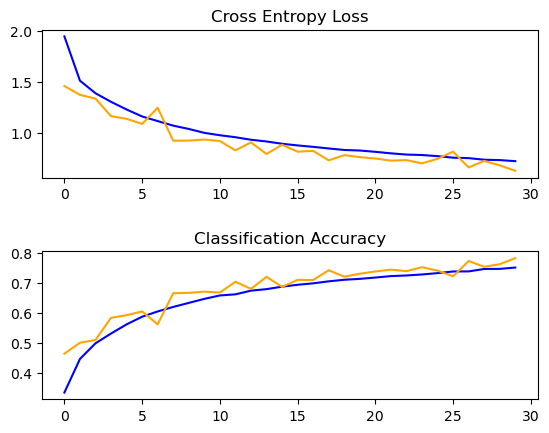

In [14]:
# baseline model with dropout and data augmentation on the cifar10 dataset
import sys
from matplotlib import pyplot
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
from keras.layers import BatchNormalization
 
# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = cifar10.load_data()
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY
 
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm
 
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
	model.add(BatchNormalization())
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.3))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(BatchNormalization())
	model.add(Dropout(0.5))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    
    # Adjust the spacing between the two plots
    pyplot.subplots_adjust(hspace=0.5)  # Adjust the vertical spacing

    pyplot.show()
    pyplot.close()
    
import numpy as np
import random
from keras.utils import to_categorical

def apply_noise_to_labels(labels, noise_level, noise_type='symmetric'):
    noisy_labels = labels.copy()
    n_classes = 10  # CIFAR-10 has 10 classes
    label_mapping = {9: 1, 2: 0, 4: 7, 3: 5, 5: 3}  # Asymmetric mapping

    for i in range(len(noisy_labels)):
        if random.random() < noise_level:
            if noise_type == 'symmetric':
                # Create a list of possible labels excluding the original one
                possible_labels = list(range(n_classes))
                possible_labels.remove(noisy_labels[i])
                noisy_labels[i] = random.choice(possible_labels)
            elif noise_type == 'asymmetric':
                # Only apply noise to labels that are in the asymmetric mapping
                if noisy_labels[i] in label_mapping:
                    noisy_labels[i] = label_mapping[noisy_labels[i]]
    return to_categorical(noisy_labels, num_classes=n_classes)

    
def run_test_harness(noise_level=0.0, noise_type='symmetric'):
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    
    # apply noise to labels
    trainY_noisy = apply_noise_to_labels(np.argmax(trainY, axis=1), noise_level, noise_type)
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # define model
    model = define_model()
    # create data generator
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
    # prepare iterator
    it_train = datagen.flow(trainX, trainY_noisy, batch_size=32)
    # fit model
    steps = int(trainX.shape[0] / 32)
    print ("6 ", steps)
    history = model.fit(it_train, steps_per_epoch=steps, epochs=30, validation_data=(testX, testY), verbose=2)    
    print ("7\n") 
    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=2)
    print(f'Noise Level {noise_level} - Noise Type {noise_type} - Accuracy: {acc * 100.0}%')
    
    summarize_diagnostics(history)
    print ("\n\n\n") 


print(f"#######   Training model with dropout and data augmentation with 0 noise level: ########")
run_test_harness(0, 'symmetric') 
print ("\n\n\n")
noise_levels = [0.1, 0.3, 0.5, 0.8, 0.9]
noise_levels = [0.3, 0.5, 0.8]
noise_types = ['symmetric', 'asymmetric']

# for noise_type in noise_types:
#     for noise_level in noise_levels:
#         print(f"#######   Training with {noise_type} noise level: {noise_level} ########")
#         run_test_harness(noise_level, noise_type)
#         print ("\n\n\n")

#######   Training model ADAM & data augmentation with 0 noise level: ########
6  1562
Epoch 1/30
1562/1562 - 54s - loss: 1.5376 - accuracy: 0.4370 - val_loss: 1.1772 - val_accuracy: 0.5924 - 54s/epoch - 34ms/step
Epoch 2/30
1562/1562 - 51s - loss: 1.0852 - accuracy: 0.6150 - val_loss: 0.9539 - val_accuracy: 0.6710 - 51s/epoch - 33ms/step
Epoch 3/30
1562/1562 - 54s - loss: 0.9047 - accuracy: 0.6799 - val_loss: 0.8410 - val_accuracy: 0.7094 - 54s/epoch - 34ms/step
Epoch 4/30
1562/1562 - 52s - loss: 0.8076 - accuracy: 0.7156 - val_loss: 0.8190 - val_accuracy: 0.7192 - 52s/epoch - 33ms/step
Epoch 5/30
1562/1562 - 57s - loss: 0.7372 - accuracy: 0.7444 - val_loss: 0.7576 - val_accuracy: 0.7412 - 57s/epoch - 37ms/step
Epoch 6/30
1562/1562 - 61s - loss: 0.6922 - accuracy: 0.7578 - val_loss: 0.6595 - val_accuracy: 0.7782 - 61s/epoch - 39ms/step
Epoch 7/30
1562/1562 - 56s - loss: 0.6549 - accuracy: 0.7710 - val_loss: 0.6646 - val_accuracy: 0.7747 - 56s/epoch - 36ms/step
Epoch 8/30
1562/1562 - 5

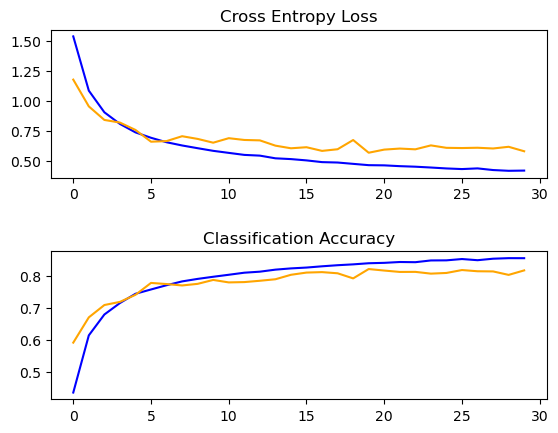

filename:C:\anaconda\lib\site-packages\ipykernel_launcher.py








#######   Training with symmetric noise level: 0.3 ########
6  1562
Epoch 1/30
1562/1562 - 49s - loss: 2.0819 - accuracy: 0.2661 - val_loss: 1.5624 - val_accuracy: 0.4683 - 49s/epoch - 31ms/step
Epoch 2/30
1562/1562 - 46s - loss: 1.9173 - accuracy: 0.3663 - val_loss: 1.3240 - val_accuracy: 0.5829 - 46s/epoch - 30ms/step
Epoch 3/30
1562/1562 - 49s - loss: 1.8272 - accuracy: 0.4207 - val_loss: 1.3997 - val_accuracy: 0.5682 - 49s/epoch - 31ms/step
Epoch 4/30
1562/1562 - 45s - loss: 1.7676 - accuracy: 0.4559 - val_loss: 1.1536 - val_accuracy: 0.6557 - 45s/epoch - 29ms/step
Epoch 5/30
1562/1562 - 43s - loss: 1.7303 - accuracy: 0.4747 - val_loss: 1.1230 - val_accuracy: 0.6806 - 43s/epoch - 27ms/step
Epoch 6/30
1562/1562 - 44s - loss: 1.7065 - accuracy: 0.4871 - val_loss: 1.1203 - val_accuracy: 0.7021 - 44s/epoch - 28ms/step
Epoch 7/30
1562/1562 - 43s - loss: 1.6847 - accuracy: 0.4972 - val_loss: 1.0995 - val_accuracy: 0.702

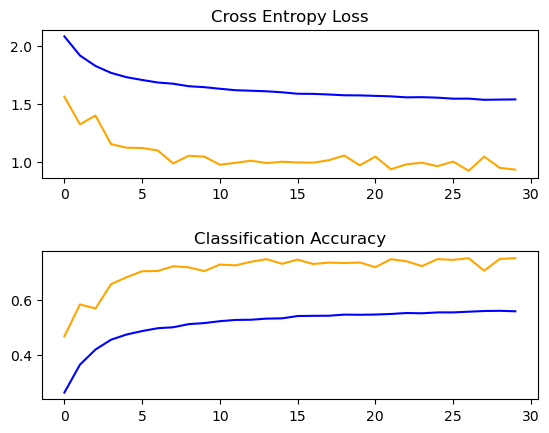

filename:C:\anaconda\lib\site-packages\ipykernel_launcher.py








#######   Training with symmetric noise level: 0.5 ########
6  1562
Epoch 1/30
1562/1562 - 55s - loss: 2.2337 - accuracy: 0.1849 - val_loss: 1.8969 - val_accuracy: 0.4030 - 55s/epoch - 35ms/step
Epoch 2/30
1562/1562 - 53s - loss: 2.1586 - accuracy: 0.2461 - val_loss: 1.7279 - val_accuracy: 0.4744 - 53s/epoch - 34ms/step
Epoch 3/30
1562/1562 - 52s - loss: 2.1238 - accuracy: 0.2760 - val_loss: 1.6008 - val_accuracy: 0.5252 - 52s/epoch - 33ms/step
Epoch 4/30
1562/1562 - 53s - loss: 2.0984 - accuracy: 0.2942 - val_loss: 1.5091 - val_accuracy: 0.5850 - 53s/epoch - 34ms/step
Epoch 5/30
1562/1562 - 58s - loss: 2.0800 - accuracy: 0.3085 - val_loss: 1.4903 - val_accuracy: 0.5913 - 58s/epoch - 37ms/step
Epoch 6/30
1562/1562 - 61s - loss: 2.0675 - accuracy: 0.3170 - val_loss: 1.4815 - val_accuracy: 0.5922 - 61s/epoch - 39ms/step
Epoch 7/30
1562/1562 - 57s - loss: 2.0552 - accuracy: 0.3261 - val_loss: 1.4556 - val_accuracy: 0.602

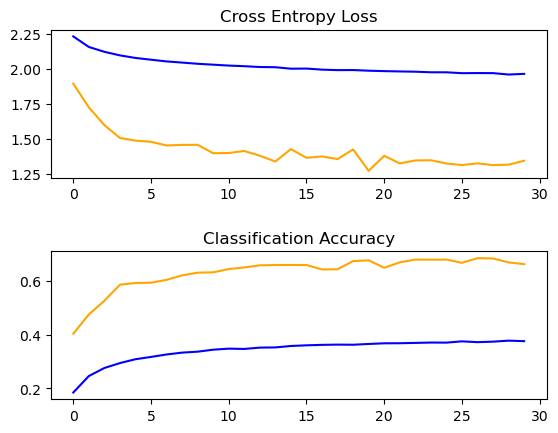

filename:C:\anaconda\lib\site-packages\ipykernel_launcher.py








#######   Training with symmetric noise level: 0.8 ########
6  1562
Epoch 1/30
1562/1562 - 54s - loss: 2.3049 - accuracy: 0.0987 - val_loss: 2.3028 - val_accuracy: 0.1000 - 54s/epoch - 35ms/step
Epoch 2/30
1562/1562 - 47s - loss: 2.3028 - accuracy: 0.1007 - val_loss: 2.3022 - val_accuracy: 0.0999 - 47s/epoch - 30ms/step
Epoch 3/30
1562/1562 - 57s - loss: 2.3028 - accuracy: 0.0989 - val_loss: 2.3030 - val_accuracy: 0.1000 - 57s/epoch - 37ms/step
Epoch 4/30
1562/1562 - 52s - loss: 2.3027 - accuracy: 0.1012 - val_loss: 2.3027 - val_accuracy: 0.1000 - 52s/epoch - 33ms/step
Epoch 5/30
1562/1562 - 50s - loss: 2.3026 - accuracy: 0.1006 - val_loss: 2.3028 - val_accuracy: 0.1000 - 50s/epoch - 32ms/step
Epoch 6/30
1562/1562 - 48s - loss: 2.3027 - accuracy: 0.1002 - val_loss: 2.3027 - val_accuracy: 0.1000 - 48s/epoch - 31ms/step
Epoch 7/30
1562/1562 - 47s - loss: 2.3029 - accuracy: 0.1012 - val_loss: 2.3027 - val_accuracy: 0.100

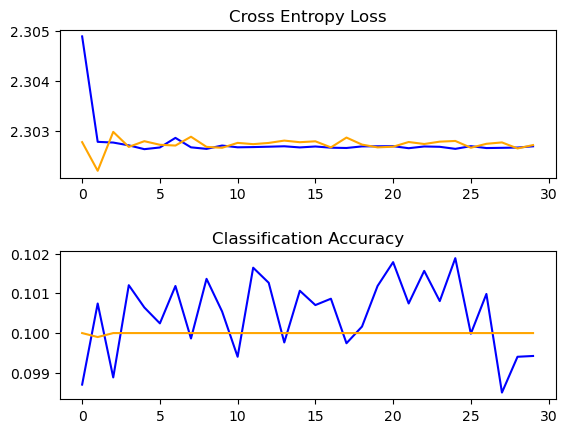

filename:C:\anaconda\lib\site-packages\ipykernel_launcher.py








#######   Training with asymmetric noise level: 0.3 ########
6  1562
Epoch 1/30
1562/1562 - 61s - loss: 1.5529 - accuracy: 0.4272 - val_loss: 1.2434 - val_accuracy: 0.5599 - 61s/epoch - 39ms/step
Epoch 2/30
1562/1562 - 62s - loss: 1.1759 - accuracy: 0.5595 - val_loss: 1.0622 - val_accuracy: 0.6150 - 62s/epoch - 40ms/step
Epoch 3/30
1562/1562 - 61s - loss: 1.0365 - accuracy: 0.6031 - val_loss: 0.9435 - val_accuracy: 0.6672 - 61s/epoch - 39ms/step
Epoch 4/30
1562/1562 - 54s - loss: 0.9656 - accuracy: 0.6286 - val_loss: 0.9420 - val_accuracy: 0.6764 - 54s/epoch - 35ms/step
Epoch 5/30
1562/1562 - 55s - loss: 0.9051 - accuracy: 0.6467 - val_loss: 0.8468 - val_accuracy: 0.7079 - 55s/epoch - 35ms/step
Epoch 6/30


KeyboardInterrupt: 

In [16]:
# baseline model ADAM & data augmentation on the cifar10 dataset
# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

import sys
from matplotlib import pyplot
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = cifar10.load_data()
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY
 
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm
 
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))

    # compile model with Adam optimizer
    opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    
    # Adjust the spacing between the two plots
    pyplot.subplots_adjust(hspace=0.5)  # Adjust the vertical spacing

    pyplot.show()
    filename = sys.argv[0].split('/')[-1]
    print(f"filename:{filename}")
    pyplot.savefig(filename + '_plot.png')
    pyplot.close()
    
import numpy as np
import random
from keras.utils import to_categorical

def apply_noise_to_labels(labels, noise_level, noise_type='symmetric'):
    noisy_labels = labels.copy()
    n_classes = 10  # CIFAR-10 has 10 classes
    label_mapping = {9: 1, 2: 0, 4: 7, 3: 5, 5: 3}  # Asymmetric mapping

    for i in range(len(noisy_labels)):
        if random.random() < noise_level:
            if noise_type == 'symmetric':
                # Create a list of possible labels excluding the original one
                possible_labels = list(range(n_classes))
                possible_labels.remove(noisy_labels[i])
                noisy_labels[i] = random.choice(possible_labels)
            elif noise_type == 'asymmetric':
                # Only apply noise to labels that are in the asymmetric mapping
                if noisy_labels[i] in label_mapping:
                    noisy_labels[i] = label_mapping[noisy_labels[i]]
    return to_categorical(noisy_labels, num_classes=n_classes)

    
def run_test_harness(noise_level=0.0, noise_type='symmetric'):
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    
    # apply noise to labels
    trainY_noisy = apply_noise_to_labels(np.argmax(trainY, axis=1), noise_level, noise_type)
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # define model
    model = define_model()
    # create data generator
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
    # prepare iterator
    it_train = datagen.flow(trainX, trainY_noisy, batch_size=32)
    # fit model
    steps = int(trainX.shape[0] / 32)
    print ("6 ", steps)
    history = model.fit(it_train, steps_per_epoch=steps, epochs=30, validation_data=(testX, testY), verbose=2)    
    print ("7\n") 
    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=2)
    print(f'Noise Level {noise_level} - Noise Type {noise_type} - Accuracy: {acc * 100.0}%')
    summarize_diagnostics(history)
    print ("\n\n\n") 

print(f"#######   Training model ADAM & data augmentation with 0 noise level: ########")
run_test_harness(0, 'symmetric') 
print ("\n\n\n")
noise_levels = [0.1, 0.3, 0.5, 0.8, 0.9]
noise_levels = [0.3, 0.5, 0.8]
noise_types = ['symmetric', 'asymmetric']

for noise_type in noise_types:
    for noise_level in noise_levels:
        print(f"#######   Training with {noise_type} noise level: {noise_level} ########")
        run_test_harness(noise_level, noise_type)
        print ("\n\n\n")